In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Prepare Dataset 

In [7]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../thesis/dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
#data_path = "../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))



ind = int(0.8 * len(index))

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)
p_triu_norm, y_mu, y_std = AbstractDataset.normalize(p_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu_norm, ind)


## ELU 

In [3]:
keras.backend.clear_session()

dim_triu = dim * (dim + 1) // 2
activation = "elu"
learning_rate = 1e-5
intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

model = keras.Sequential()

# input layer
model.add(keras.layers.Dense(dim_triu, activation=activation, input_dim=dim_triu, kernel_initializer=intializer, bias_initializer='zeros'))

# hidden
#for i in range(3):

model.add(keras.layers.Dense(
    dim_triu+250, 
    activation=activation, 
    kernel_initializer=intializer, 
    #bias_initializer='zeros',
    #kernel_regularizer=keras.regularizers.l2(1e-8)
))

model.add(keras.layers.Dense(
    dim_triu+150, 
    activation=activation, 
    kernel_initializer=intializer, 
    #bias_initializer='zeros',
    #kernel_regularizer=keras.regularizers.l2(1e-8)
))

model.add(keras.layers.Dense(
        dim_triu + 50, 
        activation=activation, 
        kernel_initializer=intializer, 
        #bias_initializer='zeros',
        #kernel_regularizer=keras.regularizers.l2(1e-8)
))


#output
model.add(keras.layers.Dense(dim_triu))

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='MSE', metrics=['mae', 'mse'])

In [18]:
filepath = "../" + "TSmall_sto3gmodelTSmall_sto3g_250-150-50+triu.h5"
model = keras.models.load_model(filepath)

OSError: Unable to open file (unable to open file: name = '../TSmall_sto3gmodelTSmall_sto3g_250-150-50+triu.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
filepath = data_path + "model" + postfix + "_Continued.h5"

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-7, 
    patience=200, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=50, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-4, 
    cooldown=50, 
    min_lr=1e-10
)

#checkpoint = keras.callbacks.ModelCheckpoint(
#    filepath, 
#    monitor='val_loss', 
#    verbose=1, 
#    save_best_only=False, 
#    save_weights_only=False, 
#    mode='auto', 
#    period=1
#)

In [5]:
keras.backend.set_value(model.optimizer.lr, 1e-4)

In [9]:
epochs = 10000

while True:
    keras.backend.set_value(model.optimizer.lr, 1e-4)

    history = model.fit(
        x = s_train,
        y = p_train,
        epochs=epochs,
        shuffle=True,
        validation_data=(s_test, p_test), 
        verbose=1, 
        callbacks=[
            early_stopping, 
            reduce_lr, 
            #checkpoint
        ]
    )
    
    print("\n\n\n\n\nNext rouuund!!")

Train on 800 samples, validate on 201 samples
Epoch 1/10000
800/800 [==============================] - 0s 246us/step - loss: 0.0084 - mean_absolute_error: 0.0650 - mean_squared_error: 0.0084 - val_loss: 0.0133 - val_mean_absolute_error: 0.0895 - val_mean_squared_error: 0.0133
Epoch 2/10000
800/800 [==============================] - 0s 255us/step - loss: 0.0087 - mean_absolute_error: 0.0720 - mean_squared_error: 0.0087 - val_loss: 0.0058 - val_mean_absolute_error: 0.0594 - val_mean_squared_error: 0.0058
Epoch 3/10000
800/800 [==============================] - 0s 250us/step - loss: 0.0046 - mean_absolute_error: 0.0521 - mean_squared_error: 0.0046 - val_loss: 0.0034 - val_mean_absolute_error: 0.0450 - val_mean_squared_error: 0.0034
Epoch 4/10000
800/800 [==============================] - 0s 245us/step - loss: 0.0021 - mean_absolute_error: 0.0353 - mean_squared_error: 0.0021 - val_loss: 0.0014 - val_mean_absolute_error: 0.0296 - val_mean_squared_error: 0.0014
Epoch 5/10000
800/800 [=======

800/800 [==============================] - 0s 245us/step - loss: 2.0993e-04 - mean_absolute_error: 0.0112 - mean_squared_error: 2.0993e-04 - val_loss: 3.4344e-04 - val_mean_absolute_error: 0.0142 - val_mean_squared_error: 3.4344e-04
Epoch 35/10000
800/800 [==============================] - 0s 240us/step - loss: 2.0104e-04 - mean_absolute_error: 0.0110 - mean_squared_error: 2.0104e-04 - val_loss: 3.3088e-04 - val_mean_absolute_error: 0.0137 - val_mean_squared_error: 3.3088e-04
Epoch 36/10000
800/800 [==============================] - 0s 230us/step - loss: 1.8789e-04 - mean_absolute_error: 0.0106 - mean_squared_error: 1.8789e-04 - val_loss: 2.9230e-04 - val_mean_absolute_error: 0.0130 - val_mean_squared_error: 2.9230e-04
Epoch 37/10000
800/800 [==============================] - 0s 237us/step - loss: 1.8357e-04 - mean_absolute_error: 0.0104 - mean_squared_error: 1.8357e-04 - val_loss: 3.1538e-04 - val_mean_absolute_error: 0.0134 - val_mean_squared_error: 3.1538e-04
Epoch 38/10000
800/800 

Epoch 67/10000
800/800 [==============================] - 0s 239us/step - loss: 9.9538e-05 - mean_absolute_error: 0.0076 - mean_squared_error: 9.9538e-05 - val_loss: 2.2571e-04 - val_mean_absolute_error: 0.0112 - val_mean_squared_error: 2.2571e-04
Epoch 68/10000
800/800 [==============================] - 0s 248us/step - loss: 9.9188e-05 - mean_absolute_error: 0.0076 - mean_squared_error: 9.9188e-05 - val_loss: 2.2847e-04 - val_mean_absolute_error: 0.0112 - val_mean_squared_error: 2.2847e-04
Epoch 69/10000
800/800 [==============================] - 0s 240us/step - loss: 9.9142e-05 - mean_absolute_error: 0.0076 - mean_squared_error: 9.9142e-05 - val_loss: 2.2886e-04 - val_mean_absolute_error: 0.0113 - val_mean_squared_error: 2.2886e-04
Epoch 70/10000
800/800 [==============================] - 0s 241us/step - loss: 9.7877e-05 - mean_absolute_error: 0.0076 - mean_squared_error: 9.7877e-05 - val_loss: 2.1996e-04 - val_mean_absolute_error: 0.0111 - val_mean_squared_error: 2.1996e-04
Epoch 71

800/800 [==============================] - 0s 264us/step - loss: 1.0607e-04 - mean_absolute_error: 0.0079 - mean_squared_error: 1.0607e-04 - val_loss: 2.1956e-04 - val_mean_absolute_error: 0.0112 - val_mean_squared_error: 2.1956e-04
Epoch 101/10000
800/800 [==============================] - 0s 263us/step - loss: 1.0515e-04 - mean_absolute_error: 0.0078 - mean_squared_error: 1.0515e-04 - val_loss: 2.2710e-04 - val_mean_absolute_error: 0.0113 - val_mean_squared_error: 2.2710e-04
Epoch 102/10000
800/800 [==============================] - 0s 270us/step - loss: 1.0555e-04 - mean_absolute_error: 0.0079 - mean_squared_error: 1.0555e-04 - val_loss: 2.2343e-04 - val_mean_absolute_error: 0.0113 - val_mean_squared_error: 2.2343e-04
Epoch 103/10000
800/800 [==============================] - 0s 257us/step - loss: 1.0857e-04 - mean_absolute_error: 0.0080 - mean_squared_error: 1.0857e-04 - val_loss: 2.2393e-04 - val_mean_absolute_error: 0.0112 - val_mean_squared_error: 2.2393e-04
Epoch 104/10000
800/

Epoch 133/10000
800/800 [==============================] - 0s 266us/step - loss: 1.6101e-04 - mean_absolute_error: 0.0098 - mean_squared_error: 1.6101e-04 - val_loss: 2.6754e-04 - val_mean_absolute_error: 0.0124 - val_mean_squared_error: 2.6754e-04
Epoch 134/10000
800/800 [==============================] - 0s 269us/step - loss: 1.6320e-04 - mean_absolute_error: 0.0099 - mean_squared_error: 1.6320e-04 - val_loss: 2.8775e-04 - val_mean_absolute_error: 0.0130 - val_mean_squared_error: 2.8775e-04
Epoch 135/10000
800/800 [==============================] - 0s 275us/step - loss: 1.6466e-04 - mean_absolute_error: 0.0099 - mean_squared_error: 1.6466e-04 - val_loss: 2.5484e-04 - val_mean_absolute_error: 0.0122 - val_mean_squared_error: 2.5484e-04
Epoch 136/10000
800/800 [==============================] - 0s 279us/step - loss: 1.4098e-04 - mean_absolute_error: 0.0092 - mean_squared_error: 1.4098e-04 - val_loss: 2.4099e-04 - val_mean_absolute_error: 0.0118 - val_mean_squared_error: 2.4099e-04
Epoc

800/800 [==============================] - 0s 504us/step - loss: 7.8693e-05 - mean_absolute_error: 0.0068 - mean_squared_error: 7.8693e-05 - val_loss: 1.8981e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 1.8981e-04
Epoch 166/10000
800/800 [==============================] - 0s 606us/step - loss: 7.8019e-05 - mean_absolute_error: 0.0068 - mean_squared_error: 7.8019e-05 - val_loss: 1.9119e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 1.9119e-04
Epoch 167/10000
800/800 [==============================] - 0s 563us/step - loss: 7.7914e-05 - mean_absolute_error: 0.0068 - mean_squared_error: 7.7914e-05 - val_loss: 1.8814e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 1.8814e-04
Epoch 168/10000
800/800 [==============================] - 0s 544us/step - loss: 7.8612e-05 - mean_absolute_error: 0.0068 - mean_squared_error: 7.8612e-05 - val_loss: 1.8768e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 1.8768e-04
Epoch 169/10000
800/

800/800 [==============================] - 1s 958us/step - loss: 8.0001e-05 - mean_absolute_error: 0.0069 - mean_squared_error: 8.0001e-05 - val_loss: 1.9241e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 1.9241e-04
Epoch 199/10000
800/800 [==============================] - 1s 907us/step - loss: 8.0268e-05 - mean_absolute_error: 0.0069 - mean_squared_error: 8.0268e-05 - val_loss: 1.9007e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 1.9007e-04
Epoch 200/10000
800/800 [==============================] - 1s 899us/step - loss: 7.9978e-05 - mean_absolute_error: 0.0069 - mean_squared_error: 7.9978e-05 - val_loss: 1.8872e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8872e-04
Epoch 201/10000
800/800 [==============================] - 1s 953us/step - loss: 8.1082e-05 - mean_absolute_error: 0.0069 - mean_squared_error: 8.1082e-05 - val_loss: 1.9391e-04 - val_mean_absolute_error: 0.0104 - val_mean_squared_error: 1.9391e-04
Epoch 202/10000
800/

Epoch 231/10000
800/800 [==============================] - 1s 853us/step - loss: 8.2874e-05 - mean_absolute_error: 0.0070 - mean_squared_error: 8.2874e-05 - val_loss: 1.8768e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 1.8768e-04
Epoch 232/10000
800/800 [==============================] - 1s 892us/step - loss: 8.2729e-05 - mean_absolute_error: 0.0070 - mean_squared_error: 8.2729e-05 - val_loss: 1.8657e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 1.8657e-04
Epoch 233/10000
800/800 [==============================] - 1s 895us/step - loss: 8.2527e-05 - mean_absolute_error: 0.0070 - mean_squared_error: 8.2527e-05 - val_loss: 1.9667e-04 - val_mean_absolute_error: 0.0104 - val_mean_squared_error: 1.9667e-04
Epoch 234/10000
800/800 [==============================] - 1s 836us/step - loss: 8.3823e-05 - mean_absolute_error: 0.0070 - mean_squared_error: 8.3823e-05 - val_loss: 1.8811e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 1.8811e-04
Epoc

Epoch 264/10000
800/800 [==============================] - 1s 906us/step - loss: 6.6853e-05 - mean_absolute_error: 0.0063 - mean_squared_error: 6.6853e-05 - val_loss: 1.7247e-04 - val_mean_absolute_error: 0.0098 - val_mean_squared_error: 1.7247e-04
Epoch 265/10000
800/800 [==============================] - 1s 890us/step - loss: 6.6396e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 6.6396e-05 - val_loss: 1.7376e-04 - val_mean_absolute_error: 0.0098 - val_mean_squared_error: 1.7376e-04
Epoch 266/10000
800/800 [==============================] - 1s 843us/step - loss: 6.6161e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 6.6161e-05 - val_loss: 1.7109e-04 - val_mean_absolute_error: 0.0097 - val_mean_squared_error: 1.7109e-04
Epoch 267/10000
800/800 [==============================] - 1s 899us/step - loss: 6.6218e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 6.6218e-05 - val_loss: 1.7063e-04 - val_mean_absolute_error: 0.0098 - val_mean_squared_error: 1.7063e-04
Epoc

Epoch 297/10000
800/800 [==============================] - 1s 923us/step - loss: 6.6380e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 6.6380e-05 - val_loss: 1.6859e-04 - val_mean_absolute_error: 0.0097 - val_mean_squared_error: 1.6859e-04
Epoch 298/10000
800/800 [==============================] - 1s 914us/step - loss: 6.6891e-05 - mean_absolute_error: 0.0063 - mean_squared_error: 6.6891e-05 - val_loss: 1.6857e-04 - val_mean_absolute_error: 0.0097 - val_mean_squared_error: 1.6857e-04
Epoch 299/10000
800/800 [==============================] - 1s 907us/step - loss: 6.6181e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 6.6181e-05 - val_loss: 1.6967e-04 - val_mean_absolute_error: 0.0097 - val_mean_squared_error: 1.6967e-04
Epoch 300/10000
800/800 [==============================] - 1s 891us/step - loss: 6.5960e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 6.5960e-05 - val_loss: 1.7061e-04 - val_mean_absolute_error: 0.0097 - val_mean_squared_error: 1.7061e-04
Epoc

Epoch 330/10000
800/800 [==============================] - 1s 851us/step - loss: 6.5410e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 6.5410e-05 - val_loss: 1.6793e-04 - val_mean_absolute_error: 0.0097 - val_mean_squared_error: 1.6793e-04
Epoch 331/10000
800/800 [==============================] - 1s 801us/step - loss: 6.5975e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 6.5975e-05 - val_loss: 1.6910e-04 - val_mean_absolute_error: 0.0097 - val_mean_squared_error: 1.6910e-04
Epoch 332/10000
800/800 [==============================] - 1s 822us/step - loss: 6.5510e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 6.5510e-05 - val_loss: 1.6613e-04 - val_mean_absolute_error: 0.0097 - val_mean_squared_error: 1.6613e-04
Epoch 333/10000
800/800 [==============================] - 1s 953us/step - loss: 6.5579e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 6.5579e-05 - val_loss: 1.6623e-04 - val_mean_absolute_error: 0.0096 - val_mean_squared_error: 1.6623e-04
Epoc

Epoch 363/10000
800/800 [==============================] - 1s 927us/step - loss: 5.8491e-05 - mean_absolute_error: 0.0059 - mean_squared_error: 5.8491e-05 - val_loss: 1.5975e-04 - val_mean_absolute_error: 0.0094 - val_mean_squared_error: 1.5975e-04
Epoch 364/10000
800/800 [==============================] - 1s 909us/step - loss: 5.8427e-05 - mean_absolute_error: 0.0059 - mean_squared_error: 5.8427e-05 - val_loss: 1.5964e-04 - val_mean_absolute_error: 0.0094 - val_mean_squared_error: 1.5964e-04
Epoch 365/10000
800/800 [==============================] - 1s 881us/step - loss: 5.8366e-05 - mean_absolute_error: 0.0059 - mean_squared_error: 5.8366e-05 - val_loss: 1.6038e-04 - val_mean_absolute_error: 0.0094 - val_mean_squared_error: 1.6038e-04
Epoch 366/10000
800/800 [==============================] - 1s 962us/step - loss: 5.8157e-05 - mean_absolute_error: 0.0058 - mean_squared_error: 5.8157e-05 - val_loss: 1.5975e-04 - val_mean_absolute_error: 0.0094 - val_mean_squared_error: 1.5975e-04
Epoc

Epoch 396/10000
800/800 [==============================] - 1s 842us/step - loss: 5.8101e-05 - mean_absolute_error: 0.0058 - mean_squared_error: 5.8101e-05 - val_loss: 1.5820e-04 - val_mean_absolute_error: 0.0094 - val_mean_squared_error: 1.5820e-04
Epoch 397/10000
800/800 [==============================] - 1s 895us/step - loss: 5.8165e-05 - mean_absolute_error: 0.0058 - mean_squared_error: 5.8165e-05 - val_loss: 1.5898e-04 - val_mean_absolute_error: 0.0094 - val_mean_squared_error: 1.5898e-04
Epoch 398/10000
800/800 [==============================] - 1s 843us/step - loss: 5.8126e-05 - mean_absolute_error: 0.0058 - mean_squared_error: 5.8126e-05 - val_loss: 1.6054e-04 - val_mean_absolute_error: 0.0094 - val_mean_squared_error: 1.6054e-04
Epoch 399/10000
800/800 [==============================] - 1s 850us/step - loss: 5.8012e-05 - mean_absolute_error: 0.0058 - mean_squared_error: 5.8012e-05 - val_loss: 1.5825e-04 - val_mean_absolute_error: 0.0094 - val_mean_squared_error: 1.5825e-04
Epoc

Epoch 429/10000
800/800 [==============================] - 1s 950us/step - loss: 5.7630e-05 - mean_absolute_error: 0.0058 - mean_squared_error: 5.7630e-05 - val_loss: 1.5736e-04 - val_mean_absolute_error: 0.0094 - val_mean_squared_error: 1.5736e-04
Epoch 430/10000
800/800 [==============================] - 1s 898us/step - loss: 5.7691e-05 - mean_absolute_error: 0.0058 - mean_squared_error: 5.7691e-05 - val_loss: 1.5614e-04 - val_mean_absolute_error: 0.0093 - val_mean_squared_error: 1.5614e-04
Epoch 431/10000
800/800 [==============================] - 1s 895us/step - loss: 5.7168e-05 - mean_absolute_error: 0.0058 - mean_squared_error: 5.7168e-05 - val_loss: 1.5694e-04 - val_mean_absolute_error: 0.0093 - val_mean_squared_error: 1.5694e-04
Epoch 432/10000
800/800 [==============================] - 1s 851us/step - loss: 5.7116e-05 - mean_absolute_error: 0.0058 - mean_squared_error: 5.7116e-05 - val_loss: 1.5613e-04 - val_mean_absolute_error: 0.0093 - val_mean_squared_error: 1.5613e-04
Epoc

Epoch 462/10000
800/800 [==============================] - 1s 908us/step - loss: 5.4144e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.4144e-05 - val_loss: 1.5400e-04 - val_mean_absolute_error: 0.0092 - val_mean_squared_error: 1.5400e-04
Epoch 463/10000
800/800 [==============================] - 1s 834us/step - loss: 5.3952e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.3952e-05 - val_loss: 1.5336e-04 - val_mean_absolute_error: 0.0092 - val_mean_squared_error: 1.5336e-04
Epoch 464/10000
800/800 [==============================] - 1s 1ms/step - loss: 5.4054e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.4054e-05 - val_loss: 1.5281e-04 - val_mean_absolute_error: 0.0092 - val_mean_squared_error: 1.5281e-04
Epoch 465/10000
800/800 [==============================] - 1s 913us/step - loss: 5.3870e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.3870e-05 - val_loss: 1.5350e-04 - val_mean_absolute_error: 0.0092 - val_mean_squared_error: 1.5350e-04
Epoch 

Epoch 495/10000
800/800 [==============================] - 1s 901us/step - loss: 5.3688e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.3688e-05 - val_loss: 1.5210e-04 - val_mean_absolute_error: 0.0092 - val_mean_squared_error: 1.5210e-04
Epoch 496/10000
800/800 [==============================] - 1s 898us/step - loss: 5.3785e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.3785e-05 - val_loss: 1.5219e-04 - val_mean_absolute_error: 0.0092 - val_mean_squared_error: 1.5219e-04
Epoch 497/10000
800/800 [==============================] - 1s 888us/step - loss: 5.3764e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.3764e-05 - val_loss: 1.5229e-04 - val_mean_absolute_error: 0.0092 - val_mean_squared_error: 1.5229e-04
Epoch 498/10000
800/800 [==============================] - 1s 946us/step - loss: 5.3665e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.3665e-05 - val_loss: 1.5294e-04 - val_mean_absolute_error: 0.0092 - val_mean_squared_error: 1.5294e-04
Epoc

Epoch 528/10000
800/800 [==============================] - 1s 916us/step - loss: 5.3282e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.3282e-05 - val_loss: 1.5188e-04 - val_mean_absolute_error: 0.0092 - val_mean_squared_error: 1.5188e-04
Epoch 529/10000
800/800 [==============================] - 1s 892us/step - loss: 5.3261e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.3261e-05 - val_loss: 1.5145e-04 - val_mean_absolute_error: 0.0092 - val_mean_squared_error: 1.5145e-04
Epoch 530/10000
800/800 [==============================] - 1s 938us/step - loss: 5.3333e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.3333e-05 - val_loss: 1.5184e-04 - val_mean_absolute_error: 0.0092 - val_mean_squared_error: 1.5184e-04
Epoch 531/10000
800/800 [==============================] - 1s 904us/step - loss: 5.3340e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.3340e-05 - val_loss: 1.5099e-04 - val_mean_absolute_error: 0.0092 - val_mean_squared_error: 1.5099e-04
Epoc

800/800 [==============================] - 1s 917us/step - loss: 5.1681e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.1681e-05 - val_loss: 1.5009e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.5009e-04
Epoch 561/10000
800/800 [==============================] - 1s 909us/step - loss: 5.1686e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.1686e-05 - val_loss: 1.4987e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4987e-04
Epoch 562/10000
800/800 [==============================] - 1s 906us/step - loss: 5.1751e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.1751e-05 - val_loss: 1.5010e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.5010e-04
Epoch 563/10000
800/800 [==============================] - 1s 816us/step - loss: 5.1638e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.1638e-05 - val_loss: 1.5047e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.5047e-04
Epoch 564/10000
800/

Epoch 593/10000
800/800 [==============================] - 1s 1ms/step - loss: 5.1434e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.1434e-05 - val_loss: 1.4988e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4988e-04
Epoch 594/10000
800/800 [==============================] - 1s 966us/step - loss: 5.1472e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.1472e-05 - val_loss: 1.4945e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4945e-04
Epoch 595/10000
800/800 [==============================] - 1s 794us/step - loss: 5.1420e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.1420e-05 - val_loss: 1.4973e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4973e-04
Epoch 596/10000
800/800 [==============================] - 1s 942us/step - loss: 5.1487e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.1487e-05 - val_loss: 1.4921e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4921e-04
Epoch 

Epoch 626/10000
800/800 [==============================] - 1s 801us/step - loss: 5.1304e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.1304e-05 - val_loss: 1.4951e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4951e-04
Epoch 627/10000
800/800 [==============================] - 1s 975us/step - loss: 5.1179e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.1179e-05 - val_loss: 1.4891e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4891e-04
Epoch 628/10000
800/800 [==============================] - 1s 967us/step - loss: 5.1314e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.1314e-05 - val_loss: 1.4899e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4899e-04
Epoch 629/10000
800/800 [==============================] - 1s 846us/step - loss: 5.1287e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.1287e-05 - val_loss: 1.4891e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4891e-04
Epoc

800/800 [==============================] - 1s 923us/step - loss: 5.0420e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.0420e-05 - val_loss: 1.4835e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4835e-04
Epoch 659/10000
800/800 [==============================] - 1s 893us/step - loss: 5.0406e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.0406e-05 - val_loss: 1.4837e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4837e-04
Epoch 660/10000
800/800 [==============================] - 1s 899us/step - loss: 5.0420e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.0420e-05 - val_loss: 1.4859e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4859e-04
Epoch 661/10000
800/800 [==============================] - 1s 920us/step - loss: 5.0447e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.0447e-05 - val_loss: 1.4820e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4820e-04
Epoch 662/10000
800/

800/800 [==============================] - 1s 961us/step - loss: 5.0298e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.0298e-05 - val_loss: 1.4828e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4828e-04
Epoch 692/10000
800/800 [==============================] - 1s 954us/step - loss: 5.0316e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.0316e-05 - val_loss: 1.4826e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4826e-04
Epoch 693/10000
800/800 [==============================] - 1s 881us/step - loss: 5.0298e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.0298e-05 - val_loss: 1.4816e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4816e-04
Epoch 694/10000
800/800 [==============================] - 1s 910us/step - loss: 5.0295e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.0295e-05 - val_loss: 1.4820e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4820e-04
Epoch 695/10000
800/

800/800 [==============================] - 1s 897us/step - loss: 5.0226e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.0226e-05 - val_loss: 1.4786e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4786e-04
Epoch 725/10000
800/800 [==============================] - 1s 883us/step - loss: 5.0188e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.0188e-05 - val_loss: 1.4808e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4808e-04
Epoch 726/10000
800/800 [==============================] - 1s 896us/step - loss: 5.0207e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.0207e-05 - val_loss: 1.4795e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4795e-04
Epoch 727/10000
800/800 [==============================] - 1s 906us/step - loss: 5.0192e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.0192e-05 - val_loss: 1.4789e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4789e-04
Epoch 728/10000
800/

Epoch 757/10000
800/800 [==============================] - 1s 918us/step - loss: 4.9794e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9794e-05 - val_loss: 1.4758e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4758e-04
Epoch 758/10000
800/800 [==============================] - 1s 927us/step - loss: 4.9795e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9795e-05 - val_loss: 1.4780e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4780e-04
Epoch 759/10000
800/800 [==============================] - 1s 893us/step - loss: 4.9784e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9784e-05 - val_loss: 1.4767e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4767e-04
Epoch 760/10000
800/800 [==============================] - 1s 908us/step - loss: 4.9781e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9781e-05 - val_loss: 1.4773e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4773e-04
Epoc

Epoch 790/10000
800/800 [==============================] - 1s 953us/step - loss: 4.9745e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9745e-05 - val_loss: 1.4770e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4770e-04
Epoch 791/10000
800/800 [==============================] - 1s 902us/step - loss: 4.9727e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9727e-05 - val_loss: 1.4763e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4763e-04
Epoch 792/10000
800/800 [==============================] - 1s 854us/step - loss: 4.9735e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9735e-05 - val_loss: 1.4745e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4745e-04
Epoch 793/10000
800/800 [==============================] - 1s 961us/step - loss: 4.9740e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9740e-05 - val_loss: 1.4747e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4747e-04
Epoc

Epoch 823/10000
800/800 [==============================] - 1s 909us/step - loss: 4.9702e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9702e-05 - val_loss: 1.4751e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4751e-04
Epoch 824/10000
800/800 [==============================] - 1s 922us/step - loss: 4.9687e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9687e-05 - val_loss: 1.4740e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4740e-04
Epoch 825/10000
800/800 [==============================] - 1s 909us/step - loss: 4.9669e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9669e-05 - val_loss: 1.4744e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4744e-04
Epoch 826/10000
800/800 [==============================] - 1s 939us/step - loss: 4.9681e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9681e-05 - val_loss: 1.4748e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4748e-04
Epoc

Epoch 856/10000
800/800 [==============================] - 1s 950us/step - loss: 4.9479e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9479e-05 - val_loss: 1.4735e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4735e-04
Epoch 857/10000
800/800 [==============================] - 1s 956us/step - loss: 4.9479e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9479e-05 - val_loss: 1.4737e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4737e-04
Epoch 858/10000
800/800 [==============================] - 1s 838us/step - loss: 4.9474e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9474e-05 - val_loss: 1.4733e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4733e-04
Epoch 859/10000
800/800 [==============================] - 1s 967us/step - loss: 4.9478e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9478e-05 - val_loss: 1.4739e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4739e-04
Epoc

Epoch 889/10000
800/800 [==============================] - 1s 921us/step - loss: 4.9457e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9457e-05 - val_loss: 1.4725e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4725e-04
Epoch 890/10000
800/800 [==============================] - 1s 920us/step - loss: 4.9453e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9453e-05 - val_loss: 1.4729e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4729e-04
Epoch 891/10000
800/800 [==============================] - 1s 845us/step - loss: 4.9452e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9452e-05 - val_loss: 1.4729e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4729e-04
Epoch 892/10000
800/800 [==============================] - 1s 954us/step - loss: 4.9464e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9464e-05 - val_loss: 1.4723e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4723e-04
Epoc

Epoch 922/10000
800/800 [==============================] - 1s 768us/step - loss: 4.9429e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9429e-05 - val_loss: 1.4719e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4719e-04
Epoch 923/10000
800/800 [==============================] - 1s 894us/step - loss: 4.9420e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9420e-05 - val_loss: 1.4719e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4719e-04
Epoch 924/10000
800/800 [==============================] - 1s 905us/step - loss: 4.9426e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9426e-05 - val_loss: 1.4718e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4718e-04
Epoch 925/10000
800/800 [==============================] - 1s 909us/step - loss: 4.9419e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9419e-05 - val_loss: 1.4718e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4718e-04
Epoc

Epoch 955/10000
800/800 [==============================] - 1s 839us/step - loss: 4.9325e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9325e-05 - val_loss: 1.4715e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4715e-04
Epoch 956/10000
800/800 [==============================] - 1s 1ms/step - loss: 4.9328e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9328e-05 - val_loss: 1.4710e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4710e-04
Epoch 957/10000
800/800 [==============================] - 1s 917us/step - loss: 4.9322e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9322e-05 - val_loss: 1.4714e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4714e-04
Epoch 958/10000
800/800 [==============================] - 1s 918us/step - loss: 4.9320e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9320e-05 - val_loss: 1.4713e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4713e-04
Epoch 

Epoch 988/10000
800/800 [==============================] - 1s 906us/step - loss: 4.9307e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9307e-05 - val_loss: 1.4709e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4709e-04
Epoch 989/10000
800/800 [==============================] - 1s 848us/step - loss: 4.9316e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9316e-05 - val_loss: 1.4711e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4711e-04
Epoch 990/10000
800/800 [==============================] - 1s 952us/step - loss: 4.9311e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9311e-05 - val_loss: 1.4713e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4713e-04
Epoch 991/10000
800/800 [==============================] - 1s 980us/step - loss: 4.9310e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9310e-05 - val_loss: 1.4705e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4705e-04
Epoc

Epoch 1021/10000
800/800 [==============================] - 1s 870us/step - loss: 4.9292e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9292e-05 - val_loss: 1.4705e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4705e-04
Epoch 1022/10000
800/800 [==============================] - 1s 899us/step - loss: 4.9297e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9297e-05 - val_loss: 1.4712e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4712e-04
Epoch 1023/10000
800/800 [==============================] - 1s 846us/step - loss: 4.9298e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9298e-05 - val_loss: 1.4708e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4708e-04
Epoch 1024/10000
800/800 [==============================] - 1s 905us/step - loss: 4.9298e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9298e-05 - val_loss: 1.4705e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4705e-04


800/800 [==============================] - 1s 858us/step - loss: 4.9246e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9246e-05 - val_loss: 1.4702e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4702e-04
Epoch 1054/10000
800/800 [==============================] - 1s 881us/step - loss: 4.9244e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9244e-05 - val_loss: 1.4703e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4703e-04
Epoch 1055/10000
800/800 [==============================] - 1s 899us/step - loss: 4.9246e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9246e-05 - val_loss: 1.4701e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4701e-04
Epoch 1056/10000
800/800 [==============================] - 1s 1ms/step - loss: 4.9246e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9246e-05 - val_loss: 1.4705e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4705e-04
Epoch 1057/10000
80

Epoch 1086/10000
800/800 [==============================] - 1s 849us/step - loss: 4.9240e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9240e-05 - val_loss: 1.4704e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4704e-04
Epoch 1087/10000
800/800 [==============================] - 1s 849us/step - loss: 4.9237e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9237e-05 - val_loss: 1.4702e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4702e-04
Epoch 1088/10000
800/800 [==============================] - 1s 958us/step - loss: 4.9239e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9239e-05 - val_loss: 1.4702e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4702e-04
Epoch 1089/10000
800/800 [==============================] - 1s 849us/step - loss: 4.9238e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9238e-05 - val_loss: 1.4703e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4703e-04


800/800 [==============================] - 1s 850us/step - loss: 4.9232e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9232e-05 - val_loss: 1.4702e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4702e-04
Epoch 1119/10000
800/800 [==============================] - 1s 899us/step - loss: 4.9233e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9233e-05 - val_loss: 1.4699e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4699e-04
Epoch 1120/10000
800/800 [==============================] - 1s 883us/step - loss: 4.9235e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9235e-05 - val_loss: 1.4703e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4703e-04
Epoch 1121/10000
800/800 [==============================] - 1s 940us/step - loss: 4.9229e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9229e-05 - val_loss: 1.4700e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4700e-04
Epoch 1122/10000


800/800 [==============================] - 1s 892us/step - loss: 4.9205e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9205e-05 - val_loss: 1.4699e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4699e-04
Epoch 1151/10000
800/800 [==============================] - 1s 856us/step - loss: 4.9205e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9205e-05 - val_loss: 1.4699e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4699e-04
Epoch 1152/10000
800/800 [==============================] - 1s 891us/step - loss: 4.9206e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9206e-05 - val_loss: 1.4700e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4700e-04
Epoch 1153/10000
800/800 [==============================] - 1s 879us/step - loss: 4.9206e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9206e-05 - val_loss: 1.4700e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4700e-04
Epoch 1154/10000


Epoch 1183/10000
800/800 [==============================] - 1s 957us/step - loss: 4.9202e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9202e-05 - val_loss: 1.4698e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4698e-04
Epoch 1184/10000
800/800 [==============================] - 1s 838us/step - loss: 4.9203e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9203e-05 - val_loss: 1.4699e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4699e-04
Epoch 1185/10000
800/800 [==============================] - 1s 943us/step - loss: 4.9202e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9202e-05 - val_loss: 1.4699e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4699e-04
Epoch 1186/10000
800/800 [==============================] - 1s 905us/step - loss: 4.9202e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9202e-05 - val_loss: 1.4699e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4699e-04


Epoch 1216/10000
800/800 [==============================] - 1s 884us/step - loss: 4.9198e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9198e-05 - val_loss: 1.4698e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4698e-04
Epoch 1217/10000
800/800 [==============================] - 1s 950us/step - loss: 4.9199e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9199e-05 - val_loss: 1.4698e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4698e-04
Epoch 1218/10000
800/800 [==============================] - 1s 949us/step - loss: 4.9197e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9197e-05 - val_loss: 1.4698e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4698e-04
Epoch 1219/10000
800/800 [==============================] - 1s 850us/step - loss: 4.9199e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.9199e-05 - val_loss: 1.4698e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4698e-04


Epoch 16/10000
800/800 [==============================] - 1s 891us/step - loss: 1.0811e-04 - mean_absolute_error: 0.0080 - mean_squared_error: 1.0811e-04 - val_loss: 2.0608e-04 - val_mean_absolute_error: 0.0108 - val_mean_squared_error: 2.0608e-04
Epoch 17/10000
800/800 [==============================] - 1s 848us/step - loss: 1.0237e-04 - mean_absolute_error: 0.0078 - mean_squared_error: 1.0237e-04 - val_loss: 2.0858e-04 - val_mean_absolute_error: 0.0109 - val_mean_squared_error: 2.0858e-04
Epoch 18/10000
800/800 [==============================] - 1s 940us/step - loss: 1.0708e-04 - mean_absolute_error: 0.0080 - mean_squared_error: 1.0708e-04 - val_loss: 2.0618e-04 - val_mean_absolute_error: 0.0108 - val_mean_squared_error: 2.0618e-04
Epoch 19/10000
800/800 [==============================] - 1s 914us/step - loss: 1.0429e-04 - mean_absolute_error: 0.0079 - mean_squared_error: 1.0429e-04 - val_loss: 1.9628e-04 - val_mean_absolute_error: 0.0106 - val_mean_squared_error: 1.9628e-04
Epoch 20

800/800 [==============================] - 1s 905us/step - loss: 4.6693e-04 - mean_absolute_error: 0.0164 - mean_squared_error: 4.6693e-04 - val_loss: 5.5904e-04 - val_mean_absolute_error: 0.0181 - val_mean_squared_error: 5.5904e-04
Epoch 50/10000
800/800 [==============================] - 1s 889us/step - loss: 4.5607e-04 - mean_absolute_error: 0.0164 - mean_squared_error: 4.5607e-04 - val_loss: 5.0843e-04 - val_mean_absolute_error: 0.0174 - val_mean_squared_error: 5.0843e-04
Epoch 51/10000
800/800 [==============================] - 1s 954us/step - loss: 4.1388e-04 - mean_absolute_error: 0.0157 - mean_squared_error: 4.1388e-04 - val_loss: 4.9838e-04 - val_mean_absolute_error: 0.0173 - val_mean_squared_error: 4.9838e-04
Epoch 52/10000
800/800 [==============================] - 1s 846us/step - loss: 4.4106e-04 - mean_absolute_error: 0.0162 - mean_squared_error: 4.4106e-04 - val_loss: 5.7454e-04 - val_mean_absolute_error: 0.0187 - val_mean_squared_error: 5.7454e-04
Epoch 53/10000
800/800 

Epoch 82/10000
800/800 [==============================] - 1s 888us/step - loss: 6.2569e-05 - mean_absolute_error: 0.0061 - mean_squared_error: 6.2569e-05 - val_loss: 1.5502e-04 - val_mean_absolute_error: 0.0093 - val_mean_squared_error: 1.5502e-04
Epoch 83/10000
800/800 [==============================] - 1s 958us/step - loss: 6.2205e-05 - mean_absolute_error: 0.0061 - mean_squared_error: 6.2205e-05 - val_loss: 1.5588e-04 - val_mean_absolute_error: 0.0093 - val_mean_squared_error: 1.5588e-04
Epoch 84/10000
800/800 [==============================] - 1s 897us/step - loss: 6.2142e-05 - mean_absolute_error: 0.0061 - mean_squared_error: 6.2142e-05 - val_loss: 1.5378e-04 - val_mean_absolute_error: 0.0093 - val_mean_squared_error: 1.5378e-04
Epoch 85/10000
800/800 [==============================] - 1s 874us/step - loss: 6.1632e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 6.1632e-05 - val_loss: 1.5372e-04 - val_mean_absolute_error: 0.0093 - val_mean_squared_error: 1.5372e-04
Epoch 86

Epoch 115/10000
800/800 [==============================] - 1s 918us/step - loss: 7.4513e-05 - mean_absolute_error: 0.0066 - mean_squared_error: 7.4513e-05 - val_loss: 1.6904e-04 - val_mean_absolute_error: 0.0098 - val_mean_squared_error: 1.6904e-04
Epoch 116/10000
800/800 [==============================] - 1s 939us/step - loss: 7.7298e-05 - mean_absolute_error: 0.0068 - mean_squared_error: 7.7298e-05 - val_loss: 1.6594e-04 - val_mean_absolute_error: 0.0097 - val_mean_squared_error: 1.6594e-04
Epoch 117/10000
800/800 [==============================] - 1s 899us/step - loss: 7.6647e-05 - mean_absolute_error: 0.0068 - mean_squared_error: 7.6647e-05 - val_loss: 1.6829e-04 - val_mean_absolute_error: 0.0098 - val_mean_squared_error: 1.6829e-04
Epoch 118/10000
800/800 [==============================] - 1s 909us/step - loss: 7.6374e-05 - mean_absolute_error: 0.0068 - mean_squared_error: 7.6374e-05 - val_loss: 1.6319e-04 - val_mean_absolute_error: 0.0096 - val_mean_squared_error: 1.6319e-04
Epoc

Epoch 148/10000
800/800 [==============================] - 1s 899us/step - loss: 1.2373e-04 - mean_absolute_error: 0.0086 - mean_squared_error: 1.2373e-04 - val_loss: 2.1143e-04 - val_mean_absolute_error: 0.0112 - val_mean_squared_error: 2.1143e-04
Epoch 149/10000
800/800 [==============================] - 1s 913us/step - loss: 1.3160e-04 - mean_absolute_error: 0.0089 - mean_squared_error: 1.3160e-04 - val_loss: 2.1998e-04 - val_mean_absolute_error: 0.0114 - val_mean_squared_error: 2.1998e-04
Epoch 150/10000
800/800 [==============================] - ETA: 0s - loss: 1.3063e-04 - mean_absolute_error: 0.0089 - mean_squared_error: 1.3063e- - 1s 942us/step - loss: 1.3115e-04 - mean_absolute_error: 0.0089 - mean_squared_error: 1.3115e-04 - val_loss: 2.2091e-04 - val_mean_absolute_error: 0.0113 - val_mean_squared_error: 2.2091e-04
Epoch 151/10000
800/800 [==============================] - 1s 899us/step - loss: 1.3775e-04 - mean_absolute_error: 0.0091 - mean_squared_error: 1.3775e-04 - val_lo

800/800 [==============================] - 1s 901us/step - loss: 5.0435e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.0435e-05 - val_loss: 1.3475e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.3475e-04
Epoch 181/10000
800/800 [==============================] - 1s 912us/step - loss: 5.0329e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.0329e-05 - val_loss: 1.3527e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.3527e-04
Epoch 182/10000
800/800 [==============================] - 1s 858us/step - loss: 5.0345e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.0345e-05 - val_loss: 1.3430e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.3430e-04
Epoch 183/10000
800/800 [==============================] - 1s 854us/step - loss: 5.0814e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.0814e-05 - val_loss: 1.3659e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.3659e-04
Epoch 184/10000
800/

800/800 [==============================] - 1s 910us/step - loss: 5.4851e-05 - mean_absolute_error: 0.0057 - mean_squared_error: 5.4851e-05 - val_loss: 1.3740e-04 - val_mean_absolute_error: 0.0088 - val_mean_squared_error: 1.3740e-04
Epoch 214/10000
800/800 [==============================] - 1s 880us/step - loss: 5.4386e-05 - mean_absolute_error: 0.0057 - mean_squared_error: 5.4386e-05 - val_loss: 1.3805e-04 - val_mean_absolute_error: 0.0088 - val_mean_squared_error: 1.3805e-04
Epoch 215/10000
800/800 [==============================] - 1s 847us/step - loss: 5.3517e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.3517e-05 - val_loss: 1.3669e-04 - val_mean_absolute_error: 0.0088 - val_mean_squared_error: 1.3669e-04
Epoch 216/10000
800/800 [==============================] - 1s 955us/step - loss: 5.5062e-05 - mean_absolute_error: 0.0057 - mean_squared_error: 5.5062e-05 - val_loss: 1.3642e-04 - val_mean_absolute_error: 0.0088 - val_mean_squared_error: 1.3642e-04
Epoch 217/10000
800/

Epoch 246/10000
800/800 [==============================] - 1s 892us/step - loss: 5.5267e-05 - mean_absolute_error: 0.0058 - mean_squared_error: 5.5267e-05 - val_loss: 1.3635e-04 - val_mean_absolute_error: 0.0088 - val_mean_squared_error: 1.3635e-04
Epoch 247/10000
800/800 [==============================] - 1s 902us/step - loss: 5.7283e-05 - mean_absolute_error: 0.0059 - mean_squared_error: 5.7283e-05 - val_loss: 1.4521e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.4521e-04
Epoch 248/10000
800/800 [==============================] - 1s 910us/step - loss: 5.8457e-05 - mean_absolute_error: 0.0059 - mean_squared_error: 5.8457e-05 - val_loss: 1.3948e-04 - val_mean_absolute_error: 0.0089 - val_mean_squared_error: 1.3948e-04
Epoch 249/10000
800/800 [==============================] - 1s 931us/step - loss: 5.8342e-05 - mean_absolute_error: 0.0059 - mean_squared_error: 5.8342e-05 - val_loss: 1.4022e-04 - val_mean_absolute_error: 0.0089 - val_mean_squared_error: 1.4022e-04
Epoc

800/800 [==============================] - 1s 844us/step - loss: 4.3334e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3334e-05 - val_loss: 1.2454e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.2454e-04
Epoch 279/10000
800/800 [==============================] - 1s 871us/step - loss: 4.3869e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3869e-05 - val_loss: 1.2487e-04 - val_mean_absolute_error: 0.0084 - val_mean_squared_error: 1.2487e-04
Epoch 280/10000
800/800 [==============================] - 1s 971us/step - loss: 4.3689e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3689e-05 - val_loss: 1.2560e-04 - val_mean_absolute_error: 0.0084 - val_mean_squared_error: 1.2560e-04
Epoch 281/10000
800/800 [==============================] - 1s 881us/step - loss: 4.3380e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3380e-05 - val_loss: 1.2502e-04 - val_mean_absolute_error: 0.0084 - val_mean_squared_error: 1.2502e-04
Epoch 282/10000
800/

800/800 [==============================] - 1s 899us/step - loss: 4.3922e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3922e-05 - val_loss: 1.2363e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.2363e-04
Epoch 312/10000
800/800 [==============================] - 1s 961us/step - loss: 4.3887e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3887e-05 - val_loss: 1.2420e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.2420e-04
Epoch 313/10000
800/800 [==============================] - 1s 831us/step - loss: 4.4026e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.4026e-05 - val_loss: 1.2368e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.2368e-04
Epoch 314/10000
800/800 [==============================] - 1s 971us/step - loss: 4.3454e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3454e-05 - val_loss: 1.2485e-04 - val_mean_absolute_error: 0.0084 - val_mean_squared_error: 1.2485e-04
Epoch 315/10000
800/

800/800 [==============================] - 1s 901us/step - loss: 4.3396e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3396e-05 - val_loss: 1.2363e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.2363e-04
Epoch 345/10000
800/800 [==============================] - 1s 950us/step - loss: 4.3829e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3829e-05 - val_loss: 1.2316e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.2316e-04
Epoch 346/10000
800/800 [==============================] - 1s 890us/step - loss: 4.3865e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3865e-05 - val_loss: 1.2412e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.2412e-04
Epoch 347/10000
800/800 [==============================] - 1s 943us/step - loss: 4.3448e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3448e-05 - val_loss: 1.2262e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.2262e-04
Epoch 348/10000
800/

Epoch 377/10000
800/800 [==============================] - 1s 947us/step - loss: 3.8202e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 3.8202e-05 - val_loss: 1.1818e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1818e-04
Epoch 378/10000
800/800 [==============================] - 1s 845us/step - loss: 3.8253e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 3.8253e-05 - val_loss: 1.1737e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1737e-04
Epoch 379/10000
800/800 [==============================] - 1s 946us/step - loss: 3.8174e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 3.8174e-05 - val_loss: 1.1783e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1783e-04
Epoch 380/10000
800/800 [==============================] - 1s 846us/step - loss: 3.8224e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 3.8224e-05 - val_loss: 1.1778e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1778e-04
Epoc

Epoch 410/10000
800/800 [==============================] - 1s 860us/step - loss: 3.8165e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 3.8165e-05 - val_loss: 1.1682e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1682e-04
Epoch 411/10000
800/800 [==============================] - 1s 905us/step - loss: 3.8265e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 3.8265e-05 - val_loss: 1.1724e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1724e-04
Epoch 412/10000
800/800 [==============================] - 1s 886us/step - loss: 3.8043e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 3.8043e-05 - val_loss: 1.1776e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1776e-04
Epoch 413/10000
800/800 [==============================] - 1s 901us/step - loss: 3.8148e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 3.8148e-05 - val_loss: 1.1744e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1744e-04
Epoc

Epoch 443/10000
800/800 [==============================] - 1s 906us/step - loss: 3.7828e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.7828e-05 - val_loss: 1.1619e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1619e-04
Epoch 444/10000
800/800 [==============================] - 1s 842us/step - loss: 3.7804e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.7804e-05 - val_loss: 1.1620e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1620e-04
Epoch 445/10000
800/800 [==============================] - 1s 865us/step - loss: 3.7921e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.7921e-05 - val_loss: 1.1563e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1563e-04
Epoch 446/10000
800/800 [==============================] - 1s 891us/step - loss: 3.7765e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.7765e-05 - val_loss: 1.1594e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1594e-04
Epoc

800/800 [==============================] - 1s 954us/step - loss: 3.5310e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.5310e-05 - val_loss: 1.1374e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1374e-04
Epoch 476/10000
800/800 [==============================] - 1s 880us/step - loss: 3.5397e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.5397e-05 - val_loss: 1.1362e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1362e-04
Epoch 477/10000
800/800 [==============================] - 1s 897us/step - loss: 3.5290e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.5290e-05 - val_loss: 1.1399e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1399e-04
Epoch 478/10000
800/800 [==============================] - 1s 878us/step - loss: 3.5240e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.5240e-05 - val_loss: 1.1418e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1418e-04
Epoch 479/10000
800/

800/800 [==============================] - 1s 970us/step - loss: 3.5154e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.5154e-05 - val_loss: 1.1438e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1438e-04
Epoch 509/10000
800/800 [==============================] - 1s 911us/step - loss: 3.5286e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.5286e-05 - val_loss: 1.1332e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1332e-04
Epoch 510/10000
800/800 [==============================] - 1s 886us/step - loss: 3.5216e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.5216e-05 - val_loss: 1.1355e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1355e-04
Epoch 511/10000
800/800 [==============================] - 1s 910us/step - loss: 3.5220e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.5220e-05 - val_loss: 1.1355e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1355e-04
Epoch 512/10000
800/

Epoch 541/10000
800/800 [==============================] - 1s 943us/step - loss: 3.5015e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.5015e-05 - val_loss: 1.1300e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1300e-04
Epoch 542/10000
800/800 [==============================] - 1s 831us/step - loss: 3.4997e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.4997e-05 - val_loss: 1.1285e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1285e-04
Epoch 543/10000
800/800 [==============================] - 1s 898us/step - loss: 3.5059e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.5059e-05 - val_loss: 1.1319e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1319e-04
Epoch 544/10000
800/800 [==============================] - 1s 968us/step - loss: 3.5035e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.5035e-05 - val_loss: 1.1294e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1294e-04
Epoc

Epoch 574/10000
800/800 [==============================] - 1s 837us/step - loss: 3.3844e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3844e-05 - val_loss: 1.1197e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1197e-04
Epoch 575/10000
800/800 [==============================] - 1s 868us/step - loss: 3.3839e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3839e-05 - val_loss: 1.1189e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1189e-04
Epoch 576/10000
800/800 [==============================] - 1s 848us/step - loss: 3.3780e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3780e-05 - val_loss: 1.1192e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1192e-04
Epoch 577/10000
800/800 [==============================] - 1s 905us/step - loss: 3.3814e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3814e-05 - val_loss: 1.1187e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1187e-04
Epoc

Epoch 607/10000
800/800 [==============================] - 1s 910us/step - loss: 3.3676e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3676e-05 - val_loss: 1.1164e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1164e-04
Epoch 608/10000
800/800 [==============================] - 1s 952us/step - loss: 3.3680e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3680e-05 - val_loss: 1.1160e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1160e-04
Epoch 609/10000
800/800 [==============================] - 1s 937us/step - loss: 3.3723e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3723e-05 - val_loss: 1.1153e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1153e-04
Epoch 610/10000
800/800 [==============================] - 1s 843us/step - loss: 3.3727e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3727e-05 - val_loss: 1.1147e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1147e-04
Epoc

Epoch 640/10000
800/800 [==============================] - 1s 892us/step - loss: 3.3601e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3601e-05 - val_loss: 1.1152e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1152e-04
Epoch 641/10000
800/800 [==============================] - 1s 893us/step - loss: 3.3569e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3569e-05 - val_loss: 1.1142e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1142e-04
Epoch 642/10000
800/800 [==============================] - 1s 881us/step - loss: 3.3635e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3635e-05 - val_loss: 1.1118e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1118e-04
Epoch 643/10000
800/800 [==============================] - 1s 910us/step - loss: 3.3581e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3581e-05 - val_loss: 1.1138e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1138e-04
Epoc

Epoch 673/10000
800/800 [==============================] - 1s 900us/step - loss: 3.3028e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.3028e-05 - val_loss: 1.1082e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1082e-04
Epoch 674/10000
800/800 [==============================] - 1s 938us/step - loss: 3.3016e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.3016e-05 - val_loss: 1.1089e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1089e-04
Epoch 675/10000
800/800 [==============================] - 1s 962us/step - loss: 3.3001e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.3001e-05 - val_loss: 1.1097e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1097e-04
Epoch 676/10000
800/800 [==============================] - 1s 946us/step - loss: 3.3042e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.3042e-05 - val_loss: 1.1091e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.1091e-04
Epoc

Epoch 706/10000
800/800 [==============================] - 1s 901us/step - loss: 3.2973e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2973e-05 - val_loss: 1.1070e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1070e-04
Epoch 707/10000
800/800 [==============================] - 1s 896us/step - loss: 3.2957e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2957e-05 - val_loss: 1.1086e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1086e-04
Epoch 708/10000
800/800 [==============================] - 1s 941us/step - loss: 3.2971e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2971e-05 - val_loss: 1.1087e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1087e-04
Epoch 709/10000
800/800 [==============================] - 1s 852us/step - loss: 3.2959e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2959e-05 - val_loss: 1.1070e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1070e-04
Epoc

Epoch 739/10000
800/800 [==============================] - 1s 958us/step - loss: 3.2901e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2901e-05 - val_loss: 1.1070e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1070e-04
Epoch 740/10000
800/800 [==============================] - 1s 959us/step - loss: 3.2898e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2898e-05 - val_loss: 1.1062e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1062e-04
Epoch 741/10000
800/800 [==============================] - 1s 843us/step - loss: 3.2882e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2882e-05 - val_loss: 1.1050e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1050e-04
Epoch 742/10000
800/800 [==============================] - 1s 980us/step - loss: 3.2923e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2923e-05 - val_loss: 1.1063e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1063e-04
Epoc

Epoch 772/10000
800/800 [==============================] - 1s 1ms/step - loss: 3.2647e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2647e-05 - val_loss: 1.1033e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1033e-04
Epoch 773/10000
800/800 [==============================] - 1s 944us/step - loss: 3.2621e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2621e-05 - val_loss: 1.1046e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1046e-04
Epoch 774/10000
800/800 [==============================] - 1s 793us/step - loss: 3.2631e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2631e-05 - val_loss: 1.1044e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1044e-04
Epoch 775/10000
800/800 [==============================] - 1s 954us/step - loss: 3.2633e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2633e-05 - val_loss: 1.1047e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1047e-04
Epoch 

Epoch 805/10000
800/800 [==============================] - 1s 1ms/step - loss: 3.2588e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2588e-05 - val_loss: 1.1048e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1048e-04
Epoch 806/10000
800/800 [==============================] - 1s 804us/step - loss: 3.2596e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2596e-05 - val_loss: 1.1037e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1037e-04
Epoch 807/10000
800/800 [==============================] - 1s 863us/step - loss: 3.2582e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2582e-05 - val_loss: 1.1042e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1042e-04
Epoch 808/10000
800/800 [==============================] - 1s 832us/step - loss: 3.2587e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2587e-05 - val_loss: 1.1021e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1021e-04
Epoch 

Epoch 838/10000
800/800 [==============================] - 1s 844us/step - loss: 3.2566e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2566e-05 - val_loss: 1.1028e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1028e-04
Epoch 839/10000
800/800 [==============================] - 1s 948us/step - loss: 3.2556e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2556e-05 - val_loss: 1.1034e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1034e-04
Epoch 840/10000
800/800 [==============================] - 1s 854us/step - loss: 3.2549e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2549e-05 - val_loss: 1.1038e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1038e-04
Epoch 841/10000
800/800 [==============================] - 1s 860us/step - loss: 3.2564e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2564e-05 - val_loss: 1.1036e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1036e-04
Epoc

Epoch 871/10000
800/800 [==============================] - 1s 923us/step - loss: 3.2424e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2424e-05 - val_loss: 1.1022e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1022e-04
Epoch 872/10000
800/800 [==============================] - 1s 837us/step - loss: 3.2425e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2425e-05 - val_loss: 1.1021e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1021e-04
Epoch 873/10000
800/800 [==============================] - 1s 902us/step - loss: 3.2422e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2422e-05 - val_loss: 1.1028e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1028e-04
Epoch 874/10000
800/800 [==============================] - 1s 975us/step - loss: 3.2429e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2429e-05 - val_loss: 1.1029e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1029e-04
Epoc

Epoch 904/10000
800/800 [==============================] - 1s 903us/step - loss: 3.2406e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2406e-05 - val_loss: 1.1021e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1021e-04
Epoch 905/10000
800/800 [==============================] - 1s 899us/step - loss: 3.2406e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2406e-05 - val_loss: 1.1020e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1020e-04
Epoch 906/10000
800/800 [==============================] - 1s 945us/step - loss: 3.2404e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2404e-05 - val_loss: 1.1024e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1024e-04
Epoch 907/10000
800/800 [==============================] - 1s 840us/step - loss: 3.2413e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2413e-05 - val_loss: 1.1012e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1012e-04
Epoc

Epoch 937/10000
800/800 [==============================] - 1s 968us/step - loss: 3.2387e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2387e-05 - val_loss: 1.1024e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1024e-04
Epoch 938/10000
800/800 [==============================] - 1s 886us/step - loss: 3.2392e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2392e-05 - val_loss: 1.1016e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1016e-04
Epoch 939/10000
800/800 [==============================] - 1s 920us/step - loss: 3.2392e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2392e-05 - val_loss: 1.1019e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1019e-04
Epoch 940/10000
800/800 [==============================] - 1s 846us/step - loss: 3.2388e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2388e-05 - val_loss: 1.1016e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1016e-04
Epoc

Epoch 970/10000
800/800 [==============================] - 1s 835us/step - loss: 3.2324e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2324e-05 - val_loss: 1.1017e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1017e-04
Epoch 971/10000
800/800 [==============================] - 1s 951us/step - loss: 3.2320e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2320e-05 - val_loss: 1.1015e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1015e-04
Epoch 972/10000
800/800 [==============================] - 1s 895us/step - loss: 3.2317e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2317e-05 - val_loss: 1.1016e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1016e-04
Epoch 973/10000
800/800 [==============================] - 1s 848us/step - loss: 3.2317e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2317e-05 - val_loss: 1.1016e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1016e-04
Epoc

800/800 [==============================] - 1s 977us/step - loss: 3.2311e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2311e-05 - val_loss: 1.1012e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1012e-04
Epoch 1003/10000
800/800 [==============================] - 1s 894us/step - loss: 3.2315e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2315e-05 - val_loss: 1.1015e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1015e-04
Epoch 1004/10000
800/800 [==============================] - 1s 851us/step - loss: 3.2309e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2309e-05 - val_loss: 1.1010e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1010e-04
Epoch 1005/10000
800/800 [==============================] - 1s 949us/step - loss: 3.2309e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2309e-05 - val_loss: 1.1014e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1014e-04
Epoch 1006/10000


Epoch 1035/10000
800/800 [==============================] - 1s 902us/step - loss: 3.2301e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2301e-05 - val_loss: 1.1012e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1012e-04
Epoch 1036/10000
800/800 [==============================] - 1s 895us/step - loss: 3.2300e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2300e-05 - val_loss: 1.1011e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1011e-04
Epoch 1037/10000
800/800 [==============================] - 1s 941us/step - loss: 3.2298e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2298e-05 - val_loss: 1.1012e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1012e-04
Epoch 1038/10000
800/800 [==============================] - 1s 956us/step - loss: 3.2300e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2300e-05 - val_loss: 1.1008e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1008e-04


800/800 [==============================] - 1s 831us/step - loss: 3.2267e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2267e-05 - val_loss: 1.1009e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1009e-04
Epoch 1068/10000
800/800 [==============================] - 1s 943us/step - loss: 3.2268e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2268e-05 - val_loss: 1.1010e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1010e-04
Epoch 1069/10000
800/800 [==============================] - 1s 897us/step - loss: 3.2267e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2267e-05 - val_loss: 1.1008e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1008e-04
Epoch 1070/10000
800/800 [==============================] - 1s 960us/step - loss: 3.2269e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2269e-05 - val_loss: 1.1009e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1009e-04
Epoch 1071/10000


Epoch 1100/10000
800/800 [==============================] - 1s 894us/step - loss: 3.2264e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2264e-05 - val_loss: 1.1007e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1007e-04
Epoch 1101/10000
800/800 [==============================] - 1s 947us/step - loss: 3.2263e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2263e-05 - val_loss: 1.1007e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1007e-04
Epoch 1102/10000
800/800 [==============================] - 1s 836us/step - loss: 3.2264e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2264e-05 - val_loss: 1.1008e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1008e-04
Epoch 1103/10000
800/800 [==============================] - 1s 838us/step - loss: 3.2264e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2264e-05 - val_loss: 1.1010e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1010e-04


Epoch 1133/10000
800/800 [==============================] - 1s 951us/step - loss: 3.2261e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2261e-05 - val_loss: 1.1007e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1007e-04
Epoch 1134/10000
800/800 [==============================] - 1s 893us/step - loss: 3.2259e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2259e-05 - val_loss: 1.1006e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1006e-04
Epoch 1135/10000
800/800 [==============================] - 1s 965us/step - loss: 3.2259e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2259e-05 - val_loss: 1.1008e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1008e-04
Epoch 1136/10000
800/800 [==============================] - 1s 951us/step - loss: 3.2261e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2261e-05 - val_loss: 1.1007e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1007e-04


800/800 [==============================] - 1s 939us/step - loss: 3.2243e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2243e-05 - val_loss: 1.1007e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1007e-04
Epoch 1166/10000
800/800 [==============================] - 1s 855us/step - loss: 3.2242e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2242e-05 - val_loss: 1.1007e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1007e-04
Epoch 1167/10000
800/800 [==============================] - 1s 857us/step - loss: 3.2243e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2243e-05 - val_loss: 1.1006e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1006e-04
Epoch 1168/10000
800/800 [==============================] - 1s 955us/step - loss: 3.2243e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2243e-05 - val_loss: 1.1006e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1006e-04
Epoch 1169/10000


Epoch 5/10000
800/800 [==============================] - 1s 847us/step - loss: 8.2021e-04 - mean_absolute_error: 0.0222 - mean_squared_error: 8.2021e-04 - val_loss: 6.7242e-04 - val_mean_absolute_error: 0.0202 - val_mean_squared_error: 6.7242e-04
Epoch 6/10000
800/800 [==============================] - 1s 843us/step - loss: 4.2085e-04 - mean_absolute_error: 0.0159 - mean_squared_error: 4.2085e-04 - val_loss: 3.9660e-04 - val_mean_absolute_error: 0.0153 - val_mean_squared_error: 3.9660e-04
Epoch 7/10000
800/800 [==============================] - 1s 897us/step - loss: 2.2734e-04 - mean_absolute_error: 0.0118 - mean_squared_error: 2.2734e-04 - val_loss: 2.6793e-04 - val_mean_absolute_error: 0.0126 - val_mean_squared_error: 2.6793e-04
Epoch 8/10000
800/800 [==============================] - 1s 905us/step - loss: 1.6129e-04 - mean_absolute_error: 0.0099 - mean_squared_error: 1.6129e-04 - val_loss: 2.3482e-04 - val_mean_absolute_error: 0.0117 - val_mean_squared_error: 2.3482e-04
Epoch 9/1000

800/800 [==============================] - 1s 856us/step - loss: 9.1014e-05 - mean_absolute_error: 0.0074 - mean_squared_error: 9.1014e-05 - val_loss: 1.7495e-04 - val_mean_absolute_error: 0.0101 - val_mean_squared_error: 1.7495e-04
Epoch 39/10000
800/800 [==============================] - 1s 899us/step - loss: 9.0128e-05 - mean_absolute_error: 0.0074 - mean_squared_error: 9.0128e-05 - val_loss: 1.7402e-04 - val_mean_absolute_error: 0.0101 - val_mean_squared_error: 1.7402e-04
Epoch 40/10000
800/800 [==============================] - 1s 859us/step - loss: 9.3679e-05 - mean_absolute_error: 0.0075 - mean_squared_error: 9.3679e-05 - val_loss: 1.7498e-04 - val_mean_absolute_error: 0.0101 - val_mean_squared_error: 1.7498e-04
Epoch 41/10000
800/800 [==============================] - 1s 979us/step - loss: 9.7629e-05 - mean_absolute_error: 0.0077 - mean_squared_error: 9.7629e-05 - val_loss: 1.9014e-04 - val_mean_absolute_error: 0.0105 - val_mean_squared_error: 1.9014e-04
Epoch 42/10000
800/800 

Epoch 71/10000
800/800 [==============================] - 1s 948us/step - loss: 9.4596e-05 - mean_absolute_error: 0.0075 - mean_squared_error: 9.4596e-05 - val_loss: 1.4888e-04 - val_mean_absolute_error: 0.0092 - val_mean_squared_error: 1.4888e-04
Epoch 72/10000
800/800 [==============================] - 1s 850us/step - loss: 5.7672e-05 - mean_absolute_error: 0.0059 - mean_squared_error: 5.7672e-05 - val_loss: 1.2856e-04 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 1.2856e-04
Epoch 73/10000
800/800 [==============================] - 1s 950us/step - loss: 4.7551e-05 - mean_absolute_error: 0.0053 - mean_squared_error: 4.7551e-05 - val_loss: 1.2503e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.2503e-04
Epoch 74/10000
800/800 [==============================] - 1s 847us/step - loss: 4.4311e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.4311e-05 - val_loss: 1.2076e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.2076e-04
Epoch 75

800/800 [==============================] - 1s 895us/step - loss: 4.4460e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 4.4460e-05 - val_loss: 1.1882e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.1882e-04
Epoch 105/10000
800/800 [==============================] - 1s 965us/step - loss: 4.5331e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 4.5331e-05 - val_loss: 1.2198e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.2198e-04
Epoch 106/10000
800/800 [==============================] - 1s 910us/step - loss: 4.5864e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 4.5864e-05 - val_loss: 1.1846e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.1846e-04
Epoch 107/10000
800/800 [==============================] - 1s 940us/step - loss: 4.6297e-05 - mean_absolute_error: 0.0053 - mean_squared_error: 4.6297e-05 - val_loss: 1.2005e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.2005e-04
Epoch 108/10000
800/

800/800 [==============================] - 1s 954us/step - loss: 1.0456e-04 - mean_absolute_error: 0.0079 - mean_squared_error: 1.0456e-04 - val_loss: 1.7316e-04 - val_mean_absolute_error: 0.0101 - val_mean_squared_error: 1.7316e-04
Epoch 138/10000
800/800 [==============================] - 1s 892us/step - loss: 9.3251e-05 - mean_absolute_error: 0.0075 - mean_squared_error: 9.3251e-05 - val_loss: 1.5761e-04 - val_mean_absolute_error: 0.0095 - val_mean_squared_error: 1.5761e-04
Epoch 139/10000
800/800 [==============================] - 1s 886us/step - loss: 7.9135e-05 - mean_absolute_error: 0.0069 - mean_squared_error: 7.9135e-05 - val_loss: 1.4950e-04 - val_mean_absolute_error: 0.0093 - val_mean_squared_error: 1.4950e-04
Epoch 140/10000
800/800 [==============================] - 1s 856us/step - loss: 7.3585e-05 - mean_absolute_error: 0.0067 - mean_squared_error: 7.3585e-05 - val_loss: 1.4240e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4240e-04
Epoch 141/10000
800/

Epoch 170/10000
800/800 [==============================] - 1s 965us/step - loss: 4.6241e-05 - mean_absolute_error: 0.0053 - mean_squared_error: 4.6241e-05 - val_loss: 1.1300e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1300e-04
Epoch 171/10000
800/800 [==============================] - 1s 879us/step - loss: 3.8444e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 3.8444e-05 - val_loss: 1.0974e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.0974e-04
Epoch 172/10000
800/800 [==============================] - 1s 848us/step - loss: 3.6219e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.6219e-05 - val_loss: 1.0910e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.0910e-04
Epoch 173/10000
800/800 [==============================] - 1s 893us/step - loss: 3.5321e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.5321e-05 - val_loss: 1.0741e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.0741e-04
Epoc

Epoch 203/10000
800/800 [==============================] - 1s 895us/step - loss: 3.6909e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.6909e-05 - val_loss: 1.0744e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.0744e-04
Epoch 204/10000
800/800 [==============================] - 1s 945us/step - loss: 3.6562e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.6562e-05 - val_loss: 1.0611e-04 - val_mean_absolute_error: 0.0077 - val_mean_squared_error: 1.0611e-04
Epoch 205/10000
800/800 [==============================] - 1s 906us/step - loss: 3.7191e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.7191e-05 - val_loss: 1.0929e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.0929e-04
Epoch 206/10000
800/800 [==============================] - 1s 900us/step - loss: 3.7111e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.7111e-05 - val_loss: 1.0895e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.0895e-04
Epoc

Epoch 236/10000
800/800 [==============================] - 1s 927us/step - loss: 4.2408e-05 - mean_absolute_error: 0.0050 - mean_squared_error: 4.2408e-05 - val_loss: 1.1190e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1190e-04
Epoch 237/10000
800/800 [==============================] - 1s 841us/step - loss: 4.2889e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.2889e-05 - val_loss: 1.1317e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1317e-04
Epoch 238/10000
800/800 [==============================] - 1s 916us/step - loss: 4.3743e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3743e-05 - val_loss: 1.1253e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1253e-04
Epoch 239/10000
800/800 [==============================] - 1s 904us/step - loss: 4.4379e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 4.4379e-05 - val_loss: 1.1387e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 1.1387e-04
Epoc

Epoch 269/10000
800/800 [==============================] - 1s 951us/step - loss: 3.2184e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2184e-05 - val_loss: 1.0049e-04 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 1.0049e-04
Epoch 270/10000
800/800 [==============================] - 1s 908us/step - loss: 3.1086e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.1086e-05 - val_loss: 9.9896e-05 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 9.9896e-05
Epoch 271/10000
800/800 [==============================] - 1s 901us/step - loss: 3.0599e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.0599e-05 - val_loss: 9.8934e-05 - val_mean_absolute_error: 0.0074 - val_mean_squared_error: 9.8934e-05
Epoch 272/10000
800/800 [==============================] - 1s 916us/step - loss: 3.0628e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.0628e-05 - val_loss: 1.0032e-04 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 1.0032e-04
Epoc

Epoch 302/10000
800/800 [==============================] - 1s 893us/step - loss: 3.1441e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.1441e-05 - val_loss: 9.9889e-05 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 9.9889e-05
Epoch 303/10000
800/800 [==============================] - 1s 905us/step - loss: 3.1356e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.1356e-05 - val_loss: 9.9358e-05 - val_mean_absolute_error: 0.0074 - val_mean_squared_error: 9.9358e-05
Epoch 304/10000
800/800 [==============================] - 1s 846us/step - loss: 3.1334e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.1334e-05 - val_loss: 1.0003e-04 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 1.0003e-04
Epoch 305/10000
800/800 [==============================] - 1s 912us/step - loss: 3.1166e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.1166e-05 - val_loss: 9.8648e-05 - val_mean_absolute_error: 0.0074 - val_mean_squared_error: 9.8648e-05
Epoc

800/800 [==============================] - 1s 894us/step - loss: 3.1980e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.1980e-05 - val_loss: 9.9971e-05 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 9.9971e-05
Epoch 335/10000
800/800 [==============================] - 1s 942us/step - loss: 3.1802e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.1802e-05 - val_loss: 9.9457e-05 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 9.9457e-05
Epoch 336/10000
800/800 [==============================] - 1s 911us/step - loss: 3.1807e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.1807e-05 - val_loss: 9.9514e-05 - val_mean_absolute_error: 0.0074 - val_mean_squared_error: 9.9514e-05
Epoch 337/10000
800/800 [==============================] - 1s 895us/step - loss: 3.1792e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.1792e-05 - val_loss: 9.8719e-05 - val_mean_absolute_error: 0.0074 - val_mean_squared_error: 9.8719e-05
Epoch 338/10000
800/


Epoch 00366: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Epoch 367/10000
800/800 [==============================] - 1s 972us/step - loss: 2.8966e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 2.8966e-05 - val_loss: 9.5501e-05 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 9.5501e-05
Epoch 368/10000
800/800 [==============================] - 1s 1ms/step - loss: 2.7818e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 2.7818e-05 - val_loss: 9.4861e-05 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 9.4861e-05
Epoch 369/10000
800/800 [==============================] - 1s 766us/step - loss: 2.7472e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 2.7472e-05 - val_loss: 9.4930e-05 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 9.4930e-05
Epoch 370/10000
800/800 [==============================] - 1s 919us/step - loss: 2.7581e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 2.7581e-05 - val_loss: 9.5393e-

Epoch 400/10000
800/800 [==============================] - 1s 910us/step - loss: 2.7605e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 2.7605e-05 - val_loss: 9.5485e-05 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 9.5485e-05
Epoch 401/10000
800/800 [==============================] - 1s 852us/step - loss: 2.7598e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 2.7598e-05 - val_loss: 9.4662e-05 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 9.4662e-05
Epoch 402/10000
800/800 [==============================] - 1s 953us/step - loss: 2.7553e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 2.7553e-05 - val_loss: 9.4606e-05 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 9.4606e-05
Epoch 403/10000
800/800 [==============================] - 1s 848us/step - loss: 2.7582e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 2.7582e-05 - val_loss: 9.4491e-05 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 9.4491e-05
Epoc

800/800 [==============================] - 1s 900us/step - loss: 2.7437e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.7437e-05 - val_loss: 9.4215e-05 - val_mean_absolute_error: 0.0072 - val_mean_squared_error: 9.4215e-05
Epoch 433/10000
800/800 [==============================] - 1s 877us/step - loss: 2.7591e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 2.7591e-05 - val_loss: 9.3815e-05 - val_mean_absolute_error: 0.0072 - val_mean_squared_error: 9.3815e-05
Epoch 434/10000
800/800 [==============================] - 1s 950us/step - loss: 2.7566e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 2.7566e-05 - val_loss: 9.4482e-05 - val_mean_absolute_error: 0.0072 - val_mean_squared_error: 9.4482e-05
Epoch 435/10000
800/800 [==============================] - 1s 966us/step - loss: 2.7527e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 2.7527e-05 - val_loss: 9.4570e-05 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 9.4570e-05
Epoch 436/10000
800/

Epoch 465/10000
800/800 [==============================] - 1s 801us/step - loss: 2.7262e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.7262e-05 - val_loss: 9.3748e-05 - val_mean_absolute_error: 0.0072 - val_mean_squared_error: 9.3748e-05

Epoch 00465: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
Epoch 466/10000
800/800 [==============================] - 1s 904us/step - loss: 2.6059e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.6059e-05 - val_loss: 9.2753e-05 - val_mean_absolute_error: 0.0072 - val_mean_squared_error: 9.2753e-05
Epoch 467/10000
800/800 [==============================] - 1s 915us/step - loss: 2.5618e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5618e-05 - val_loss: 9.2215e-05 - val_mean_absolute_error: 0.0072 - val_mean_squared_error: 9.2215e-05
Epoch 468/10000
800/800 [==============================] - 1s 902us/step - loss: 2.5534e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5534e-05 - val_loss: 9.2662

Epoch 498/10000
800/800 [==============================] - 1s 916us/step - loss: 2.5400e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5400e-05 - val_loss: 9.1924e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.1924e-05
Epoch 499/10000
800/800 [==============================] - 1s 942us/step - loss: 2.5432e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5432e-05 - val_loss: 9.1988e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.1988e-05
Epoch 500/10000
800/800 [==============================] - 1s 1ms/step - loss: 2.5436e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5436e-05 - val_loss: 9.1796e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.1796e-05
Epoch 501/10000
800/800 [==============================] - 1s 893us/step - loss: 2.5469e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5469e-05 - val_loss: 9.2023e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.2023e-05
Epoch 

Epoch 531/10000
800/800 [==============================] - 1s 951us/step - loss: 2.5398e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5398e-05 - val_loss: 9.1645e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.1645e-05
Epoch 532/10000
800/800 [==============================] - 1s 858us/step - loss: 2.5335e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5335e-05 - val_loss: 9.1342e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.1342e-05
Epoch 533/10000
800/800 [==============================] - 1s 880us/step - loss: 2.5257e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5257e-05 - val_loss: 9.1200e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.1200e-05
Epoch 534/10000
800/800 [==============================] - 1s 848us/step - loss: 2.5291e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5291e-05 - val_loss: 9.1762e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.1762e-05
Epoc

Epoch 564/10000
800/800 [==============================] - 1s 901us/step - loss: 2.5203e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5203e-05 - val_loss: 9.0918e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0918e-05

Epoch 00564: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
Epoch 565/10000
800/800 [==============================] - 1s 1ms/step - loss: 2.4546e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4546e-05 - val_loss: 9.0688e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0688e-05
Epoch 566/10000
800/800 [==============================] - 1s 910us/step - loss: 2.4407e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4407e-05 - val_loss: 9.0638e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0638e-05
Epoch 567/10000
800/800 [==============================] - 1s 937us/step - loss: 2.4365e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4365e-05 - val_loss: 9.0556e-

Epoch 597/10000
800/800 [==============================] - 1s 898us/step - loss: 2.4310e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4310e-05 - val_loss: 9.0549e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0549e-05
Epoch 598/10000
800/800 [==============================] - 1s 950us/step - loss: 2.4267e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4267e-05 - val_loss: 9.0463e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0463e-05
Epoch 599/10000
800/800 [==============================] - 1s 835us/step - loss: 2.4290e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4290e-05 - val_loss: 9.0590e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0590e-05
Epoch 600/10000
800/800 [==============================] - 1s 898us/step - loss: 2.4293e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4293e-05 - val_loss: 9.0295e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0295e-05
Epoc

Epoch 630/10000
800/800 [==============================] - 1s 965us/step - loss: 2.4240e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4240e-05 - val_loss: 9.0457e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0457e-05
Epoch 631/10000
800/800 [==============================] - 1s 891us/step - loss: 2.4218e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4218e-05 - val_loss: 9.0134e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0134e-05
Epoch 632/10000
800/800 [==============================] - 1s 902us/step - loss: 2.4204e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4204e-05 - val_loss: 9.0359e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0359e-05
Epoch 633/10000
800/800 [==============================] - 1s 947us/step - loss: 2.4239e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4239e-05 - val_loss: 9.0359e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0359e-05
Epoc

Epoch 663/10000
800/800 [==============================] - 1s 935us/step - loss: 2.4165e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4165e-05 - val_loss: 9.0019e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0019e-05

Epoch 00663: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
Epoch 664/10000
800/800 [==============================] - 1s 912us/step - loss: 2.3825e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3825e-05 - val_loss: 8.9939e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.9939e-05
Epoch 665/10000
800/800 [==============================] - 1s 909us/step - loss: 2.3750e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3750e-05 - val_loss: 8.9849e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.9849e-05
Epoch 666/10000
800/800 [==============================] - 1s 898us/step - loss: 2.3751e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3751e-05 - val_loss: 8.9982

Epoch 696/10000
800/800 [==============================] - 1s 882us/step - loss: 2.3729e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3729e-05 - val_loss: 8.9930e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.9930e-05
Epoch 697/10000
800/800 [==============================] - 1s 902us/step - loss: 2.3710e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3710e-05 - val_loss: 8.9827e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.9827e-05
Epoch 698/10000
800/800 [==============================] - 1s 915us/step - loss: 2.3728e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3728e-05 - val_loss: 8.9849e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.9849e-05
Epoch 699/10000
800/800 [==============================] - 1s 889us/step - loss: 2.3719e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3719e-05 - val_loss: 8.9909e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.9909e-05
Epoc

Epoch 729/10000
800/800 [==============================] - 1s 864us/step - loss: 2.3666e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3666e-05 - val_loss: 8.9762e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.9762e-05
Epoch 730/10000
800/800 [==============================] - 1s 850us/step - loss: 2.3701e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3701e-05 - val_loss: 8.9788e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.9788e-05
Epoch 731/10000
800/800 [==============================] - 1s 848us/step - loss: 2.3666e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3666e-05 - val_loss: 8.9738e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.9738e-05
Epoch 732/10000
800/800 [==============================] - 1s 858us/step - loss: 2.3684e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3684e-05 - val_loss: 8.9613e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.9613e-05
Epoc

Epoch 762/10000
800/800 [==============================] - 1s 900us/step - loss: 2.3629e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3629e-05 - val_loss: 8.9728e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.9728e-05

Epoch 00762: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
Epoch 763/10000
800/800 [==============================] - 1s 843us/step - loss: 2.3454e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3454e-05 - val_loss: 8.9566e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9566e-05
Epoch 764/10000
800/800 [==============================] - 1s 890us/step - loss: 2.3443e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3443e-05 - val_loss: 8.9634e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.9634e-05
Epoch 765/10000
800/800 [==============================] - 1s 844us/step - loss: 2.3447e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3447e-05 - val_loss: 8.959

Epoch 795/10000
800/800 [==============================] - 1s 913us/step - loss: 2.3424e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3424e-05 - val_loss: 8.9539e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9539e-05
Epoch 796/10000
800/800 [==============================] - 1s 896us/step - loss: 2.3422e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3422e-05 - val_loss: 8.9536e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9536e-05
Epoch 797/10000
800/800 [==============================] - 1s 915us/step - loss: 2.3427e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3427e-05 - val_loss: 8.9625e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.9625e-05
Epoch 798/10000
800/800 [==============================] - 1s 942us/step - loss: 2.3408e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3408e-05 - val_loss: 8.9557e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9557e-05
Epoc

Epoch 828/10000
800/800 [==============================] - 1s 881us/step - loss: 2.3408e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3408e-05 - val_loss: 8.9486e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9486e-05
Epoch 829/10000
800/800 [==============================] - 1s 922us/step - loss: 2.3411e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3411e-05 - val_loss: 8.9439e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9439e-05
Epoch 830/10000
800/800 [==============================] - 1s 1ms/step - loss: 2.3409e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3409e-05 - val_loss: 8.9545e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9545e-05
Epoch 831/10000
800/800 [==============================] - 1s 827us/step - loss: 2.3400e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3400e-05 - val_loss: 8.9459e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9459e-05
Epoch 

800/800 [==============================] - 1s 851us/step - loss: 2.3384e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3384e-05 - val_loss: 8.9467e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9467e-05
Epoch 861/10000
800/800 [==============================] - 1s 952us/step - loss: 2.3373e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3373e-05 - val_loss: 8.9411e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9411e-05

Epoch 00861: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
Epoch 862/10000
800/800 [==============================] - 1s 887us/step - loss: 2.3291e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3291e-05 - val_loss: 8.9409e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9409e-05
Epoch 863/10000
800/800 [==============================] - 1s 904us/step - loss: 2.3282e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3282e-05 - val_loss: 8.9413e-05 - val_mea

Epoch 893/10000
800/800 [==============================] - 1s 915us/step - loss: 2.3273e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3273e-05 - val_loss: 8.9398e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9398e-05
Epoch 894/10000
800/800 [==============================] - 1s 874us/step - loss: 2.3278e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3278e-05 - val_loss: 8.9394e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9394e-05
Epoch 895/10000
800/800 [==============================] - 1s 946us/step - loss: 2.3276e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3276e-05 - val_loss: 8.9373e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9373e-05
Epoch 896/10000
800/800 [==============================] - 1s 904us/step - loss: 2.3274e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3274e-05 - val_loss: 8.9396e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9396e-05
Epoc

Epoch 926/10000
800/800 [==============================] - 1s 966us/step - loss: 2.3270e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3270e-05 - val_loss: 8.9396e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9396e-05
Epoch 927/10000
800/800 [==============================] - 1s 909us/step - loss: 2.3263e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3263e-05 - val_loss: 8.9362e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9362e-05
Epoch 928/10000
800/800 [==============================] - 1s 907us/step - loss: 2.3257e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3257e-05 - val_loss: 8.9380e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9380e-05
Epoch 929/10000
800/800 [==============================] - 1s 832us/step - loss: 2.3269e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3269e-05 - val_loss: 8.9357e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9357e-05
Epoc

Epoch 959/10000
800/800 [==============================] - 1s 960us/step - loss: 2.3253e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3253e-05 - val_loss: 8.9355e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9355e-05
Epoch 960/10000
800/800 [==============================] - 1s 945us/step - loss: 2.3254e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3254e-05 - val_loss: 8.9329e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9329e-05

Epoch 00960: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
Epoch 961/10000
800/800 [==============================] - 1s 856us/step - loss: 2.3207e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3207e-05 - val_loss: 8.9353e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9353e-05
Epoch 962/10000
800/800 [==============================] - 1s 941us/step - loss: 2.3208e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3208e-05 - val_loss: 8.932

800/800 [==============================] - 1s 901us/step - loss: 2.3203e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3203e-05 - val_loss: 8.9314e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9314e-05
Epoch 992/10000
800/800 [==============================] - 1s 895us/step - loss: 2.3201e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3201e-05 - val_loss: 8.9343e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9343e-05
Epoch 993/10000
800/800 [==============================] - 1s 881us/step - loss: 2.3201e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3201e-05 - val_loss: 8.9311e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9311e-05
Epoch 994/10000
800/800 [==============================] - 1s 898us/step - loss: 2.3200e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3200e-05 - val_loss: 8.9335e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9335e-05
Epoch 995/10000
800/

Epoch 1024/10000
800/800 [==============================] - 1s 905us/step - loss: 2.3195e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3195e-05 - val_loss: 8.9306e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9306e-05
Epoch 1025/10000
800/800 [==============================] - 1s 866us/step - loss: 2.3195e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3195e-05 - val_loss: 8.9299e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9299e-05
Epoch 1026/10000
800/800 [==============================] - 1s 848us/step - loss: 2.3197e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3197e-05 - val_loss: 8.9320e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9320e-05
Epoch 1027/10000
800/800 [==============================] - 1s 891us/step - loss: 2.3196e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3196e-05 - val_loss: 8.9311e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9311e-05


Epoch 1057/10000
800/800 [==============================] - 1s 858us/step - loss: 2.3191e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3191e-05 - val_loss: 8.9300e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9300e-05
Epoch 1058/10000
800/800 [==============================] - 1s 891us/step - loss: 2.3191e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3191e-05 - val_loss: 8.9305e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9305e-05
Epoch 1059/10000
800/800 [==============================] - 1s 889us/step - loss: 2.3190e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3190e-05 - val_loss: 8.9303e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9303e-05

Epoch 01059: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 1060/10000
800/800 [==============================] - 1s 838us/step - loss: 2.3166e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3166e-05 - val_loss: 8

800/800 [==============================] - 1s 851us/step - loss: 2.3162e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3162e-05 - val_loss: 8.9297e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9297e-05
Epoch 1090/10000
800/800 [==============================] - 1s 1ms/step - loss: 2.3164e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3164e-05 - val_loss: 8.9293e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9293e-05
Epoch 1091/10000
800/800 [==============================] - 1s 850us/step - loss: 2.3163e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3163e-05 - val_loss: 8.9303e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9303e-05
Epoch 1092/10000
800/800 [==============================] - 1s 831us/step - loss: 2.3163e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3163e-05 - val_loss: 8.9304e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9304e-05
Epoch 1093/10000
80

Epoch 1122/10000
800/800 [==============================] - 1s 907us/step - loss: 2.3160e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3160e-05 - val_loss: 8.9284e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9284e-05
Epoch 1123/10000
800/800 [==============================] - 1s 908us/step - loss: 2.3162e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3162e-05 - val_loss: 8.9303e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9303e-05
Epoch 1124/10000
800/800 [==============================] - 1s 999us/step - loss: 2.3161e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3161e-05 - val_loss: 8.9276e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9276e-05
Epoch 1125/10000
800/800 [==============================] - 1s 853us/step - loss: 2.3160e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3160e-05 - val_loss: 8.9295e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.9295e-05


Epoch 24/10000
800/800 [==============================] - 1s 841us/step - loss: 5.7298e-05 - mean_absolute_error: 0.0059 - mean_squared_error: 5.7298e-05 - val_loss: 1.3868e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.3868e-04
Epoch 25/10000
800/800 [==============================] - 1s 952us/step - loss: 6.1205e-05 - mean_absolute_error: 0.0061 - mean_squared_error: 6.1205e-05 - val_loss: 1.3204e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.3204e-04
Epoch 26/10000
800/800 [==============================] - 1s 902us/step - loss: 5.9118e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 5.9118e-05 - val_loss: 1.2878e-04 - val_mean_absolute_error: 0.0086 - val_mean_squared_error: 1.2878e-04
Epoch 27/10000
800/800 [==============================] - 1s 805us/step - loss: 5.8973e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 5.8973e-05 - val_loss: 1.3334e-04 - val_mean_absolute_error: 0.0088 - val_mean_squared_error: 1.3334e-04
Epoch 28

800/800 [==============================] - 1s 896us/step - loss: 1.8935e-04 - mean_absolute_error: 0.0107 - mean_squared_error: 1.8935e-04 - val_loss: 2.4914e-04 - val_mean_absolute_error: 0.0121 - val_mean_squared_error: 2.4914e-04
Epoch 58/10000
800/800 [==============================] - 1s 844us/step - loss: 1.8610e-04 - mean_absolute_error: 0.0106 - mean_squared_error: 1.8610e-04 - val_loss: 2.5377e-04 - val_mean_absolute_error: 0.0123 - val_mean_squared_error: 2.5377e-04

Epoch 00058: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 59/10000
800/800 [==============================] - 1s 905us/step - loss: 1.0945e-04 - mean_absolute_error: 0.0081 - mean_squared_error: 1.0945e-04 - val_loss: 1.3257e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.3257e-04
Epoch 60/10000
800/800 [==============================] - 1s 854us/step - loss: 5.6531e-05 - mean_absolute_error: 0.0058 - mean_squared_error: 5.6531e-05 - val_loss: 1.1509e-04 - val_mean_ab

Epoch 90/10000
800/800 [==============================] - 1s 1ms/step - loss: 3.3733e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3733e-05 - val_loss: 9.8775e-05 - val_mean_absolute_error: 0.0074 - val_mean_squared_error: 9.8775e-05
Epoch 91/10000
800/800 [==============================] - 1s 1ms/step - loss: 3.3893e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3893e-05 - val_loss: 1.0005e-04 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 1.0005e-04
Epoch 92/10000
800/800 [==============================] - 1s 1ms/step - loss: 3.4157e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.4157e-05 - val_loss: 1.0060e-04 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 1.0060e-04
Epoch 93/10000
800/800 [==============================] - 1s 1ms/step - loss: 3.4826e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.4826e-05 - val_loss: 1.0070e-04 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 1.0070e-04
Epoch 94/10000
8

800/800 [==============================] - 1s 761us/step - loss: 5.5286e-05 - mean_absolute_error: 0.0058 - mean_squared_error: 5.5286e-05 - val_loss: 1.1949e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.1949e-04
Epoch 124/10000
800/800 [==============================] - 1s 730us/step - loss: 5.8203e-05 - mean_absolute_error: 0.0059 - mean_squared_error: 5.8203e-05 - val_loss: 1.1948e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.1948e-04
Epoch 125/10000
800/800 [==============================] - 1s 815us/step - loss: 6.1370e-05 - mean_absolute_error: 0.0061 - mean_squared_error: 6.1370e-05 - val_loss: 1.2806e-04 - val_mean_absolute_error: 0.0086 - val_mean_squared_error: 1.2806e-04
Epoch 126/10000
800/800 [==============================] - 1s 723us/step - loss: 7.2224e-05 - mean_absolute_error: 0.0066 - mean_squared_error: 7.2224e-05 - val_loss: 1.5280e-04 - val_mean_absolute_error: 0.0094 - val_mean_squared_error: 1.5280e-04
Epoch 127/10000
800/

Epoch 156/10000
800/800 [==============================] - 1s 714us/step - loss: 6.1035e-05 - mean_absolute_error: 0.0061 - mean_squared_error: 6.1035e-05 - val_loss: 1.2438e-04 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 1.2438e-04
Epoch 157/10000
800/800 [==============================] - 1s 725us/step - loss: 6.3576e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 6.3576e-05 - val_loss: 1.2769e-04 - val_mean_absolute_error: 0.0086 - val_mean_squared_error: 1.2769e-04

Epoch 00157: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 158/10000
800/800 [==============================] - 1s 781us/step - loss: 4.3687e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3687e-05 - val_loss: 9.8021e-05 - val_mean_absolute_error: 0.0074 - val_mean_squared_error: 9.8021e-05
Epoch 159/10000
800/800 [==============================] - 1s 725us/step - loss: 3.1544e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.1544e-05 - val_loss: 9.261

800/800 [==============================] - 1s 771us/step - loss: 2.8774e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 2.8774e-05 - val_loss: 9.1050e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.1050e-05
Epoch 189/10000
800/800 [==============================] - 1s 729us/step - loss: 2.8899e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 2.8899e-05 - val_loss: 9.0483e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0483e-05
Epoch 190/10000
800/800 [==============================] - 1s 722us/step - loss: 2.8703e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 2.8703e-05 - val_loss: 9.0352e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0352e-05
Epoch 191/10000
800/800 [==============================] - 1s 774us/step - loss: 2.9065e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 2.9065e-05 - val_loss: 9.1027e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.1027e-05
Epoch 192/10000
800/

Epoch 221/10000
800/800 [==============================] - 1s 770us/step - loss: 3.2175e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2175e-05 - val_loss: 9.3446e-05 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 9.3446e-05
Epoch 222/10000
800/800 [==============================] - 1s 690us/step - loss: 3.3661e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3661e-05 - val_loss: 9.4786e-05 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 9.4786e-05
Epoch 223/10000
800/800 [==============================] - 1s 737us/step - loss: 3.3568e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3568e-05 - val_loss: 9.5222e-05 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 9.5222e-05
Epoch 224/10000
800/800 [==============================] - 1s 729us/step - loss: 3.5687e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.5687e-05 - val_loss: 9.7587e-05 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 9.7587e-05
Epoc

Epoch 254/10000
800/800 [==============================] - 0s 624us/step - loss: 4.2382e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.2382e-05 - val_loss: 1.0320e-04 - val_mean_absolute_error: 0.0077 - val_mean_squared_error: 1.0320e-04
Epoch 255/10000
800/800 [==============================] - 1s 720us/step - loss: 3.8995e-05 - mean_absolute_error: 0.0049 - mean_squared_error: 3.8995e-05 - val_loss: 1.0062e-04 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 1.0062e-04
Epoch 256/10000
800/800 [==============================] - 1s 677us/step - loss: 3.8525e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 3.8525e-05 - val_loss: 9.9739e-05 - val_mean_absolute_error: 0.0076 - val_mean_squared_error: 9.9739e-05

Epoch 00256: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 257/10000
800/800 [==============================] - 1s 784us/step - loss: 2.9186e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 2.9186e-05 - val_loss: 8.678

800/800 [==============================] - 1s 836us/step - loss: 2.4525e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4525e-05 - val_loss: 8.4901e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.4901e-05
Epoch 287/10000
800/800 [==============================] - 1s 718us/step - loss: 2.4103e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4103e-05 - val_loss: 8.5295e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.5295e-05
Epoch 288/10000
800/800 [==============================] - 1s 719us/step - loss: 2.3928e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3928e-05 - val_loss: 8.5006e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.5006e-05
Epoch 289/10000
800/800 [==============================] - 1s 726us/step - loss: 2.4048e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4048e-05 - val_loss: 8.4886e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.4886e-05
Epoch 290/10000
800/

Epoch 319/10000
800/800 [==============================] - 1s 774us/step - loss: 2.5002e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5002e-05 - val_loss: 8.4822e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.4822e-05
Epoch 320/10000
800/800 [==============================] - 1s 712us/step - loss: 2.5228e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5228e-05 - val_loss: 8.5952e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.5952e-05
Epoch 321/10000
800/800 [==============================] - 1s 735us/step - loss: 2.5328e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5328e-05 - val_loss: 8.6160e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.6160e-05
Epoch 322/10000
800/800 [==============================] - 1s 716us/step - loss: 2.5877e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5877e-05 - val_loss: 8.6166e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.6166e-05
Epoc

Epoch 352/10000
800/800 [==============================] - 1s 838us/step - loss: 2.6290e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.6290e-05 - val_loss: 8.6618e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.6618e-05
Epoch 353/10000
800/800 [==============================] - 1s 743us/step - loss: 2.6464e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.6464e-05 - val_loss: 8.5387e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.5387e-05
Epoch 354/10000
800/800 [==============================] - 1s 677us/step - loss: 2.5389e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5389e-05 - val_loss: 8.4592e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.4592e-05
Epoch 355/10000
800/800 [==============================] - 1s 751us/step - loss: 2.5058e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5058e-05 - val_loss: 8.4858e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.4858e-05

Epo

800/800 [==============================] - 1s 716us/step - loss: 2.1342e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1342e-05 - val_loss: 8.1378e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.1378e-05
Epoch 385/10000
800/800 [==============================] - 1s 736us/step - loss: 2.1282e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1282e-05 - val_loss: 8.1091e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.1091e-05
Epoch 386/10000
800/800 [==============================] - 1s 683us/step - loss: 2.1295e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1295e-05 - val_loss: 8.0763e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.0763e-05
Epoch 387/10000
800/800 [==============================] - 1s 740us/step - loss: 2.1334e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1334e-05 - val_loss: 8.1175e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.1175e-05
Epoch 388/10000
800/

Epoch 417/10000
800/800 [==============================] - 1s 723us/step - loss: 2.1252e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1252e-05 - val_loss: 8.0638e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.0638e-05
Epoch 418/10000
800/800 [==============================] - 1s 678us/step - loss: 2.1391e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1391e-05 - val_loss: 8.1207e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.1207e-05
Epoch 419/10000
800/800 [==============================] - 1s 772us/step - loss: 2.1391e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1391e-05 - val_loss: 8.0795e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.0795e-05
Epoch 420/10000
800/800 [==============================] - 1s 717us/step - loss: 2.1322e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1322e-05 - val_loss: 8.0512e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.0512e-05
Epoc

Epoch 450/10000
800/800 [==============================] - 1s 779us/step - loss: 2.1448e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1448e-05 - val_loss: 7.9973e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 7.9973e-05
Epoch 451/10000
800/800 [==============================] - 1s 765us/step - loss: 2.1313e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1313e-05 - val_loss: 8.0414e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.0414e-05
Epoch 452/10000
800/800 [==============================] - 1s 820us/step - loss: 2.1111e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1111e-05 - val_loss: 7.9517e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 7.9517e-05
Epoch 453/10000
800/800 [==============================] - 1s 782us/step - loss: 2.1061e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1061e-05 - val_loss: 7.9857e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 7.9857e-05
Epoc

800/800 [==============================] - 1s 668us/step - loss: 1.9670e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9670e-05 - val_loss: 7.8736e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.8736e-05
Epoch 483/10000
800/800 [==============================] - 1s 769us/step - loss: 1.9613e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9613e-05 - val_loss: 7.8821e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.8821e-05
Epoch 484/10000
800/800 [==============================] - 1s 722us/step - loss: 1.9664e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9664e-05 - val_loss: 7.8603e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.8603e-05
Epoch 485/10000
800/800 [==============================] - 1s 736us/step - loss: 1.9582e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9582e-05 - val_loss: 7.8724e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.8724e-05
Epoch 486/10000
800/

Epoch 515/10000
800/800 [==============================] - 1s 685us/step - loss: 1.9543e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9543e-05 - val_loss: 7.8389e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.8389e-05
Epoch 516/10000
800/800 [==============================] - 1s 823us/step - loss: 1.9572e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9572e-05 - val_loss: 7.8854e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.8854e-05
Epoch 517/10000
800/800 [==============================] - 1s 633us/step - loss: 1.9574e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9574e-05 - val_loss: 7.8585e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.8585e-05
Epoch 518/10000
800/800 [==============================] - 1s 742us/step - loss: 1.9538e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9538e-05 - val_loss: 7.8404e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.8404e-05
Epoc

Epoch 548/10000
800/800 [==============================] - 1s 719us/step - loss: 1.9482e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9482e-05 - val_loss: 7.8345e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.8345e-05
Epoch 549/10000
800/800 [==============================] - 1s 727us/step - loss: 1.9512e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9512e-05 - val_loss: 7.8248e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.8248e-05
Epoch 550/10000
800/800 [==============================] - 1s 753us/step - loss: 1.9497e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9497e-05 - val_loss: 7.8230e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.8230e-05
Epoch 551/10000
800/800 [==============================] - 1s 732us/step - loss: 1.9518e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9518e-05 - val_loss: 7.8533e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.8533e-05
Epoc

800/800 [==============================] - 1s 847us/step - loss: 1.8690e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8690e-05 - val_loss: 7.7840e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.7840e-05
Epoch 581/10000
800/800 [==============================] - 1s 710us/step - loss: 1.8701e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8701e-05 - val_loss: 7.7610e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.7610e-05
Epoch 582/10000
800/800 [==============================] - 1s 766us/step - loss: 1.8695e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8695e-05 - val_loss: 7.7895e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.7895e-05
Epoch 583/10000
800/800 [==============================] - 1s 717us/step - loss: 1.8721e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.8721e-05 - val_loss: 7.7719e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.7719e-05
Epoch 584/10000
800/

Epoch 613/10000
800/800 [==============================] - 1s 739us/step - loss: 1.8703e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8703e-05 - val_loss: 7.7480e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.7480e-05
Epoch 614/10000
800/800 [==============================] - 1s 700us/step - loss: 1.8674e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8674e-05 - val_loss: 7.7640e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.7640e-05
Epoch 615/10000
800/800 [==============================] - 1s 760us/step - loss: 1.8703e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8703e-05 - val_loss: 7.7701e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.7701e-05
Epoch 616/10000
800/800 [==============================] - 1s 719us/step - loss: 1.8652e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8652e-05 - val_loss: 7.7418e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7418e-05
Epoc

800/800 [==============================] - 1s 712us/step - loss: 1.8634e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8634e-05 - val_loss: 7.7331e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7331e-05
Epoch 646/10000
800/800 [==============================] - 1s 775us/step - loss: 1.8650e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8650e-05 - val_loss: 7.7521e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7521e-05
Epoch 647/10000
800/800 [==============================] - 1s 732us/step - loss: 1.8632e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8632e-05 - val_loss: 7.7417e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7417e-05
Epoch 648/10000
800/800 [==============================] - 1s 742us/step - loss: 1.8600e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8600e-05 - val_loss: 7.7230e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7230e-05
Epoch 649/10000
800/

Epoch 678/10000
800/800 [==============================] - 1s 713us/step - loss: 1.8248e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8248e-05 - val_loss: 7.7123e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7123e-05
Epoch 679/10000
800/800 [==============================] - 1s 833us/step - loss: 1.8246e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8246e-05 - val_loss: 7.7257e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7257e-05
Epoch 680/10000
800/800 [==============================] - 1s 720us/step - loss: 1.8245e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8245e-05 - val_loss: 7.7191e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7191e-05
Epoch 681/10000
800/800 [==============================] - 1s 783us/step - loss: 1.8250e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8250e-05 - val_loss: 7.7212e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7212e-05
Epoc

Epoch 711/10000
800/800 [==============================] - 1s 729us/step - loss: 1.8227e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8227e-05 - val_loss: 7.7156e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7156e-05
Epoch 712/10000
800/800 [==============================] - 1s 762us/step - loss: 1.8199e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8199e-05 - val_loss: 7.7122e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7122e-05
Epoch 713/10000
800/800 [==============================] - 1s 732us/step - loss: 1.8227e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8227e-05 - val_loss: 7.7097e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7097e-05
Epoch 714/10000
800/800 [==============================] - 1s 758us/step - loss: 1.8212e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8212e-05 - val_loss: 7.7135e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7135e-05
Epoc

Epoch 744/10000
800/800 [==============================] - 1s 713us/step - loss: 1.8201e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8201e-05 - val_loss: 7.6988e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6988e-05
Epoch 745/10000
800/800 [==============================] - 1s 838us/step - loss: 1.8193e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8193e-05 - val_loss: 7.7109e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7109e-05
Epoch 746/10000
800/800 [==============================] - 1s 773us/step - loss: 1.8222e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8222e-05 - val_loss: 7.6917e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6917e-05
Epoch 747/10000
800/800 [==============================] - 1s 722us/step - loss: 1.8185e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8185e-05 - val_loss: 7.7097e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.7097e-05
Epoc

800/800 [==============================] - 1s 783us/step - loss: 1.8003e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8003e-05 - val_loss: 7.6991e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6991e-05
Epoch 777/10000
800/800 [==============================] - 1s 727us/step - loss: 1.8004e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8004e-05 - val_loss: 7.6952e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6952e-05
Epoch 778/10000
800/800 [==============================] - 1s 772us/step - loss: 1.8007e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8007e-05 - val_loss: 7.6998e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6998e-05
Epoch 779/10000
800/800 [==============================] - 1s 689us/step - loss: 1.8004e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8004e-05 - val_loss: 7.6962e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6962e-05
Epoch 780/10000
800/

Epoch 809/10000
800/800 [==============================] - 1s 726us/step - loss: 1.7990e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7990e-05 - val_loss: 7.6891e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6891e-05
Epoch 810/10000
800/800 [==============================] - 1s 733us/step - loss: 1.7985e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7985e-05 - val_loss: 7.6902e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6902e-05
Epoch 811/10000
800/800 [==============================] - 1s 760us/step - loss: 1.7987e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7987e-05 - val_loss: 7.6890e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6890e-05
Epoch 812/10000
800/800 [==============================] - 1s 705us/step - loss: 1.7986e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7986e-05 - val_loss: 7.6950e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6950e-05
Epoc

Epoch 842/10000
800/800 [==============================] - 1s 767us/step - loss: 1.7978e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7978e-05 - val_loss: 7.6921e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6921e-05
Epoch 843/10000
800/800 [==============================] - 1s 774us/step - loss: 1.7979e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7979e-05 - val_loss: 7.6873e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6873e-05
Epoch 844/10000
800/800 [==============================] - 1s 736us/step - loss: 1.7983e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7983e-05 - val_loss: 7.6800e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6800e-05
Epoch 845/10000
800/800 [==============================] - 1s 761us/step - loss: 1.7977e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7977e-05 - val_loss: 7.6878e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6878e-05
Epoc

800/800 [==============================] - 1s 770us/step - loss: 1.7883e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7883e-05 - val_loss: 7.6831e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6831e-05
Epoch 875/10000
800/800 [==============================] - 1s 672us/step - loss: 1.7882e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7882e-05 - val_loss: 7.6864e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6864e-05
Epoch 876/10000
800/800 [==============================] - 1s 778us/step - loss: 1.7881e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7881e-05 - val_loss: 7.6837e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6837e-05
Epoch 877/10000
800/800 [==============================] - 1s 718us/step - loss: 1.7887e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7887e-05 - val_loss: 7.6842e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6842e-05
Epoch 878/10000
800/

Epoch 907/10000
800/800 [==============================] - 1s 661us/step - loss: 1.7874e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7874e-05 - val_loss: 7.6838e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6838e-05
Epoch 908/10000
800/800 [==============================] - 1s 763us/step - loss: 1.7877e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7877e-05 - val_loss: 7.6836e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6836e-05
Epoch 909/10000
800/800 [==============================] - 1s 723us/step - loss: 1.7873e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7873e-05 - val_loss: 7.6804e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6804e-05
Epoch 910/10000
800/800 [==============================] - 1s 729us/step - loss: 1.7872e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7872e-05 - val_loss: 7.6820e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6820e-05
Epoc

Epoch 940/10000
800/800 [==============================] - 1s 668us/step - loss: 1.7874e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7874e-05 - val_loss: 7.6827e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6827e-05
Epoch 941/10000
800/800 [==============================] - 1s 731us/step - loss: 1.7871e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7871e-05 - val_loss: 7.6795e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6795e-05
Epoch 942/10000
800/800 [==============================] - 1s 716us/step - loss: 1.7868e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7868e-05 - val_loss: 7.6798e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6798e-05
Epoch 943/10000
800/800 [==============================] - 1s 762us/step - loss: 1.7870e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7870e-05 - val_loss: 7.6829e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6829e-05
Epoc

800/800 [==============================] - 1s 740us/step - loss: 1.7822e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7822e-05 - val_loss: 7.6797e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6797e-05
Epoch 973/10000
800/800 [==============================] - 1s 781us/step - loss: 1.7825e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7825e-05 - val_loss: 7.6794e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6794e-05
Epoch 974/10000
800/800 [==============================] - 1s 728us/step - loss: 1.7821e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7821e-05 - val_loss: 7.6789e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6789e-05
Epoch 975/10000
800/800 [==============================] - 1s 728us/step - loss: 1.7825e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7825e-05 - val_loss: 7.6809e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6809e-05
Epoch 976/10000
800/

Epoch 1005/10000
800/800 [==============================] - 1s 720us/step - loss: 1.7820e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7820e-05 - val_loss: 7.6785e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6785e-05
Epoch 1006/10000
800/800 [==============================] - 1s 791us/step - loss: 1.7819e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7819e-05 - val_loss: 7.6775e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6775e-05
Epoch 1007/10000
800/800 [==============================] - 1s 709us/step - loss: 1.7819e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7819e-05 - val_loss: 7.6778e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6778e-05
Epoch 1008/10000
800/800 [==============================] - 1s 760us/step - loss: 1.7818e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7818e-05 - val_loss: 7.6795e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6795e-05


Epoch 5/10000
800/800 [==============================] - 1s 781us/step - loss: 5.5839e-04 - mean_absolute_error: 0.0183 - mean_squared_error: 5.5839e-04 - val_loss: 4.8287e-04 - val_mean_absolute_error: 0.0171 - val_mean_squared_error: 4.8287e-04
Epoch 6/10000
800/800 [==============================] - 1s 816us/step - loss: 2.9925e-04 - mean_absolute_error: 0.0134 - mean_squared_error: 2.9925e-04 - val_loss: 2.9121e-04 - val_mean_absolute_error: 0.0132 - val_mean_squared_error: 2.9121e-04
Epoch 7/10000
800/800 [==============================] - 1s 716us/step - loss: 1.7504e-04 - mean_absolute_error: 0.0103 - mean_squared_error: 1.7504e-04 - val_loss: 2.2342e-04 - val_mean_absolute_error: 0.0115 - val_mean_squared_error: 2.2342e-04
Epoch 8/10000
800/800 [==============================] - 1s 725us/step - loss: 1.2871e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.2871e-04 - val_loss: 1.8241e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 1.8241e-04
Epoch 9/1000

800/800 [==============================] - 1s 768us/step - loss: 5.4002e-05 - mean_absolute_error: 0.0057 - mean_squared_error: 5.4002e-05 - val_loss: 1.2328e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.2328e-04
Epoch 39/10000
800/800 [==============================] - 1s 688us/step - loss: 6.5422e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 6.5422e-05 - val_loss: 1.2685e-04 - val_mean_absolute_error: 0.0086 - val_mean_squared_error: 1.2685e-04
Epoch 40/10000
800/800 [==============================] - 1s 738us/step - loss: 7.0965e-05 - mean_absolute_error: 0.0065 - mean_squared_error: 7.0965e-05 - val_loss: 1.3086e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.3086e-04
Epoch 41/10000
800/800 [==============================] - 1s 731us/step - loss: 7.0842e-05 - mean_absolute_error: 0.0065 - mean_squared_error: 7.0842e-05 - val_loss: 1.3554e-04 - val_mean_absolute_error: 0.0088 - val_mean_squared_error: 1.3554e-04
Epoch 42/10000
800/800 

Epoch 71/10000
800/800 [==============================] - 1s 769us/step - loss: 2.6532e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.6532e-05 - val_loss: 8.6990e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.6990e-05
Epoch 72/10000
800/800 [==============================] - 1s 769us/step - loss: 2.6579e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.6579e-05 - val_loss: 8.7600e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.7600e-05
Epoch 73/10000
800/800 [==============================] - 1s 839us/step - loss: 2.6546e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.6546e-05 - val_loss: 8.4813e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.4813e-05
Epoch 74/10000
800/800 [==============================] - 1s 712us/step - loss: 2.6628e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.6628e-05 - val_loss: 8.7169e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.7169e-05
Epoch 75

800/800 [==============================] - 1s 734us/step - loss: 2.9427e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 2.9427e-05 - val_loss: 8.8995e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.8995e-05
Epoch 105/10000
800/800 [==============================] - 1s 726us/step - loss: 3.0221e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.0221e-05 - val_loss: 9.0354e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0354e-05
Epoch 106/10000
800/800 [==============================] - 1s 785us/step - loss: 3.0557e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.0557e-05 - val_loss: 9.0041e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0041e-05
Epoch 107/10000
800/800 [==============================] - 1s 713us/step - loss: 2.9995e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 2.9995e-05 - val_loss: 8.8843e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.8843e-05
Epoch 108/10000
800/

Epoch 137/10000
800/800 [==============================] - 1s 721us/step - loss: 7.6090e-05 - mean_absolute_error: 0.0066 - mean_squared_error: 7.6090e-05 - val_loss: 1.2809e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.2809e-04
Epoch 138/10000
800/800 [==============================] - 1s 717us/step - loss: 7.4470e-05 - mean_absolute_error: 0.0066 - mean_squared_error: 7.4470e-05 - val_loss: 1.3392e-04 - val_mean_absolute_error: 0.0086 - val_mean_squared_error: 1.3392e-04
Epoch 139/10000
800/800 [==============================] - 1s 738us/step - loss: 7.5177e-05 - mean_absolute_error: 0.0067 - mean_squared_error: 7.5177e-05 - val_loss: 1.3547e-04 - val_mean_absolute_error: 0.0089 - val_mean_squared_error: 1.3547e-04
Epoch 140/10000
800/800 [==============================] - 1s 756us/step - loss: 9.0340e-05 - mean_absolute_error: 0.0073 - mean_squared_error: 9.0340e-05 - val_loss: 1.3586e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.3586e-04
Epoc

800/800 [==============================] - 1s 724us/step - loss: 2.2324e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.2324e-05 - val_loss: 8.0668e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.0668e-05
Epoch 170/10000
800/800 [==============================] - 1s 764us/step - loss: 2.2328e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.2328e-05 - val_loss: 7.9412e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 7.9412e-05
Epoch 171/10000
800/800 [==============================] - 1s 731us/step - loss: 2.2312e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.2312e-05 - val_loss: 7.9992e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 7.9992e-05
Epoch 172/10000
800/800 [==============================] - 1s 730us/step - loss: 2.2359e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.2359e-05 - val_loss: 7.9350e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 7.9350e-05
Epoch 173/10000
800/

Epoch 202/10000
800/800 [==============================] - 1s 729us/step - loss: 2.4601e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.4601e-05 - val_loss: 8.0934e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.0934e-05
Epoch 203/10000
800/800 [==============================] - 1s 775us/step - loss: 2.5140e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5140e-05 - val_loss: 8.2300e-05 - val_mean_absolute_error: 0.0068 - val_mean_squared_error: 8.2300e-05
Epoch 204/10000
800/800 [==============================] - 1s 760us/step - loss: 2.5197e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5197e-05 - val_loss: 8.2618e-05 - val_mean_absolute_error: 0.0068 - val_mean_squared_error: 8.2618e-05
Epoch 205/10000
800/800 [==============================] - 1s 782us/step - loss: 2.5189e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5189e-05 - val_loss: 8.1074e-05 - val_mean_absolute_error: 0.0068 - val_mean_squared_error: 8.1074e-05
Epoc

Epoch 235/10000
800/800 [==============================] - 1s 718us/step - loss: 3.0438e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.0438e-05 - val_loss: 8.6431e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.6431e-05
Epoch 236/10000
800/800 [==============================] - 1s 730us/step - loss: 3.2969e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.2969e-05 - val_loss: 8.9988e-05 - val_mean_absolute_error: 0.0072 - val_mean_squared_error: 8.9988e-05
Epoch 237/10000
800/800 [==============================] - 1s 679us/step - loss: 3.3854e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3854e-05 - val_loss: 8.8958e-05 - val_mean_absolute_error: 0.0072 - val_mean_squared_error: 8.8958e-05
Epoch 238/10000
800/800 [==============================] - 1s 767us/step - loss: 3.2672e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.2672e-05 - val_loss: 8.9840e-05 - val_mean_absolute_error: 0.0072 - val_mean_squared_error: 8.9840e-05
Epoc

800/800 [==============================] - 1s 757us/step - loss: 1.9265e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9265e-05 - val_loss: 7.5356e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.5356e-05
Epoch 268/10000
800/800 [==============================] - 1s 675us/step - loss: 1.9285e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9285e-05 - val_loss: 7.4225e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.4225e-05
Epoch 269/10000
800/800 [==============================] - 1s 803us/step - loss: 1.9139e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9139e-05 - val_loss: 7.5618e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.5618e-05
Epoch 270/10000
800/800 [==============================] - 1s 775us/step - loss: 1.9299e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9299e-05 - val_loss: 7.5118e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.5118e-05
Epoch 271/10000
800/

Epoch 300/10000
800/800 [==============================] - 1s 673us/step - loss: 1.9834e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 1.9834e-05 - val_loss: 7.5357e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.5357e-05
Epoch 301/10000
800/800 [==============================] - 1s 780us/step - loss: 1.9851e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 1.9851e-05 - val_loss: 7.5636e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.5636e-05
Epoch 302/10000
800/800 [==============================] - 1s 740us/step - loss: 2.0019e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.0019e-05 - val_loss: 7.4776e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.4776e-05
Epoch 303/10000
800/800 [==============================] - 1s 684us/step - loss: 1.9867e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 1.9867e-05 - val_loss: 7.5641e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.5641e-05
Epoc

Epoch 333/10000
800/800 [==============================] - 1s 715us/step - loss: 2.0795e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.0795e-05 - val_loss: 7.5644e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.5644e-05
Epoch 334/10000
800/800 [==============================] - 1s 772us/step - loss: 2.1153e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1153e-05 - val_loss: 7.5909e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.5909e-05
Epoch 335/10000
800/800 [==============================] - 1s 712us/step - loss: 2.0636e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.0636e-05 - val_loss: 7.5586e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.5586e-05
Epoch 336/10000
800/800 [==============================] - 1s 719us/step - loss: 2.0339e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.0339e-05 - val_loss: 7.4974e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.4974e-05
Epoc

800/800 [==============================] - 1s 688us/step - loss: 1.7162e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7162e-05 - val_loss: 7.2056e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.2056e-05
Epoch 366/10000
800/800 [==============================] - 1s 735us/step - loss: 1.7151e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7151e-05 - val_loss: 7.2191e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.2191e-05
Epoch 367/10000
800/800 [==============================] - 1s 764us/step - loss: 1.7107e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7107e-05 - val_loss: 7.1715e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1715e-05
Epoch 368/10000
800/800 [==============================] - 1s 728us/step - loss: 1.7158e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7158e-05 - val_loss: 7.2023e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.2023e-05
Epoch 369/10000
800/

Epoch 398/10000
800/800 [==============================] - 1s 720us/step - loss: 1.7303e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7303e-05 - val_loss: 7.1465e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1465e-05
Epoch 399/10000
800/800 [==============================] - 1s 779us/step - loss: 1.7227e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7227e-05 - val_loss: 7.1853e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1853e-05
Epoch 400/10000
800/800 [==============================] - 1s 696us/step - loss: 1.7406e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7406e-05 - val_loss: 7.2343e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.2343e-05
Epoch 401/10000
800/800 [==============================] - 1s 774us/step - loss: 1.7411e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7411e-05 - val_loss: 7.2084e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.2084e-05
Epoc

Epoch 431/10000
800/800 [==============================] - 1s 718us/step - loss: 1.7440e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7440e-05 - val_loss: 7.1608e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1608e-05
Epoch 432/10000
800/800 [==============================] - 1s 765us/step - loss: 1.7407e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7407e-05 - val_loss: 7.1473e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1473e-05
Epoch 433/10000
800/800 [==============================] - 1s 767us/step - loss: 1.7358e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7358e-05 - val_loss: 7.1815e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1815e-05
Epoch 434/10000
800/800 [==============================] - 1s 736us/step - loss: 1.7290e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7290e-05 - val_loss: 7.1493e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1493e-05
Epoc

800/800 [==============================] - 1s 759us/step - loss: 1.5856e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5856e-05 - val_loss: 7.0241e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 7.0241e-05
Epoch 464/10000
800/800 [==============================] - 1s 725us/step - loss: 1.5840e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5840e-05 - val_loss: 7.0332e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 7.0332e-05
Epoch 465/10000
800/800 [==============================] - 1s 766us/step - loss: 1.5816e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5816e-05 - val_loss: 7.0350e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 7.0350e-05
Epoch 466/10000
800/800 [==============================] - 1s 682us/step - loss: 1.5815e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5815e-05 - val_loss: 7.0080e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 7.0080e-05
Epoch 467/10000
800/

Epoch 496/10000
800/800 [==============================] - 1s 740us/step - loss: 1.5853e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5853e-05 - val_loss: 7.0118e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 7.0118e-05
Epoch 497/10000
800/800 [==============================] - 1s 713us/step - loss: 1.5874e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5874e-05 - val_loss: 7.0136e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 7.0136e-05
Epoch 498/10000
800/800 [==============================] - 1s 733us/step - loss: 1.5871e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5871e-05 - val_loss: 7.0279e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 7.0279e-05
Epoch 499/10000
800/800 [==============================] - 1s 721us/step - loss: 1.5918e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5918e-05 - val_loss: 6.9994e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9994e-05
Epoc

Epoch 529/10000
800/800 [==============================] - 1s 743us/step - loss: 1.5753e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5753e-05 - val_loss: 6.9920e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9920e-05
Epoch 530/10000
800/800 [==============================] - 1s 683us/step - loss: 1.5817e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5817e-05 - val_loss: 6.9867e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9867e-05
Epoch 531/10000
800/800 [==============================] - 1s 730us/step - loss: 1.5808e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5808e-05 - val_loss: 6.9785e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9785e-05
Epoch 532/10000
800/800 [==============================] - 1s 684us/step - loss: 1.5839e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5839e-05 - val_loss: 7.0187e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 7.0187e-05
Epoc

800/800 [==============================] - 1s 736us/step - loss: 1.5108e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5108e-05 - val_loss: 6.9290e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9290e-05
Epoch 562/10000
800/800 [==============================] - 1s 768us/step - loss: 1.5099e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5099e-05 - val_loss: 6.9276e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9276e-05
Epoch 563/10000
800/800 [==============================] - 1s 727us/step - loss: 1.5090e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5090e-05 - val_loss: 6.9216e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9216e-05
Epoch 564/10000
800/800 [==============================] - 1s 816us/step - loss: 1.5085e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5085e-05 - val_loss: 6.9225e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9225e-05
Epoch 565/10000
800/

Epoch 594/10000
800/800 [==============================] - 1s 765us/step - loss: 1.5065e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5065e-05 - val_loss: 6.9028e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9028e-05
Epoch 595/10000
800/800 [==============================] - 1s 780us/step - loss: 1.5085e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5085e-05 - val_loss: 6.9034e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9034e-05
Epoch 596/10000
800/800 [==============================] - 1s 724us/step - loss: 1.5066e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5066e-05 - val_loss: 6.9146e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9146e-05
Epoch 597/10000
800/800 [==============================] - 1s 769us/step - loss: 1.5071e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5071e-05 - val_loss: 6.9029e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9029e-05
Epoc

Epoch 627/10000
800/800 [==============================] - 1s 771us/step - loss: 1.5025e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5025e-05 - val_loss: 6.9033e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9033e-05
Epoch 628/10000
800/800 [==============================] - 1s 655us/step - loss: 1.5023e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5023e-05 - val_loss: 6.9081e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9081e-05
Epoch 629/10000
800/800 [==============================] - 1s 773us/step - loss: 1.5021e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5021e-05 - val_loss: 6.9056e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9056e-05
Epoch 630/10000
800/800 [==============================] - 1s 665us/step - loss: 1.5017e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5017e-05 - val_loss: 6.8988e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8988e-05
Epoc

800/800 [==============================] - 1s 779us/step - loss: 1.4692e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4692e-05 - val_loss: 6.8882e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8882e-05
Epoch 660/10000
800/800 [==============================] - 1s 667us/step - loss: 1.4699e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4699e-05 - val_loss: 6.8763e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8763e-05
Epoch 661/10000
800/800 [==============================] - 1s 770us/step - loss: 1.4704e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4704e-05 - val_loss: 6.8703e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8703e-05
Epoch 662/10000
800/800 [==============================] - 1s 731us/step - loss: 1.4684e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4684e-05 - val_loss: 6.8674e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8674e-05
Epoch 663/10000
800/

Epoch 692/10000
800/800 [==============================] - 1s 728us/step - loss: 1.4671e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4671e-05 - val_loss: 6.8699e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8699e-05
Epoch 693/10000
800/800 [==============================] - 1s 715us/step - loss: 1.4673e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4673e-05 - val_loss: 6.8770e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8770e-05
Epoch 694/10000
800/800 [==============================] - 1s 779us/step - loss: 1.4684e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4684e-05 - val_loss: 6.8676e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8676e-05
Epoch 695/10000
800/800 [==============================] - 1s 769us/step - loss: 1.4695e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4695e-05 - val_loss: 6.8718e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8718e-05
Epoc

Epoch 725/10000
800/800 [==============================] - 1s 714us/step - loss: 1.4659e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4659e-05 - val_loss: 6.8561e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8561e-05
Epoch 726/10000
800/800 [==============================] - 1s 726us/step - loss: 1.4672e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4672e-05 - val_loss: 6.8593e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8593e-05
Epoch 727/10000
800/800 [==============================] - 1s 709us/step - loss: 1.4668e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4668e-05 - val_loss: 6.8695e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8695e-05
Epoch 728/10000
800/800 [==============================] - 1s 794us/step - loss: 1.4650e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4650e-05 - val_loss: 6.8699e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8699e-05
Epoc

800/800 [==============================] - 1s 743us/step - loss: 1.4496e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4496e-05 - val_loss: 6.8623e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8623e-05
Epoch 758/10000
800/800 [==============================] - 1s 787us/step - loss: 1.4489e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4489e-05 - val_loss: 6.8552e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8552e-05
Epoch 759/10000
800/800 [==============================] - 1s 821us/step - loss: 1.4503e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4503e-05 - val_loss: 6.8542e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8542e-05
Epoch 760/10000
800/800 [==============================] - 1s 742us/step - loss: 1.4495e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4495e-05 - val_loss: 6.8541e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8541e-05
Epoch 761/10000
800/

Epoch 790/10000
800/800 [==============================] - 1s 725us/step - loss: 1.4474e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4474e-05 - val_loss: 6.8514e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8514e-05
Epoch 791/10000
800/800 [==============================] - 1s 718us/step - loss: 1.4476e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4476e-05 - val_loss: 6.8525e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8525e-05
Epoch 792/10000
800/800 [==============================] - 1s 738us/step - loss: 1.4482e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4482e-05 - val_loss: 6.8547e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8547e-05
Epoch 793/10000
800/800 [==============================] - 1s 755us/step - loss: 1.4483e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4483e-05 - val_loss: 6.8526e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8526e-05
Epoc

800/800 [==============================] - 1s 687us/step - loss: 1.4470e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4470e-05 - val_loss: 6.8504e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8504e-05
Epoch 823/10000
800/800 [==============================] - 1s 747us/step - loss: 1.4475e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4475e-05 - val_loss: 6.8513e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8513e-05
Epoch 824/10000
800/800 [==============================] - 1s 665us/step - loss: 1.4465e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4465e-05 - val_loss: 6.8500e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8500e-05
Epoch 825/10000
800/800 [==============================] - 1s 769us/step - loss: 1.4470e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4470e-05 - val_loss: 6.8486e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8486e-05
Epoch 826/10000
800/

Epoch 855/10000
800/800 [==============================] - 1s 663us/step - loss: 1.4388e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4388e-05 - val_loss: 6.8457e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8457e-05
Epoch 856/10000
800/800 [==============================] - 1s 721us/step - loss: 1.4385e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4385e-05 - val_loss: 6.8452e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8452e-05
Epoch 857/10000
800/800 [==============================] - 1s 717us/step - loss: 1.4388e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4388e-05 - val_loss: 6.8461e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8461e-05
Epoch 858/10000
800/800 [==============================] - 1s 732us/step - loss: 1.4387e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4387e-05 - val_loss: 6.8483e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8483e-05
Epoc

Epoch 888/10000
800/800 [==============================] - 1s 762us/step - loss: 1.4382e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4382e-05 - val_loss: 6.8456e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8456e-05
Epoch 889/10000
800/800 [==============================] - 1s 768us/step - loss: 1.4381e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4381e-05 - val_loss: 6.8433e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8433e-05
Epoch 890/10000
800/800 [==============================] - 1s 796us/step - loss: 1.4381e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4381e-05 - val_loss: 6.8465e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8465e-05
Epoch 891/10000
800/800 [==============================] - 1s 719us/step - loss: 1.4383e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4383e-05 - val_loss: 6.8453e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8453e-05
Epoc

Epoch 921/10000
800/800 [==============================] - 1s 714us/step - loss: 1.4375e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4375e-05 - val_loss: 6.8401e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8401e-05
Epoch 922/10000
800/800 [==============================] - 1s 768us/step - loss: 1.4376e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4376e-05 - val_loss: 6.8429e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8429e-05
Epoch 923/10000
800/800 [==============================] - 1s 734us/step - loss: 1.4376e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4376e-05 - val_loss: 6.8434e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8434e-05
Epoch 924/10000
800/800 [==============================] - 1s 775us/step - loss: 1.4374e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4374e-05 - val_loss: 6.8440e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8440e-05
Epoc

800/800 [==============================] - 1s 744us/step - loss: 1.4337e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4337e-05 - val_loss: 6.8396e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8396e-05
Epoch 954/10000
800/800 [==============================] - 1s 912us/step - loss: 1.4336e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4336e-05 - val_loss: 6.8418e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8418e-05
Epoch 955/10000
800/800 [==============================] - 1s 829us/step - loss: 1.4336e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4336e-05 - val_loss: 6.8406e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8406e-05
Epoch 956/10000
800/800 [==============================] - 1s 851us/step - loss: 1.4337e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4337e-05 - val_loss: 6.8405e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8405e-05
Epoch 957/10000
800/

Epoch 986/10000
800/800 [==============================] - 1s 728us/step - loss: 1.4332e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4332e-05 - val_loss: 6.8414e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8414e-05
Epoch 987/10000
800/800 [==============================] - 1s 676us/step - loss: 1.4333e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4333e-05 - val_loss: 6.8405e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8405e-05
Epoch 988/10000
800/800 [==============================] - 1s 830us/step - loss: 1.4330e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4330e-05 - val_loss: 6.8412e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8412e-05
Epoch 989/10000
800/800 [==============================] - 1s 788us/step - loss: 1.4332e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4332e-05 - val_loss: 6.8407e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8407e-05
Epoc

Epoch 1019/10000
800/800 [==============================] - 1s 728us/step - loss: 1.4332e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4332e-05 - val_loss: 6.8399e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8399e-05
Epoch 1020/10000
800/800 [==============================] - 1s 702us/step - loss: 1.4329e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4329e-05 - val_loss: 6.8390e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8390e-05
Epoch 1021/10000
800/800 [==============================] - 1s 773us/step - loss: 1.4328e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4328e-05 - val_loss: 6.8382e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.8382e-05
Epoch 1022/10000
800/800 [==============================] - 1s 722us/step - loss: 1.4329e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4329e-05 - val_loss: 6.8400e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8400e-05


Epoch 6/10000
800/800 [==============================] - 1s 736us/step - loss: 3.2934e-04 - mean_absolute_error: 0.0139 - mean_squared_error: 3.2934e-04 - val_loss: 3.2850e-04 - val_mean_absolute_error: 0.0136 - val_mean_squared_error: 3.2850e-04
Epoch 7/10000
800/800 [==============================] - 1s 720us/step - loss: 1.8867e-04 - mean_absolute_error: 0.0105 - mean_squared_error: 1.8867e-04 - val_loss: 2.5675e-04 - val_mean_absolute_error: 0.0118 - val_mean_squared_error: 2.5675e-04
Epoch 8/10000
800/800 [==============================] - 1s 852us/step - loss: 1.3908e-04 - mean_absolute_error: 0.0090 - mean_squared_error: 1.3908e-04 - val_loss: 1.8534e-04 - val_mean_absolute_error: 0.0104 - val_mean_squared_error: 1.8534e-04
Epoch 9/10000
800/800 [==============================] - 1s 760us/step - loss: 1.0303e-04 - mean_absolute_error: 0.0078 - mean_squared_error: 1.0303e-04 - val_loss: 1.6225e-04 - val_mean_absolute_error: 0.0096 - val_mean_squared_error: 1.6225e-04
Epoch 10/100

800/800 [==============================] - 1s 715us/step - loss: 4.8078e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 4.8078e-05 - val_loss: 1.0592e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.0592e-04
Epoch 40/10000
800/800 [==============================] - 1s 755us/step - loss: 5.2890e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.2890e-05 - val_loss: 1.1617e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1617e-04
Epoch 41/10000
800/800 [==============================] - 1s 730us/step - loss: 5.3485e-05 - mean_absolute_error: 0.0057 - mean_squared_error: 5.3485e-05 - val_loss: 1.1186e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1186e-04
Epoch 42/10000
800/800 [==============================] - 1s 757us/step - loss: 5.2038e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.2038e-05 - val_loss: 1.0751e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.0751e-04
Epoch 43/10000
800/800 

Epoch 72/10000
800/800 [==============================] - 1s 724us/step - loss: 2.2234e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.2234e-05 - val_loss: 7.9210e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.9210e-05
Epoch 73/10000
800/800 [==============================] - 1s 705us/step - loss: 2.2437e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.2437e-05 - val_loss: 7.9825e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 7.9825e-05
Epoch 74/10000
800/800 [==============================] - 1s 790us/step - loss: 2.2156e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.2156e-05 - val_loss: 8.0773e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 8.0773e-05
Epoch 75/10000
800/800 [==============================] - 1s 661us/step - loss: 2.2240e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.2240e-05 - val_loss: 7.8900e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.8900e-05
Epoch 76

800/800 [==============================] - 1s 705us/step - loss: 2.5954e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.5954e-05 - val_loss: 8.4686e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.4686e-05
Epoch 106/10000
800/800 [==============================] - 1s 725us/step - loss: 2.6354e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.6354e-05 - val_loss: 8.1455e-05 - val_mean_absolute_error: 0.0068 - val_mean_squared_error: 8.1455e-05
Epoch 107/10000
800/800 [==============================] - 1s 958us/step - loss: 2.5907e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.5907e-05 - val_loss: 8.0438e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.0438e-05
Epoch 108/10000
800/800 [==============================] - 1s 790us/step - loss: 2.5628e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5628e-05 - val_loss: 8.2677e-05 - val_mean_absolute_error: 0.0068 - val_mean_squared_error: 8.2677e-05
Epoch 109/10000
800/

800/800 [==============================] - 1s 776us/step - loss: 8.2292e-05 - mean_absolute_error: 0.0070 - mean_squared_error: 8.2292e-05 - val_loss: 1.4342e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4342e-04
Epoch 138/10000
800/800 [==============================] - 1s 760us/step - loss: 9.0518e-05 - mean_absolute_error: 0.0073 - mean_squared_error: 9.0518e-05 - val_loss: 1.3968e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.3968e-04
Epoch 139/10000
800/800 [==============================] - 1s 765us/step - loss: 8.8531e-05 - mean_absolute_error: 0.0072 - mean_squared_error: 8.8531e-05 - val_loss: 1.2452e-04 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 1.2452e-04
Epoch 140/10000
800/800 [==============================] - 1s 731us/step - loss: 7.8128e-05 - mean_absolute_error: 0.0068 - mean_squared_error: 7.8128e-05 - val_loss: 1.3752e-04 - val_mean_absolute_error: 0.0090 - val_mean_squared_error: 1.3752e-04
Epoch 141/10000
800/

Epoch 170/10000
800/800 [==============================] - 1s 771us/step - loss: 1.8038e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8038e-05 - val_loss: 7.1586e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1586e-05
Epoch 171/10000
800/800 [==============================] - 1s 663us/step - loss: 1.8172e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8172e-05 - val_loss: 7.2426e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.2426e-05
Epoch 172/10000
800/800 [==============================] - 1s 777us/step - loss: 1.8245e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8245e-05 - val_loss: 7.2308e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.2308e-05
Epoch 173/10000
800/800 [==============================] - 1s 718us/step - loss: 1.8487e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8487e-05 - val_loss: 7.1137e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1137e-05
Epoc

Epoch 203/10000
800/800 [==============================] - 1s 724us/step - loss: 2.1069e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1069e-05 - val_loss: 7.4458e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.4458e-05
Epoch 204/10000
800/800 [==============================] - 1s 704us/step - loss: 2.1321e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1321e-05 - val_loss: 7.3540e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.3540e-05
Epoch 205/10000
800/800 [==============================] - 1s 783us/step - loss: 2.1324e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1324e-05 - val_loss: 7.4125e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.4125e-05
Epoch 206/10000
800/800 [==============================] - 1s 724us/step - loss: 2.0585e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.0585e-05 - val_loss: 7.3826e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.3826e-05
Epoc

Epoch 236/10000
800/800 [==============================] - 1s 781us/step - loss: 2.7373e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 2.7373e-05 - val_loss: 8.3075e-05 - val_mean_absolute_error: 0.0068 - val_mean_squared_error: 8.3075e-05
Epoch 237/10000
800/800 [==============================] - 1s 718us/step - loss: 3.6796e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.6796e-05 - val_loss: 8.5719e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.5719e-05
Epoch 238/10000
800/800 [==============================] - 1s 736us/step - loss: 3.8789e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.8789e-05 - val_loss: 9.0104e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.0104e-05
Epoch 239/10000
800/800 [==============================] - 1s 725us/step - loss: 3.7541e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.7541e-05 - val_loss: 9.3744e-05 - val_mean_absolute_error: 0.0074 - val_mean_squared_error: 9.3744e-05
Epoc

800/800 [==============================] - 1s 657us/step - loss: 1.6189e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.6189e-05 - val_loss: 6.8589e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8589e-05
Epoch 269/10000
800/800 [==============================] - 1s 763us/step - loss: 1.6237e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.6237e-05 - val_loss: 6.8549e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8549e-05
Epoch 270/10000
800/800 [==============================] - 1s 678us/step - loss: 1.6166e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.6166e-05 - val_loss: 6.8651e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8651e-05
Epoch 271/10000
800/800 [==============================] - 1s 737us/step - loss: 1.6126e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.6126e-05 - val_loss: 6.8640e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8640e-05
Epoch 272/10000
800/

Epoch 301/10000
800/800 [==============================] - 1s 734us/step - loss: 1.6840e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.6840e-05 - val_loss: 6.7958e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.7958e-05
Epoch 302/10000
800/800 [==============================] - 1s 712us/step - loss: 1.6862e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.6862e-05 - val_loss: 6.8812e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8812e-05
Epoch 303/10000
800/800 [==============================] - 1s 721us/step - loss: 1.7044e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7044e-05 - val_loss: 6.9786e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9786e-05
Epoch 304/10000
800/800 [==============================] - 1s 745us/step - loss: 1.7095e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7095e-05 - val_loss: 6.9142e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9142e-05
Epoc

Epoch 334/10000
800/800 [==============================] - 1s 774us/step - loss: 1.7632e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7632e-05 - val_loss: 6.9356e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9356e-05
Epoch 335/10000
800/800 [==============================] - 1s 778us/step - loss: 1.7526e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7526e-05 - val_loss: 6.9544e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9544e-05
Epoch 336/10000
800/800 [==============================] - 1s 760us/step - loss: 1.7383e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7383e-05 - val_loss: 6.8559e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8559e-05
Epoch 337/10000
800/800 [==============================] - 1s 731us/step - loss: 1.7342e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.7342e-05 - val_loss: 6.8983e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8983e-05
Epoc

800/800 [==============================] - 1s 771us/step - loss: 1.4467e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4467e-05 - val_loss: 6.5784e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.5784e-05
Epoch 367/10000
800/800 [==============================] - 1s 706us/step - loss: 1.4391e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4391e-05 - val_loss: 6.5942e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.5942e-05
Epoch 368/10000
800/800 [==============================] - 1s 741us/step - loss: 1.4518e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4518e-05 - val_loss: 6.6293e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.6293e-05
Epoch 369/10000
800/800 [==============================] - 1s 684us/step - loss: 1.4464e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4464e-05 - val_loss: 6.6090e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.6090e-05
Epoch 370/10000
800/

Epoch 399/10000
800/800 [==============================] - 1s 724us/step - loss: 1.4545e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4545e-05 - val_loss: 6.5480e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.5480e-05
Epoch 400/10000
800/800 [==============================] - 1s 671us/step - loss: 1.4715e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4715e-05 - val_loss: 6.5641e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.5641e-05
Epoch 401/10000
800/800 [==============================] - 1s 779us/step - loss: 1.4679e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4679e-05 - val_loss: 6.5959e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.5959e-05
Epoch 402/10000
800/800 [==============================] - 1s 702us/step - loss: 1.4568e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4568e-05 - val_loss: 6.5693e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.5693e-05
Epoc

Epoch 432/10000
800/800 [==============================] - 1s 731us/step - loss: 1.4687e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4687e-05 - val_loss: 6.5564e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.5564e-05
Epoch 433/10000
800/800 [==============================] - 1s 725us/step - loss: 1.4642e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4642e-05 - val_loss: 6.5775e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.5775e-05
Epoch 434/10000
800/800 [==============================] - 1s 774us/step - loss: 1.4695e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4695e-05 - val_loss: 6.5592e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.5592e-05
Epoch 435/10000
800/800 [==============================] - 1s 706us/step - loss: 1.4687e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4687e-05 - val_loss: 6.5807e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.5807e-05
Epoc

Epoch 465/10000
800/800 [==============================] - 1s 1ms/step - loss: 1.3297e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3297e-05 - val_loss: 6.4168e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4168e-05
Epoch 466/10000
800/800 [==============================] - 1s 1ms/step - loss: 1.3309e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3309e-05 - val_loss: 6.4461e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4461e-05
Epoch 467/10000
800/800 [==============================] - 1s 1ms/step - loss: 1.3333e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3333e-05 - val_loss: 6.4133e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4133e-05
Epoch 468/10000
800/800 [==============================] - 1s 980us/step - loss: 1.3311e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3311e-05 - val_loss: 6.4481e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4481e-05
Epoch 469/

Epoch 498/10000
800/800 [==============================] - 1s 777us/step - loss: 1.3283e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3283e-05 - val_loss: 6.4055e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4055e-05
Epoch 499/10000
800/800 [==============================] - 1s 698us/step - loss: 1.3361e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3361e-05 - val_loss: 6.4275e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4275e-05
Epoch 500/10000
800/800 [==============================] - 1s 734us/step - loss: 1.3298e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3298e-05 - val_loss: 6.4428e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4428e-05
Epoch 501/10000
800/800 [==============================] - 1s 1ms/step - loss: 1.3277e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3277e-05 - val_loss: 6.4209e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4209e-05
Epoch 

Epoch 531/10000
800/800 [==============================] - 1s 733us/step - loss: 1.3265e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3265e-05 - val_loss: 6.4079e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4079e-05
Epoch 532/10000
800/800 [==============================] - 1s 1ms/step - loss: 1.3280e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3280e-05 - val_loss: 6.4127e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4127e-05
Epoch 533/10000
800/800 [==============================] - 1s 675us/step - loss: 1.3274e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3274e-05 - val_loss: 6.4006e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.4006e-05
Epoch 534/10000
800/800 [==============================] - 1s 784us/step - loss: 1.3274e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3274e-05 - val_loss: 6.4105e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4105e-05
Epoch 

Epoch 564/10000
800/800 [==============================] - 1s 956us/step - loss: 1.2648e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2648e-05 - val_loss: 6.3591e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3591e-05
Epoch 565/10000
800/800 [==============================] - 1s 726us/step - loss: 1.2631e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2631e-05 - val_loss: 6.3700e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3700e-05
Epoch 566/10000
800/800 [==============================] - 1s 749us/step - loss: 1.2655e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2655e-05 - val_loss: 6.3516e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3516e-05
Epoch 567/10000
800/800 [==============================] - 1s 687us/step - loss: 1.2649e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2649e-05 - val_loss: 6.3433e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3433e-05
Epoc

Epoch 597/10000
800/800 [==============================] - 1s 718us/step - loss: 1.2624e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2624e-05 - val_loss: 6.3574e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3574e-05
Epoch 598/10000
800/800 [==============================] - 1s 892us/step - loss: 1.2624e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2624e-05 - val_loss: 6.3465e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3465e-05
Epoch 599/10000
800/800 [==============================] - 1s 816us/step - loss: 1.2615e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2615e-05 - val_loss: 6.3326e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3326e-05
Epoch 600/10000
800/800 [==============================] - 1s 716us/step - loss: 1.2636e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2636e-05 - val_loss: 6.3484e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3484e-05
Epoc

Epoch 630/10000
800/800 [==============================] - 1s 770us/step - loss: 1.2598e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2598e-05 - val_loss: 6.3586e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3586e-05
Epoch 631/10000
800/800 [==============================] - 1s 729us/step - loss: 1.2589e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2589e-05 - val_loss: 6.3364e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3364e-05
Epoch 632/10000
800/800 [==============================] - 1s 744us/step - loss: 1.2591e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2591e-05 - val_loss: 6.3320e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3320e-05
Epoch 633/10000
800/800 [==============================] - 1s 672us/step - loss: 1.2607e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2607e-05 - val_loss: 6.3362e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3362e-05
Epoc

800/800 [==============================] - 1s 739us/step - loss: 1.2297e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2297e-05 - val_loss: 6.3182e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3182e-05
Epoch 663/10000
800/800 [==============================] - 1s 684us/step - loss: 1.2301e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2301e-05 - val_loss: 6.3123e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3123e-05
Epoch 664/10000
800/800 [==============================] - 1s 733us/step - loss: 1.2289e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2289e-05 - val_loss: 6.3198e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3198e-05
Epoch 665/10000
800/800 [==============================] - 1s 724us/step - loss: 1.2303e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2303e-05 - val_loss: 6.3168e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3168e-05
Epoch 666/10000
800/

Epoch 695/10000
800/800 [==============================] - 1s 728us/step - loss: 1.2287e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2287e-05 - val_loss: 6.3155e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3155e-05
Epoch 696/10000
800/800 [==============================] - 1s 724us/step - loss: 1.2296e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2296e-05 - val_loss: 6.3151e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3151e-05
Epoch 697/10000
800/800 [==============================] - 1s 726us/step - loss: 1.2285e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2285e-05 - val_loss: 6.3096e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3096e-05
Epoch 698/10000
800/800 [==============================] - 1s 789us/step - loss: 1.2302e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2302e-05 - val_loss: 6.3158e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3158e-05
Epoc

Epoch 728/10000
800/800 [==============================] - 1s 709us/step - loss: 1.2262e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2262e-05 - val_loss: 6.3046e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3046e-05
Epoch 729/10000
800/800 [==============================] - 1s 844us/step - loss: 1.2265e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2265e-05 - val_loss: 6.3051e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3051e-05
Epoch 730/10000
800/800 [==============================] - 1s 762us/step - loss: 1.2282e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2282e-05 - val_loss: 6.3136e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3136e-05
Epoch 731/10000
800/800 [==============================] - 1s 779us/step - loss: 1.2259e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2259e-05 - val_loss: 6.3076e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3076e-05
Epoc

800/800 [==============================] - 1s 775us/step - loss: 1.2113e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2113e-05 - val_loss: 6.2971e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2971e-05
Epoch 761/10000
800/800 [==============================] - 1s 726us/step - loss: 1.2117e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2117e-05 - val_loss: 6.2995e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2995e-05
Epoch 762/10000
800/800 [==============================] - 1s 777us/step - loss: 1.2120e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2120e-05 - val_loss: 6.2982e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2982e-05
Epoch 763/10000
800/800 [==============================] - 1s 719us/step - loss: 1.2121e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2121e-05 - val_loss: 6.3035e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3035e-05
Epoch 764/10000
800/

Epoch 793/10000
800/800 [==============================] - 1s 760us/step - loss: 1.2111e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2111e-05 - val_loss: 6.3004e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3004e-05
Epoch 794/10000
800/800 [==============================] - 1s 710us/step - loss: 1.2112e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2112e-05 - val_loss: 6.2955e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2955e-05
Epoch 795/10000
800/800 [==============================] - 1s 735us/step - loss: 1.2105e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2105e-05 - val_loss: 6.2985e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2985e-05
Epoch 796/10000
800/800 [==============================] - 1s 772us/step - loss: 1.2107e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2107e-05 - val_loss: 6.2958e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2958e-05
Epoc

Epoch 826/10000
800/800 [==============================] - 1s 795us/step - loss: 1.2107e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2107e-05 - val_loss: 6.2944e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2944e-05
Epoch 827/10000
800/800 [==============================] - 1s 769us/step - loss: 1.2102e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2102e-05 - val_loss: 6.2942e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2942e-05
Epoch 828/10000
800/800 [==============================] - 1s 896us/step - loss: 1.2109e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2109e-05 - val_loss: 6.2922e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2922e-05
Epoch 829/10000
800/800 [==============================] - 1s 785us/step - loss: 1.2107e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2107e-05 - val_loss: 6.2969e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2969e-05
Epoc

800/800 [==============================] - 1s 713us/step - loss: 1.2028e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2028e-05 - val_loss: 6.2896e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2896e-05
Epoch 859/10000
800/800 [==============================] - 1s 784us/step - loss: 1.2027e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2027e-05 - val_loss: 6.2920e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2920e-05
Epoch 860/10000
800/800 [==============================] - 1s 740us/step - loss: 1.2024e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2024e-05 - val_loss: 6.2888e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2888e-05
Epoch 861/10000
800/800 [==============================] - 1s 711us/step - loss: 1.2028e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2028e-05 - val_loss: 6.2889e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2889e-05
Epoch 862/10000
800/

Epoch 891/10000
800/800 [==============================] - 1s 890us/step - loss: 1.2025e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2025e-05 - val_loss: 6.2882e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2882e-05
Epoch 892/10000
800/800 [==============================] - 1s 775us/step - loss: 1.2025e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2025e-05 - val_loss: 6.2894e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2894e-05
Epoch 893/10000
800/800 [==============================] - 1s 906us/step - loss: 1.2024e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2024e-05 - val_loss: 6.2896e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2896e-05
Epoch 894/10000
800/800 [==============================] - 1s 722us/step - loss: 1.2021e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2021e-05 - val_loss: 6.2889e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2889e-05
Epoc

800/800 [==============================] - 1s 727us/step - loss: 1.2019e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2019e-05 - val_loss: 6.2882e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2882e-05
Epoch 924/10000
800/800 [==============================] - 1s 778us/step - loss: 1.2016e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2016e-05 - val_loss: 6.2873e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2873e-05
Epoch 925/10000
800/800 [==============================] - 1s 723us/step - loss: 1.2012e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2012e-05 - val_loss: 6.2880e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2880e-05
Epoch 926/10000
800/800 [==============================] - 1s 772us/step - loss: 1.2017e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2017e-05 - val_loss: 6.2859e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2859e-05
Epoch 927/10000
800/

Epoch 9/10000
800/800 [==============================] - 1s 738us/step - loss: 8.7623e-05 - mean_absolute_error: 0.0072 - mean_squared_error: 8.7623e-05 - val_loss: 1.4032e-04 - val_mean_absolute_error: 0.0091 - val_mean_squared_error: 1.4032e-04
Epoch 10/10000
800/800 [==============================] - 1s 704us/step - loss: 7.5455e-05 - mean_absolute_error: 0.0067 - mean_squared_error: 7.5455e-05 - val_loss: 1.2288e-04 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 1.2288e-04
Epoch 11/10000
800/800 [==============================] - 1s 758us/step - loss: 5.8448e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 5.8448e-05 - val_loss: 1.1312e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1312e-04
Epoch 12/10000
800/800 [==============================] - 1s 741us/step - loss: 5.1473e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.1473e-05 - val_loss: 1.0738e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.0738e-04
Epoch 13/

800/800 [==============================] - 1s 773us/step - loss: 7.4290e-05 - mean_absolute_error: 0.0067 - mean_squared_error: 7.4290e-05 - val_loss: 1.2975e-04 - val_mean_absolute_error: 0.0088 - val_mean_squared_error: 1.2975e-04
Epoch 43/10000
800/800 [==============================] - 1s 721us/step - loss: 7.6595e-05 - mean_absolute_error: 0.0068 - mean_squared_error: 7.6595e-05 - val_loss: 1.2707e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.2707e-04
Epoch 44/10000
800/800 [==============================] - 1s 773us/step - loss: 8.0204e-05 - mean_absolute_error: 0.0070 - mean_squared_error: 8.0204e-05 - val_loss: 1.3293e-04 - val_mean_absolute_error: 0.0089 - val_mean_squared_error: 1.3293e-04
Epoch 45/10000
800/800 [==============================] - 1s 719us/step - loss: 1.1649e-04 - mean_absolute_error: 0.0081 - mean_squared_error: 1.1649e-04 - val_loss: 1.8860e-04 - val_mean_absolute_error: 0.0105 - val_mean_squared_error: 1.8860e-04
Epoch 46/10000
800/800 

Epoch 75/10000
800/800 [==============================] - 1s 733us/step - loss: 1.9062e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9062e-05 - val_loss: 7.1215e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1215e-05
Epoch 76/10000
800/800 [==============================] - 1s 716us/step - loss: 1.8676e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.8676e-05 - val_loss: 7.2931e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.2931e-05
Epoch 77/10000
800/800 [==============================] - 1s 737us/step - loss: 1.8605e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.8605e-05 - val_loss: 7.1868e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1868e-05
Epoch 78/10000
800/800 [==============================] - 1s 671us/step - loss: 1.8717e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.8717e-05 - val_loss: 7.1841e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1841e-05
Epoch 79

800/800 [==============================] - 1s 773us/step - loss: 2.0464e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.0464e-05 - val_loss: 7.2738e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.2738e-05
Epoch 109/10000
800/800 [==============================] - 1s 705us/step - loss: 2.0443e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.0443e-05 - val_loss: 7.3136e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.3136e-05
Epoch 110/10000
800/800 [==============================] - 1s 776us/step - loss: 2.0961e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.0961e-05 - val_loss: 7.3027e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.3027e-05
Epoch 111/10000
800/800 [==============================] - 1s 713us/step - loss: 2.1101e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1101e-05 - val_loss: 7.2113e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.2113e-05
Epoch 112/10000
800/

Epoch 141/10000
800/800 [==============================] - 1s 786us/step - loss: 4.5342e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 4.5342e-05 - val_loss: 9.9978e-05 - val_mean_absolute_error: 0.0076 - val_mean_squared_error: 9.9978e-05
Epoch 142/10000
800/800 [==============================] - 1s 707us/step - loss: 5.9386e-05 - mean_absolute_error: 0.0059 - mean_squared_error: 5.9386e-05 - val_loss: 1.1652e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.1652e-04
Epoch 143/10000
800/800 [==============================] - 1s 736us/step - loss: 6.5777e-05 - mean_absolute_error: 0.0063 - mean_squared_error: 6.5777e-05 - val_loss: 1.1305e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1305e-04
Epoch 144/10000
800/800 [==============================] - 1s 686us/step - loss: 6.9848e-05 - mean_absolute_error: 0.0065 - mean_squared_error: 6.9848e-05 - val_loss: 1.2595e-04 - val_mean_absolute_error: 0.0086 - val_mean_squared_error: 1.2595e-04
Epoc

800/800 [==============================] - 1s 731us/step - loss: 1.5695e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5695e-05 - val_loss: 6.6605e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.6605e-05
Epoch 174/10000
800/800 [==============================] - 1s 701us/step - loss: 1.6015e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.6015e-05 - val_loss: 6.6445e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.6445e-05
Epoch 175/10000
800/800 [==============================] - 1s 728us/step - loss: 1.5941e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5941e-05 - val_loss: 6.5921e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.5921e-05
Epoch 176/10000
800/800 [==============================] - 1s 721us/step - loss: 1.5844e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5844e-05 - val_loss: 6.6119e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.6119e-05
Epoch 177/10000
800/

Epoch 206/10000
800/800 [==============================] - 1s 784us/step - loss: 1.9269e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9269e-05 - val_loss: 6.8678e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8678e-05
Epoch 207/10000
800/800 [==============================] - 1s 697us/step - loss: 1.8565e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.8565e-05 - val_loss: 6.9388e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9388e-05
Epoch 208/10000
800/800 [==============================] - 1s 726us/step - loss: 1.9083e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9083e-05 - val_loss: 6.8559e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8559e-05
Epoch 209/10000
800/800 [==============================] - 1s 705us/step - loss: 1.8909e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.8909e-05 - val_loss: 6.9001e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9001e-05
Epoc

Epoch 239/10000
800/800 [==============================] - 1s 760us/step - loss: 2.4287e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.4287e-05 - val_loss: 7.3488e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.3488e-05
Epoch 240/10000
800/800 [==============================] - 1s 721us/step - loss: 2.2486e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.2486e-05 - val_loss: 7.1110e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1110e-05
Epoch 241/10000
800/800 [==============================] - 1s 718us/step - loss: 2.1418e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1418e-05 - val_loss: 7.0580e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.0580e-05
Epoch 242/10000
800/800 [==============================] - 1s 727us/step - loss: 2.1086e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1086e-05 - val_loss: 7.1734e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.1734e-05
Epoc

800/800 [==============================] - 1s 767us/step - loss: 1.3852e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3852e-05 - val_loss: 6.3357e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3357e-05
Epoch 272/10000
800/800 [==============================] - 1s 776us/step - loss: 1.4051e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4051e-05 - val_loss: 6.3119e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3119e-05
Epoch 273/10000
800/800 [==============================] - 1s 719us/step - loss: 1.3948e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3948e-05 - val_loss: 6.3496e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3496e-05
Epoch 274/10000
800/800 [==============================] - 1s 772us/step - loss: 1.3936e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3936e-05 - val_loss: 6.2730e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2730e-05
Epoch 275/10000
800/

Epoch 304/10000
800/800 [==============================] - 1s 672us/step - loss: 1.4694e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4694e-05 - val_loss: 6.4081e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4081e-05
Epoch 305/10000
800/800 [==============================] - 1s 853us/step - loss: 1.4623e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4623e-05 - val_loss: 6.3826e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.3826e-05
Epoch 306/10000
800/800 [==============================] - 1s 710us/step - loss: 1.4829e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4829e-05 - val_loss: 6.2880e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2880e-05
Epoch 307/10000
800/800 [==============================] - 1s 719us/step - loss: 1.4823e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4823e-05 - val_loss: 6.4202e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4202e-05
Epoc

Epoch 337/10000
800/800 [==============================] - 1s 727us/step - loss: 1.5275e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5275e-05 - val_loss: 6.3084e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3084e-05
Epoch 338/10000
800/800 [==============================] - 1s 713us/step - loss: 1.5030e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5030e-05 - val_loss: 6.3701e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.3701e-05
Epoch 339/10000
800/800 [==============================] - 1s 761us/step - loss: 1.5236e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5236e-05 - val_loss: 6.3859e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.3859e-05
Epoch 340/10000
800/800 [==============================] - 1s 717us/step - loss: 1.5562e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5562e-05 - val_loss: 6.4156e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4156e-05
Epoc

800/800 [==============================] - 1s 714us/step - loss: 1.2339e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2339e-05 - val_loss: 6.0829e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.0829e-05
Epoch 370/10000
800/800 [==============================] - 1s 729us/step - loss: 1.2331e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2331e-05 - val_loss: 6.1080e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.1080e-05
Epoch 371/10000
800/800 [==============================] - 1s 762us/step - loss: 1.2381e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2381e-05 - val_loss: 6.0734e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.0734e-05
Epoch 372/10000
800/800 [==============================] - 1s 777us/step - loss: 1.2324e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2324e-05 - val_loss: 6.0833e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.0833e-05
Epoch 373/10000
800/

Epoch 402/10000
800/800 [==============================] - 1s 728us/step - loss: 1.2548e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2548e-05 - val_loss: 6.1175e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.1175e-05
Epoch 403/10000
800/800 [==============================] - 1s 736us/step - loss: 1.2531e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2531e-05 - val_loss: 6.0835e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.0835e-05
Epoch 404/10000
800/800 [==============================] - 1s 719us/step - loss: 1.2542e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2542e-05 - val_loss: 6.0722e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.0722e-05
Epoch 405/10000
800/800 [==============================] - 1s 796us/step - loss: 1.2531e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2531e-05 - val_loss: 6.0438e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.0438e-05
Epoc

Epoch 435/10000
800/800 [==============================] - 1s 767us/step - loss: 1.2582e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2582e-05 - val_loss: 6.0731e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.0731e-05
Epoch 436/10000
800/800 [==============================] - 1s 713us/step - loss: 1.2554e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2554e-05 - val_loss: 6.0604e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.0604e-05
Epoch 437/10000
800/800 [==============================] - 1s 898us/step - loss: 1.2585e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2585e-05 - val_loss: 6.0291e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.0291e-05
Epoch 438/10000
800/800 [==============================] - 1s 714us/step - loss: 1.2472e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2472e-05 - val_loss: 6.0360e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.0360e-05
Epoc

800/800 [==============================] - 1s 722us/step - loss: 1.1394e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1394e-05 - val_loss: 5.9227e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9227e-05
Epoch 468/10000
800/800 [==============================] - 1s 722us/step - loss: 1.1363e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1363e-05 - val_loss: 5.9343e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9343e-05
Epoch 469/10000
800/800 [==============================] - 1s 764us/step - loss: 1.1326e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1326e-05 - val_loss: 5.9345e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9345e-05
Epoch 470/10000
800/800 [==============================] - 1s 715us/step - loss: 1.1316e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1316e-05 - val_loss: 5.9478e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9478e-05
Epoch 471/10000
800/

Epoch 500/10000
800/800 [==============================] - 1s 738us/step - loss: 1.1416e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1416e-05 - val_loss: 5.9535e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9535e-05
Epoch 501/10000
800/800 [==============================] - 1s 673us/step - loss: 1.1403e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1403e-05 - val_loss: 5.9183e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9183e-05
Epoch 502/10000
800/800 [==============================] - 1s 722us/step - loss: 1.1372e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1372e-05 - val_loss: 5.9401e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9401e-05
Epoch 503/10000
800/800 [==============================] - 1s 720us/step - loss: 1.1357e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1357e-05 - val_loss: 5.9215e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9215e-05
Epoc

Epoch 533/10000
800/800 [==============================] - 1s 712us/step - loss: 1.1315e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1315e-05 - val_loss: 5.9027e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9027e-05
Epoch 534/10000
800/800 [==============================] - 1s 872us/step - loss: 1.1325e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1325e-05 - val_loss: 5.9073e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9073e-05
Epoch 535/10000
800/800 [==============================] - 1s 732us/step - loss: 1.1353e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1353e-05 - val_loss: 5.9041e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9041e-05
Epoch 536/10000
800/800 [==============================] - 1s 768us/step - loss: 1.1322e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1322e-05 - val_loss: 5.8943e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8943e-05
Epoc

800/800 [==============================] - 1s 772us/step - loss: 1.0751e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0751e-05 - val_loss: 5.8480e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8480e-05
Epoch 566/10000
800/800 [==============================] - 1s 722us/step - loss: 1.0755e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0755e-05 - val_loss: 5.8705e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8705e-05
Epoch 567/10000
800/800 [==============================] - 1s 772us/step - loss: 1.0758e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0758e-05 - val_loss: 5.8684e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8684e-05
Epoch 568/10000
800/800 [==============================] - 1s 724us/step - loss: 1.0798e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0798e-05 - val_loss: 5.8678e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8678e-05
Epoch 569/10000
800/

Epoch 598/10000
800/800 [==============================] - 1s 723us/step - loss: 1.0769e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0769e-05 - val_loss: 5.8356e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8356e-05
Epoch 599/10000
800/800 [==============================] - 1s 744us/step - loss: 1.0767e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0767e-05 - val_loss: 5.8614e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8614e-05
Epoch 600/10000
800/800 [==============================] - 1s 797us/step - loss: 1.0756e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0756e-05 - val_loss: 5.8618e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8618e-05
Epoch 601/10000
800/800 [==============================] - 1s 758us/step - loss: 1.0756e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0756e-05 - val_loss: 5.8590e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8590e-05
Epoc

800/800 [==============================] - 1s 731us/step - loss: 1.0763e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0763e-05 - val_loss: 5.8526e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8526e-05
Epoch 631/10000
800/800 [==============================] - 1s 728us/step - loss: 1.0725e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0725e-05 - val_loss: 5.8415e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8415e-05
Epoch 632/10000
800/800 [==============================] - 1s 727us/step - loss: 1.0747e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0747e-05 - val_loss: 5.8378e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8378e-05
Epoch 633/10000
800/800 [==============================] - 1s 779us/step - loss: 1.0733e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0733e-05 - val_loss: 5.8525e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8525e-05
Epoch 634/10000
800/

Epoch 663/10000
800/800 [==============================] - 1s 710us/step - loss: 1.0451e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0451e-05 - val_loss: 5.8344e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8344e-05
Epoch 664/10000
800/800 [==============================] - 1s 783us/step - loss: 1.0475e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0475e-05 - val_loss: 5.8258e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8258e-05
Epoch 665/10000
800/800 [==============================] - 1s 698us/step - loss: 1.0467e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0467e-05 - val_loss: 5.8284e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8284e-05
Epoch 666/10000
800/800 [==============================] - 1s 768us/step - loss: 1.0473e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0473e-05 - val_loss: 5.8333e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8333e-05
Epoc

800/800 [==============================] - 1s 763us/step - loss: 1.0466e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0466e-05 - val_loss: 5.8275e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8275e-05
Epoch 696/10000
800/800 [==============================] - 1s 673us/step - loss: 1.0455e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0455e-05 - val_loss: 5.8240e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8240e-05
Epoch 697/10000
800/800 [==============================] - 1s 734us/step - loss: 1.0473e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0473e-05 - val_loss: 5.8238e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8238e-05
Epoch 698/10000
800/800 [==============================] - 1s 773us/step - loss: 1.0465e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0465e-05 - val_loss: 5.8237e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8237e-05
Epoch 699/10000
800/

Epoch 728/10000
800/800 [==============================] - 1s 771us/step - loss: 1.0446e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0446e-05 - val_loss: 5.8182e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8182e-05
Epoch 729/10000
800/800 [==============================] - 1s 765us/step - loss: 1.0445e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0445e-05 - val_loss: 5.8274e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8274e-05
Epoch 730/10000
800/800 [==============================] - 1s 724us/step - loss: 1.0434e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0434e-05 - val_loss: 5.8197e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8197e-05
Epoch 731/10000
800/800 [==============================] - 1s 785us/step - loss: 1.0454e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0454e-05 - val_loss: 5.8130e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8130e-05
Epoc

800/800 [==============================] - 1s 723us/step - loss: 1.0315e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0315e-05 - val_loss: 5.8170e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8170e-05
Epoch 761/10000
800/800 [==============================] - 1s 766us/step - loss: 1.0308e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0308e-05 - val_loss: 5.8187e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8187e-05
Epoch 762/10000
800/800 [==============================] - 1s 778us/step - loss: 1.0314e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0314e-05 - val_loss: 5.8127e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8127e-05
Epoch 763/10000
800/800 [==============================] - 1s 726us/step - loss: 1.0313e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0313e-05 - val_loss: 5.8142e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8142e-05
Epoch 764/10000
800/

Epoch 793/10000
800/800 [==============================] - 1s 728us/step - loss: 1.0301e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0301e-05 - val_loss: 5.8104e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8104e-05
Epoch 794/10000
800/800 [==============================] - 1s 763us/step - loss: 1.0302e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0302e-05 - val_loss: 5.8156e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8156e-05
Epoch 795/10000
800/800 [==============================] - 1s 721us/step - loss: 1.0307e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0307e-05 - val_loss: 5.8107e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8107e-05
Epoch 796/10000
800/800 [==============================] - 1s 718us/step - loss: 1.0301e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0301e-05 - val_loss: 5.8148e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8148e-05
Epoc

Epoch 826/10000
800/800 [==============================] - 1s 717us/step - loss: 1.0301e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0301e-05 - val_loss: 5.8134e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8134e-05
Epoch 827/10000
800/800 [==============================] - 1s 758us/step - loss: 1.0293e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0293e-05 - val_loss: 5.8129e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8129e-05
Epoch 828/10000
800/800 [==============================] - 1s 724us/step - loss: 1.0297e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0297e-05 - val_loss: 5.8113e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8113e-05
Epoch 829/10000
800/800 [==============================] - 1s 770us/step - loss: 1.0293e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0293e-05 - val_loss: 5.8103e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8103e-05
Epoc

800/800 [==============================] - 1s 772us/step - loss: 1.0234e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0234e-05 - val_loss: 5.8070e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8070e-05
Epoch 859/10000
800/800 [==============================] - 1s 891us/step - loss: 1.0232e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0232e-05 - val_loss: 5.8076e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8076e-05
Epoch 860/10000
800/800 [==============================] - 1s 727us/step - loss: 1.0232e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0232e-05 - val_loss: 5.8061e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8061e-05
Epoch 861/10000
800/800 [==============================] - 1s 678us/step - loss: 1.0230e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0230e-05 - val_loss: 5.8077e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8077e-05
Epoch 862/10000
800/

Epoch 891/10000
800/800 [==============================] - 1s 782us/step - loss: 1.0225e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0225e-05 - val_loss: 5.8063e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8063e-05
Epoch 892/10000
800/800 [==============================] - 1s 721us/step - loss: 1.0227e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0227e-05 - val_loss: 5.8052e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8052e-05
Epoch 893/10000
800/800 [==============================] - 1s 760us/step - loss: 1.0229e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0229e-05 - val_loss: 5.8070e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8070e-05
Epoch 894/10000
800/800 [==============================] - 1s 722us/step - loss: 1.0226e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0226e-05 - val_loss: 5.8082e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8082e-05
Epoc

Epoch 4/10000
800/800 [==============================] - 1s 821us/step - loss: 0.0013 - mean_absolute_error: 0.0278 - mean_squared_error: 0.0013 - val_loss: 9.6337e-04 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 9.6337e-04
Epoch 5/10000
800/800 [==============================] - 1s 778us/step - loss: 6.1480e-04 - mean_absolute_error: 0.0191 - mean_squared_error: 6.1480e-04 - val_loss: 4.4843e-04 - val_mean_absolute_error: 0.0165 - val_mean_squared_error: 4.4843e-04
Epoch 6/10000
800/800 [==============================] - 1s 777us/step - loss: 2.8404e-04 - mean_absolute_error: 0.0130 - mean_squared_error: 2.8404e-04 - val_loss: 2.6861e-04 - val_mean_absolute_error: 0.0127 - val_mean_squared_error: 2.6861e-04
Epoch 7/10000
800/800 [==============================] - 1s 773us/step - loss: 1.5460e-04 - mean_absolute_error: 0.0096 - mean_squared_error: 1.5460e-04 - val_loss: 1.8807e-04 - val_mean_absolute_error: 0.0105 - val_mean_squared_error: 1.8807e-04
Epoch 8/10000
800/80

800/800 [==============================] - 1s 776us/step - loss: 4.3146e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 4.3146e-05 - val_loss: 1.0088e-04 - val_mean_absolute_error: 0.0076 - val_mean_squared_error: 1.0088e-04
Epoch 38/10000
800/800 [==============================] - 1s 722us/step - loss: 4.5956e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 4.5956e-05 - val_loss: 1.0861e-04 - val_mean_absolute_error: 0.0077 - val_mean_squared_error: 1.0861e-04
Epoch 39/10000
800/800 [==============================] - 1s 771us/step - loss: 6.7085e-05 - mean_absolute_error: 0.0061 - mean_squared_error: 6.7085e-05 - val_loss: 1.1615e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1615e-04
Epoch 40/10000
800/800 [==============================] - 1s 719us/step - loss: 6.5654e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 6.5654e-05 - val_loss: 1.1985e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.1985e-04
Epoch 41/10000
800/800 

Epoch 70/10000
800/800 [==============================] - 1s 733us/step - loss: 1.6787e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.6787e-05 - val_loss: 6.7718e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.7718e-05
Epoch 71/10000
800/800 [==============================] - 1s 714us/step - loss: 1.6798e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.6798e-05 - val_loss: 6.7701e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.7701e-05
Epoch 72/10000
800/800 [==============================] - 1s 778us/step - loss: 1.6733e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.6733e-05 - val_loss: 6.6697e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.6697e-05
Epoch 73/10000
800/800 [==============================] - 1s 764us/step - loss: 1.6490e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.6490e-05 - val_loss: 6.7589e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.7589e-05
Epoch 74

800/800 [==============================] - 1s 688us/step - loss: 1.8249e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8249e-05 - val_loss: 6.8019e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.8019e-05
Epoch 104/10000
800/800 [==============================] - 1s 675us/step - loss: 1.7865e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7865e-05 - val_loss: 6.7365e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.7365e-05
Epoch 105/10000
800/800 [==============================] - 1s 756us/step - loss: 1.8100e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8100e-05 - val_loss: 6.6636e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.6636e-05
Epoch 106/10000
800/800 [==============================] - 1s 655us/step - loss: 1.8107e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8107e-05 - val_loss: 6.7108e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.7108e-05
Epoch 107/10000
800/

Epoch 136/10000
800/800 [==============================] - 1s 727us/step - loss: 7.2004e-05 - mean_absolute_error: 0.0066 - mean_squared_error: 7.2004e-05 - val_loss: 1.2535e-04 - val_mean_absolute_error: 0.0086 - val_mean_squared_error: 1.2535e-04
Epoch 137/10000
800/800 [==============================] - 1s 713us/step - loss: 7.2165e-05 - mean_absolute_error: 0.0066 - mean_squared_error: 7.2165e-05 - val_loss: 1.2301e-04 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 1.2301e-04
Epoch 138/10000
800/800 [==============================] - 1s 725us/step - loss: 6.9234e-05 - mean_absolute_error: 0.0064 - mean_squared_error: 6.9234e-05 - val_loss: 1.2000e-04 - val_mean_absolute_error: 0.0084 - val_mean_squared_error: 1.2000e-04
Epoch 139/10000
800/800 [==============================] - 1s 715us/step - loss: 7.3651e-05 - mean_absolute_error: 0.0066 - mean_squared_error: 7.3651e-05 - val_loss: 1.1506e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.1506e-04
Epoc

800/800 [==============================] - 1s 716us/step - loss: 1.3454e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3454e-05 - val_loss: 6.1721e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.1721e-05
Epoch 169/10000
800/800 [==============================] - 1s 761us/step - loss: 1.3474e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3474e-05 - val_loss: 6.1374e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.1374e-05
Epoch 170/10000
800/800 [==============================] - 1s 728us/step - loss: 1.3676e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3676e-05 - val_loss: 6.1640e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.1640e-05
Epoch 171/10000
800/800 [==============================] - 1s 716us/step - loss: 1.3714e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3714e-05 - val_loss: 6.1638e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.1638e-05
Epoch 172/10000
800/

Epoch 201/10000
800/800 [==============================] - 1s 805us/step - loss: 1.5678e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5678e-05 - val_loss: 6.3232e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3232e-05
Epoch 202/10000
800/800 [==============================] - 1s 719us/step - loss: 1.5631e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5631e-05 - val_loss: 6.3047e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3047e-05
Epoch 203/10000
800/800 [==============================] - 1s 706us/step - loss: 1.5491e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5491e-05 - val_loss: 6.2776e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2776e-05
Epoch 204/10000
800/800 [==============================] - 1s 736us/step - loss: 1.6181e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.6181e-05 - val_loss: 6.3743e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.3743e-05
Epoc

Epoch 234/10000
800/800 [==============================] - 1s 762us/step - loss: 2.2154e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.2154e-05 - val_loss: 6.9291e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 6.9291e-05
Epoch 235/10000
800/800 [==============================] - 1s 717us/step - loss: 2.3581e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3581e-05 - val_loss: 7.0837e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.0837e-05
Epoch 236/10000
800/800 [==============================] - 1s 717us/step - loss: 2.3638e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3638e-05 - val_loss: 6.9258e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 6.9258e-05
Epoch 237/10000
800/800 [==============================] - 1s 772us/step - loss: 2.3485e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3485e-05 - val_loss: 6.9992e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 6.9992e-05
Epoc

800/800 [==============================] - 1s 660us/step - loss: 1.1855e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.1855e-05 - val_loss: 5.8638e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8638e-05
Epoch 267/10000
800/800 [==============================] - 1s 726us/step - loss: 1.1855e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.1855e-05 - val_loss: 5.8582e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8582e-05
Epoch 268/10000
800/800 [==============================] - 1s 764us/step - loss: 1.1978e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.1978e-05 - val_loss: 5.8407e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8407e-05
Epoch 269/10000
800/800 [==============================] - 1s 724us/step - loss: 1.2032e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2032e-05 - val_loss: 5.8721e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8721e-05
Epoch 270/10000
800/

Epoch 299/10000
800/800 [==============================] - 1s 659us/step - loss: 1.2988e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2988e-05 - val_loss: 5.9704e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9704e-05
Epoch 300/10000
800/800 [==============================] - 1s 726us/step - loss: 1.2950e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2950e-05 - val_loss: 5.9164e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9164e-05
Epoch 301/10000
800/800 [==============================] - 1s 722us/step - loss: 1.2853e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2853e-05 - val_loss: 5.9660e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9660e-05
Epoch 302/10000
800/800 [==============================] - 1s 779us/step - loss: 1.2784e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2784e-05 - val_loss: 5.9009e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9009e-05
Epoc

Epoch 332/10000
800/800 [==============================] - 1s 724us/step - loss: 1.3215e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3215e-05 - val_loss: 5.9092e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9092e-05
Epoch 333/10000
800/800 [==============================] - 1s 764us/step - loss: 1.3224e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3224e-05 - val_loss: 5.8842e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8842e-05
Epoch 334/10000
800/800 [==============================] - 1s 718us/step - loss: 1.3455e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3455e-05 - val_loss: 5.9705e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 5.9705e-05
Epoch 335/10000
800/800 [==============================] - 1s 734us/step - loss: 1.3330e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3330e-05 - val_loss: 5.8725e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8725e-05
Epoc

800/800 [==============================] - 1s 750us/step - loss: 1.0691e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0691e-05 - val_loss: 5.6405e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6405e-05
Epoch 365/10000
800/800 [==============================] - 1s 686us/step - loss: 1.0744e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0744e-05 - val_loss: 5.6729e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6729e-05
Epoch 366/10000
800/800 [==============================] - 1s 765us/step - loss: 1.0728e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0728e-05 - val_loss: 5.6642e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6642e-05
Epoch 367/10000
800/800 [==============================] - 1s 712us/step - loss: 1.0655e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0655e-05 - val_loss: 5.6921e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6921e-05
Epoch 368/10000
800/

Epoch 397/10000
800/800 [==============================] - 1s 1ms/step - loss: 1.0945e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0945e-05 - val_loss: 5.6965e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6965e-05
Epoch 398/10000
800/800 [==============================] - 1s 729us/step - loss: 1.0908e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0908e-05 - val_loss: 5.6553e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6553e-05
Epoch 399/10000
800/800 [==============================] - 1s 714us/step - loss: 1.0854e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0854e-05 - val_loss: 5.6657e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6657e-05
Epoch 400/10000
800/800 [==============================] - 1s 842us/step - loss: 1.0917e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0917e-05 - val_loss: 5.6439e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6439e-05
Epoch 

Epoch 430/10000
800/800 [==============================] - 1s 781us/step - loss: 1.0913e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0913e-05 - val_loss: 5.6542e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6542e-05
Epoch 431/10000
800/800 [==============================] - 1s 720us/step - loss: 1.0921e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0921e-05 - val_loss: 5.6476e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6476e-05
Epoch 432/10000
800/800 [==============================] - 1s 934us/step - loss: 1.0941e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0941e-05 - val_loss: 5.6703e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6703e-05
Epoch 433/10000
800/800 [==============================] - 1s 736us/step - loss: 1.1021e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1021e-05 - val_loss: 5.6603e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6603e-05
Epoc

800/800 [==============================] - 1s 710us/step - loss: 9.7930e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.7930e-06 - val_loss: 5.5499e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5499e-05
Epoch 463/10000
800/800 [==============================] - 1s 768us/step - loss: 9.7967e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.7967e-06 - val_loss: 5.5391e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5391e-05
Epoch 464/10000
800/800 [==============================] - 1s 715us/step - loss: 9.8001e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.8001e-06 - val_loss: 5.5359e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5359e-05
Epoch 465/10000
800/800 [==============================] - 1s 741us/step - loss: 9.8200e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.8200e-06 - val_loss: 5.5254e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5254e-05
Epoch 466/10000
800/

Epoch 495/10000
800/800 [==============================] - 1s 671us/step - loss: 9.8405e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.8405e-06 - val_loss: 5.5316e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5316e-05
Epoch 496/10000
800/800 [==============================] - 1s 722us/step - loss: 9.8526e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.8526e-06 - val_loss: 5.5274e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5274e-05
Epoch 497/10000
800/800 [==============================] - 1s 703us/step - loss: 9.8569e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.8569e-06 - val_loss: 5.5480e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5480e-05
Epoch 498/10000
800/800 [==============================] - 1s 737us/step - loss: 9.8614e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.8614e-06 - val_loss: 5.5525e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5525e-05
Epoc

Epoch 528/10000
800/800 [==============================] - 1s 728us/step - loss: 9.8356e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.8356e-06 - val_loss: 5.5348e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5348e-05
Epoch 529/10000
800/800 [==============================] - 1s 774us/step - loss: 9.8424e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.8424e-06 - val_loss: 5.5304e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5304e-05
Epoch 530/10000
800/800 [==============================] - 1s 703us/step - loss: 9.8478e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.8478e-06 - val_loss: 5.5454e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5454e-05
Epoch 531/10000
800/800 [==============================] - 1s 721us/step - loss: 9.9007e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.9007e-06 - val_loss: 5.5394e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5394e-05
Epoc

800/800 [==============================] - 1s 764us/step - loss: 9.3380e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.3380e-06 - val_loss: 5.4786e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4786e-05
Epoch 561/10000
800/800 [==============================] - 1s 775us/step - loss: 9.3319e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.3319e-06 - val_loss: 5.4842e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4842e-05
Epoch 562/10000
800/800 [==============================] - 1s 774us/step - loss: 9.3138e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.3138e-06 - val_loss: 5.4867e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4867e-05
Epoch 563/10000
800/800 [==============================] - 1s 689us/step - loss: 9.3365e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.3365e-06 - val_loss: 5.4768e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4768e-05
Epoch 564/10000
800/

Epoch 593/10000
800/800 [==============================] - 1s 713us/step - loss: 9.3225e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.3225e-06 - val_loss: 5.4853e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4853e-05
Epoch 594/10000
800/800 [==============================] - 1s 768us/step - loss: 9.3135e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.3135e-06 - val_loss: 5.4763e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4763e-05
Epoch 595/10000
800/800 [==============================] - 1s 781us/step - loss: 9.3205e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.3205e-06 - val_loss: 5.4734e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4734e-05
Epoch 596/10000
800/800 [==============================] - 1s 859us/step - loss: 9.3167e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.3167e-06 - val_loss: 5.4745e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4745e-05
Epoc

Epoch 626/10000
800/800 [==============================] - 1s 724us/step - loss: 9.3103e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.3103e-06 - val_loss: 5.4795e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4795e-05
Epoch 627/10000
800/800 [==============================] - 1s 838us/step - loss: 9.2988e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.2988e-06 - val_loss: 5.4571e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4571e-05
Epoch 628/10000
800/800 [==============================] - 1s 729us/step - loss: 9.2765e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.2765e-06 - val_loss: 5.4759e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4759e-05
Epoch 629/10000
800/800 [==============================] - 1s 723us/step - loss: 9.2979e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.2979e-06 - val_loss: 5.4683e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4683e-05
Epoc

800/800 [==============================] - 1s 784us/step - loss: 9.0602e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.0602e-06 - val_loss: 5.4416e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4416e-05
Epoch 659/10000
800/800 [==============================] - 1s 719us/step - loss: 9.0521e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.0521e-06 - val_loss: 5.4531e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4531e-05
Epoch 660/10000
800/800 [==============================] - 1s 817us/step - loss: 9.0552e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.0552e-06 - val_loss: 5.4538e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4538e-05
Epoch 661/10000
800/800 [==============================] - 1s 776us/step - loss: 9.0574e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.0574e-06 - val_loss: 5.4493e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4493e-05
Epoch 662/10000
800/

Epoch 691/10000
800/800 [==============================] - 1s 763us/step - loss: 9.0438e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.0438e-06 - val_loss: 5.4479e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4479e-05
Epoch 692/10000
800/800 [==============================] - 1s 730us/step - loss: 9.0491e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.0491e-06 - val_loss: 5.4454e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4454e-05
Epoch 693/10000
800/800 [==============================] - 1s 732us/step - loss: 9.0396e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.0396e-06 - val_loss: 5.4449e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4449e-05
Epoch 694/10000
800/800 [==============================] - 1s 775us/step - loss: 9.0490e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.0490e-06 - val_loss: 5.4498e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4498e-05
Epoc

Epoch 724/10000
800/800 [==============================] - 1s 769us/step - loss: 9.0419e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.0419e-06 - val_loss: 5.4388e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4388e-05
Epoch 725/10000
800/800 [==============================] - 0s 612us/step - loss: 9.0307e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.0307e-06 - val_loss: 5.4429e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4429e-05
Epoch 726/10000
800/800 [==============================] - 1s 719us/step - loss: 9.0455e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.0455e-06 - val_loss: 5.4404e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4404e-05
Epoch 727/10000
800/800 [==============================] - 1s 775us/step - loss: 9.0288e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.0288e-06 - val_loss: 5.4376e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4376e-05
Epoc

800/800 [==============================] - 1s 724us/step - loss: 8.9088e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9088e-06 - val_loss: 5.4395e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4395e-05
Epoch 757/10000
800/800 [==============================] - 1s 818us/step - loss: 8.9143e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9143e-06 - val_loss: 5.4374e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4374e-05
Epoch 758/10000
800/800 [==============================] - 1s 720us/step - loss: 8.9146e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9146e-06 - val_loss: 5.4354e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4354e-05
Epoch 759/10000
800/800 [==============================] - 1s 732us/step - loss: 8.9109e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9109e-06 - val_loss: 5.4363e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4363e-05
Epoch 760/10000
800/

Epoch 789/10000
800/800 [==============================] - 1s 717us/step - loss: 8.9094e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9094e-06 - val_loss: 5.4346e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4346e-05
Epoch 790/10000
800/800 [==============================] - 1s 770us/step - loss: 8.9110e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9110e-06 - val_loss: 5.4322e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4322e-05
Epoch 791/10000
800/800 [==============================] - 1s 668us/step - loss: 8.9098e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9098e-06 - val_loss: 5.4324e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4324e-05
Epoch 792/10000
800/800 [==============================] - 1s 788us/step - loss: 8.9097e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9097e-06 - val_loss: 5.4369e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4369e-05
Epoc

800/800 [==============================] - 1s 736us/step - loss: 8.9010e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9010e-06 - val_loss: 5.4324e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4324e-05
Epoch 822/10000
800/800 [==============================] - 1s 708us/step - loss: 8.9024e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9024e-06 - val_loss: 5.4324e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4324e-05
Epoch 823/10000
800/800 [==============================] - 1s 725us/step - loss: 8.8998e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8998e-06 - val_loss: 5.4296e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4296e-05
Epoch 824/10000
800/800 [==============================] - 1s 713us/step - loss: 8.9016e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9016e-06 - val_loss: 5.4268e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4268e-05
Epoch 825/10000
800/

Epoch 854/10000
800/800 [==============================] - 1s 732us/step - loss: 8.8410e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8410e-06 - val_loss: 5.4302e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4302e-05
Epoch 855/10000
800/800 [==============================] - 1s 675us/step - loss: 8.8412e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8412e-06 - val_loss: 5.4291e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4291e-05
Epoch 856/10000
800/800 [==============================] - 1s 703us/step - loss: 8.8424e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8424e-06 - val_loss: 5.4270e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4270e-05
Epoch 857/10000
800/800 [==============================] - 1s 716us/step - loss: 8.8451e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8451e-06 - val_loss: 5.4288e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4288e-05
Epoc

Epoch 887/10000
800/800 [==============================] - 1s 700us/step - loss: 8.8381e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8381e-06 - val_loss: 5.4271e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4271e-05
Epoch 888/10000
800/800 [==============================] - 1s 704us/step - loss: 8.8390e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8390e-06 - val_loss: 5.4267e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4267e-05
Epoch 889/10000
800/800 [==============================] - 1s 724us/step - loss: 8.8403e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8403e-06 - val_loss: 5.4265e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4265e-05
Epoch 890/10000
800/800 [==============================] - 1s 711us/step - loss: 8.8351e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8351e-06 - val_loss: 5.4270e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4270e-05
Epoc

Epoch 00919: early stopping





Next rouuund!!
Train on 800 samples, validate on 201 samples
Epoch 1/10000
800/800 [==============================] - 1s 719us/step - loss: 0.0084 - mean_absolute_error: 0.0638 - mean_squared_error: 0.0084 - val_loss: 0.0109 - val_mean_absolute_error: 0.0805 - val_mean_squared_error: 0.0109
Epoch 2/10000
800/800 [==============================] - 1s 791us/step - loss: 0.0073 - mean_absolute_error: 0.0649 - mean_squared_error: 0.0073 - val_loss: 0.0042 - val_mean_absolute_error: 0.0504 - val_mean_squared_error: 0.0042
Epoch 3/10000
800/800 [==============================] - 1s 717us/step - loss: 0.0026 - mean_absolute_error: 0.0393 - mean_squared_error: 0.0026 - val_loss: 0.0016 - val_mean_absolute_error: 0.0305 - val_mean_squared_error: 0.0016
Epoch 4/10000
800/800 [==============================] - 1s 743us/step - loss: 9.8715e-04 - mean_absolute_error: 0.0240 - mean_squared_error: 9.8715e-04 - val_loss: 7.0107e-04 - val_mean_absolute_error: 0.0204 - v

Epoch 34/10000
800/800 [==============================] - 1s 791us/step - loss: 2.9170e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 2.9170e-05 - val_loss: 7.9248e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 7.9248e-05
Epoch 35/10000
800/800 [==============================] - 1s 725us/step - loss: 3.1546e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.1546e-05 - val_loss: 8.0580e-05 - val_mean_absolute_error: 0.0068 - val_mean_squared_error: 8.0580e-05
Epoch 36/10000
800/800 [==============================] - 1s 777us/step - loss: 3.2494e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.2494e-05 - val_loss: 7.8492e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 7.8492e-05
Epoch 37/10000
800/800 [==============================] - 1s 754us/step - loss: 3.3955e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.3955e-05 - val_loss: 9.1175e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.1175e-05
Epoch 38

800/800 [==============================] - 1s 768us/step - loss: 1.4982e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4982e-05 - val_loss: 6.3226e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.3226e-05
Epoch 67/10000
800/800 [==============================] - 1s 782us/step - loss: 1.4699e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4699e-05 - val_loss: 6.2380e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2380e-05
Epoch 68/10000
800/800 [==============================] - 1s 704us/step - loss: 1.4435e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4435e-05 - val_loss: 6.2922e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2922e-05
Epoch 69/10000
800/800 [==============================] - 1s 718us/step - loss: 1.4568e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4568e-05 - val_loss: 6.2110e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2110e-05
Epoch 70/10000
800/800 

800/800 [==============================] - 1s 721us/step - loss: 1.5486e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5486e-05 - val_loss: 6.1904e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.1904e-05
Epoch 100/10000
800/800 [==============================] - 1s 763us/step - loss: 1.5180e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5180e-05 - val_loss: 6.2576e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2576e-05
Epoch 101/10000
800/800 [==============================] - 1s 669us/step - loss: 1.4912e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4912e-05 - val_loss: 6.1776e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.1776e-05
Epoch 102/10000
800/800 [==============================] - 1s 776us/step - loss: 1.5131e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5131e-05 - val_loss: 6.1366e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.1366e-05
Epoch 103/10000
800/

Epoch 132/10000
800/800 [==============================] - 1s 727us/step - loss: 3.6567e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.6567e-05 - val_loss: 8.4416e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.4416e-05
Epoch 133/10000
800/800 [==============================] - 1s 769us/step - loss: 3.9185e-05 - mean_absolute_error: 0.0049 - mean_squared_error: 3.9185e-05 - val_loss: 8.4889e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.4889e-05
Epoch 134/10000
800/800 [==============================] - 1s 730us/step - loss: 3.8540e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 3.8540e-05 - val_loss: 8.0456e-05 - val_mean_absolute_error: 0.0068 - val_mean_squared_error: 8.0456e-05
Epoch 135/10000
800/800 [==============================] - 1s 772us/step - loss: 3.9171e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 3.9171e-05 - val_loss: 8.6165e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.6165e-05
Epoc

800/800 [==============================] - 1s 770us/step - loss: 1.2060e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2060e-05 - val_loss: 5.7743e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.7743e-05
Epoch 165/10000
800/800 [==============================] - 1s 762us/step - loss: 1.1893e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.1893e-05 - val_loss: 5.7916e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.7916e-05
Epoch 166/10000
800/800 [==============================] - 1s 775us/step - loss: 1.1821e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.1821e-05 - val_loss: 5.7148e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.7148e-05
Epoch 167/10000
800/800 [==============================] - 1s 726us/step - loss: 1.1730e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.1730e-05 - val_loss: 5.8193e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.8193e-05
Epoch 168/10000
800/

Epoch 197/10000
800/800 [==============================] - 1s 753us/step - loss: 1.2780e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2780e-05 - val_loss: 5.8152e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8152e-05
Epoch 198/10000
800/800 [==============================] - 1s 714us/step - loss: 1.2906e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2906e-05 - val_loss: 5.8468e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8468e-05
Epoch 199/10000
800/800 [==============================] - 1s 732us/step - loss: 1.2921e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2921e-05 - val_loss: 5.8087e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8087e-05
Epoch 200/10000
800/800 [==============================] - 1s 761us/step - loss: 1.3097e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3097e-05 - val_loss: 5.8163e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8163e-05
Epoc

Epoch 230/10000
800/800 [==============================] - 1s 732us/step - loss: 1.6933e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.6933e-05 - val_loss: 6.4566e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.4566e-05
Epoch 231/10000
800/800 [==============================] - 1s 757us/step - loss: 1.9319e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.9319e-05 - val_loss: 6.6384e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.6384e-05
Epoch 232/10000
800/800 [==============================] - 1s 770us/step - loss: 2.1927e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1927e-05 - val_loss: 6.6075e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.6075e-05
Epoch 233/10000
800/800 [==============================] - 1s 719us/step - loss: 2.2233e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.2233e-05 - val_loss: 6.6069e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.6069e-05
Epoc

800/800 [==============================] - 1s 716us/step - loss: 1.0710e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0710e-05 - val_loss: 5.5157e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5157e-05
Epoch 263/10000
800/800 [==============================] - 1s 726us/step - loss: 1.0512e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0512e-05 - val_loss: 5.5021e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5021e-05
Epoch 264/10000
800/800 [==============================] - 1s 771us/step - loss: 1.0379e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0379e-05 - val_loss: 5.5116e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5116e-05
Epoch 265/10000
800/800 [==============================] - 1s 773us/step - loss: 1.0389e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0389e-05 - val_loss: 5.5233e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5233e-05
Epoch 266/10000
800/

Epoch 295/10000
800/800 [==============================] - 1s 903us/step - loss: 1.1126e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1126e-05 - val_loss: 5.5466e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5466e-05
Epoch 296/10000
800/800 [==============================] - 1s 778us/step - loss: 1.0973e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0973e-05 - val_loss: 5.5788e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.5788e-05
Epoch 297/10000
800/800 [==============================] - 1s 714us/step - loss: 1.1150e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1150e-05 - val_loss: 5.5511e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5511e-05
Epoch 298/10000
800/800 [==============================] - 1s 770us/step - loss: 1.1349e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1349e-05 - val_loss: 5.6178e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6178e-05
Epoc

Epoch 328/10000
800/800 [==============================] - 1s 726us/step - loss: 1.1901e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.1901e-05 - val_loss: 5.6508e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6508e-05
Epoch 329/10000
800/800 [==============================] - 1s 789us/step - loss: 1.2105e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2105e-05 - val_loss: 5.6023e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6023e-05
Epoch 330/10000
800/800 [==============================] - 1s 764us/step - loss: 1.2210e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2210e-05 - val_loss: 5.6410e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6410e-05
Epoch 331/10000
800/800 [==============================] - 1s 781us/step - loss: 1.2040e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2040e-05 - val_loss: 5.6729e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6729e-05
Epoc

800/800 [==============================] - 1s 744us/step - loss: 9.7087e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.7087e-06 - val_loss: 5.3496e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3496e-05
Epoch 361/10000
800/800 [==============================] - 1s 719us/step - loss: 9.4561e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.4561e-06 - val_loss: 5.3768e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3768e-05
Epoch 362/10000
800/800 [==============================] - 1s 778us/step - loss: 9.4741e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.4741e-06 - val_loss: 5.3883e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3883e-05
Epoch 363/10000
800/800 [==============================] - 1s 727us/step - loss: 9.4322e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.4322e-06 - val_loss: 5.3750e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3750e-05
Epoch 364/10000
800/

Epoch 393/10000
800/800 [==============================] - 1s 767us/step - loss: 9.6137e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.6137e-06 - val_loss: 5.3648e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3648e-05
Epoch 394/10000
800/800 [==============================] - 1s 719us/step - loss: 9.6050e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.6050e-06 - val_loss: 5.3300e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3300e-05
Epoch 395/10000
800/800 [==============================] - 1s 723us/step - loss: 9.6012e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.6012e-06 - val_loss: 5.3765e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3765e-05
Epoch 396/10000
800/800 [==============================] - 1s 713us/step - loss: 9.5759e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.5759e-06 - val_loss: 5.3679e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3679e-05
Epoc

Epoch 426/10000
800/800 [==============================] - 1s 764us/step - loss: 9.7608e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.7608e-06 - val_loss: 5.3860e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3860e-05
Epoch 427/10000
800/800 [==============================] - 1s 663us/step - loss: 9.6805e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.6805e-06 - val_loss: 5.3420e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3420e-05
Epoch 428/10000
800/800 [==============================] - 1s 775us/step - loss: 9.5751e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.5751e-06 - val_loss: 5.3180e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3180e-05
Epoch 429/10000
800/800 [==============================] - 1s 729us/step - loss: 9.6669e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.6669e-06 - val_loss: 5.3196e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3196e-05
Epoc

800/800 [==============================] - 1s 719us/step - loss: 8.9885e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9885e-06 - val_loss: 5.2582e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2582e-05
Epoch 459/10000
800/800 [==============================] - 1s 766us/step - loss: 8.7198e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.7198e-06 - val_loss: 5.2434e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2434e-05
Epoch 460/10000
800/800 [==============================] - 1s 717us/step - loss: 8.6710e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.6710e-06 - val_loss: 5.2443e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2443e-05
Epoch 461/10000
800/800 [==============================] - 1s 726us/step - loss: 8.6692e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.6692e-06 - val_loss: 5.2588e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2588e-05
Epoch 462/10000
800/

Epoch 491/10000
800/800 [==============================] - 1s 709us/step - loss: 8.6638e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.6638e-06 - val_loss: 5.2336e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2336e-05
Epoch 492/10000
800/800 [==============================] - 1s 742us/step - loss: 8.7007e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.7007e-06 - val_loss: 5.2378e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2378e-05
Epoch 493/10000
800/800 [==============================] - 1s 672us/step - loss: 8.6998e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.6998e-06 - val_loss: 5.2239e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2239e-05
Epoch 494/10000
800/800 [==============================] - 1s 706us/step - loss: 8.7090e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.7090e-06 - val_loss: 5.2380e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2380e-05
Epoc

Epoch 524/10000
800/800 [==============================] - 1s 765us/step - loss: 8.6466e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.6466e-06 - val_loss: 5.2240e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2240e-05
Epoch 525/10000
800/800 [==============================] - 1s 725us/step - loss: 8.7034e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.7034e-06 - val_loss: 5.2251e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2251e-05
Epoch 526/10000
800/800 [==============================] - 1s 878us/step - loss: 8.6984e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.6984e-06 - val_loss: 5.2316e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2316e-05
Epoch 527/10000
800/800 [==============================] - 1s 678us/step - loss: 8.6881e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.6881e-06 - val_loss: 5.2391e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2391e-05
Epoc


Epoch 00556: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
Epoch 557/10000
800/800 [==============================] - 1s 783us/step - loss: 8.3384e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.3384e-06 - val_loss: 5.1899e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1899e-05
Epoch 558/10000
800/800 [==============================] - 1s 710us/step - loss: 8.2363e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.2363e-06 - val_loss: 5.1854e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1854e-05
Epoch 559/10000
800/800 [==============================] - 1s 772us/step - loss: 8.2228e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.2228e-06 - val_loss: 5.1826e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1826e-05
Epoch 560/10000
800/800 [==============================] - 1s 715us/step - loss: 8.2130e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.2130e-06 - val_loss: 5.1825

800/800 [==============================] - 1s 712us/step - loss: 8.2089e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.2089e-06 - val_loss: 5.1839e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1839e-05
Epoch 590/10000
800/800 [==============================] - 1s 731us/step - loss: 8.2290e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.2290e-06 - val_loss: 5.1771e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1771e-05
Epoch 591/10000
800/800 [==============================] - 1s 683us/step - loss: 8.2211e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.2211e-06 - val_loss: 5.1801e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1801e-05
Epoch 592/10000
800/800 [==============================] - 1s 730us/step - loss: 8.2052e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.2052e-06 - val_loss: 5.1942e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1942e-05
Epoch 593/10000
800/

Epoch 622/10000
800/800 [==============================] - 1s 783us/step - loss: 8.2130e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.2130e-06 - val_loss: 5.1769e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1769e-05
Epoch 623/10000
800/800 [==============================] - 1s 722us/step - loss: 8.2013e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.2013e-06 - val_loss: 5.1671e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1671e-05
Epoch 624/10000
800/800 [==============================] - 1s 788us/step - loss: 8.1946e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.1946e-06 - val_loss: 5.1703e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1703e-05
Epoch 625/10000
800/800 [==============================] - 1s 777us/step - loss: 8.2075e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.2075e-06 - val_loss: 5.1646e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1646e-05
Epoc

Epoch 655/10000
800/800 [==============================] - 1s 778us/step - loss: 8.1740e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.1740e-06 - val_loss: 5.1670e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1670e-05

Epoch 00655: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
Epoch 656/10000
800/800 [==============================] - 1s 762us/step - loss: 8.0134e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.0134e-06 - val_loss: 5.1594e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1594e-05
Epoch 657/10000
800/800 [==============================] - 1s 724us/step - loss: 7.9848e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9848e-06 - val_loss: 5.1576e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1576e-05
Epoch 658/10000
800/800 [==============================] - 1s 778us/step - loss: 7.9832e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9832e-06 - val_loss: 5.1596

800/800 [==============================] - 1s 765us/step - loss: 7.9633e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9633e-06 - val_loss: 5.1493e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1493e-05
Epoch 688/10000
800/800 [==============================] - 1s 769us/step - loss: 7.9690e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9690e-06 - val_loss: 5.1523e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1523e-05
Epoch 689/10000
800/800 [==============================] - 1s 770us/step - loss: 7.9636e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9636e-06 - val_loss: 5.1549e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1549e-05
Epoch 690/10000
800/800 [==============================] - 1s 715us/step - loss: 7.9730e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9730e-06 - val_loss: 5.1473e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1473e-05
Epoch 691/10000
800/

Epoch 720/10000
800/800 [==============================] - 1s 729us/step - loss: 7.9657e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9657e-06 - val_loss: 5.1517e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1517e-05
Epoch 721/10000
800/800 [==============================] - 1s 717us/step - loss: 7.9696e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9696e-06 - val_loss: 5.1532e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1532e-05
Epoch 722/10000
800/800 [==============================] - 1s 781us/step - loss: 7.9603e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9603e-06 - val_loss: 5.1388e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1388e-05
Epoch 723/10000
800/800 [==============================] - 1s 670us/step - loss: 7.9535e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9535e-06 - val_loss: 5.1531e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1531e-05
Epoc

Epoch 753/10000
800/800 [==============================] - 1s 787us/step - loss: 7.9485e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9485e-06 - val_loss: 5.1391e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1391e-05
Epoch 754/10000
800/800 [==============================] - 1s 726us/step - loss: 7.9551e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9551e-06 - val_loss: 5.1387e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1387e-05

Epoch 00754: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
Epoch 755/10000
800/800 [==============================] - 1s 723us/step - loss: 7.8570e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8570e-06 - val_loss: 5.1434e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1434e-05
Epoch 756/10000
800/800 [==============================] - 1s 774us/step - loss: 7.8436e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8436e-06 - val_loss: 5.142

800/800 [==============================] - 1s 726us/step - loss: 7.8451e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8451e-06 - val_loss: 5.1372e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1372e-05
Epoch 786/10000
800/800 [==============================] - 1s 708us/step - loss: 7.8459e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8459e-06 - val_loss: 5.1409e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1409e-05
Epoch 787/10000
800/800 [==============================] - 1s 708us/step - loss: 7.8435e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8435e-06 - val_loss: 5.1411e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1411e-05
Epoch 788/10000
800/800 [==============================] - 1s 777us/step - loss: 7.8417e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8417e-06 - val_loss: 5.1365e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1365e-05
Epoch 789/10000
800/

Epoch 818/10000
800/800 [==============================] - 1s 710us/step - loss: 7.8374e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8374e-06 - val_loss: 5.1379e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1379e-05
Epoch 819/10000
800/800 [==============================] - 1s 735us/step - loss: 7.8390e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8390e-06 - val_loss: 5.1370e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1370e-05
Epoch 820/10000
800/800 [==============================] - 1s 671us/step - loss: 7.8438e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8438e-06 - val_loss: 5.1421e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1421e-05
Epoch 821/10000
800/800 [==============================] - 1s 763us/step - loss: 7.8395e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8395e-06 - val_loss: 5.1394e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1394e-05
Epoc

Epoch 851/10000
800/800 [==============================] - 1s 721us/step - loss: 7.8295e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8295e-06 - val_loss: 5.1372e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1372e-05
Epoch 852/10000
800/800 [==============================] - 1s 743us/step - loss: 7.8297e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8297e-06 - val_loss: 5.1376e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1376e-05
Epoch 853/10000
800/800 [==============================] - 1s 683us/step - loss: 7.8373e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8373e-06 - val_loss: 5.1373e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1373e-05

Epoch 00853: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
Epoch 854/10000
800/800 [==============================] - 1s 800us/step - loss: 7.7897e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7897e-06 - val_loss: 5.13

800/800 [==============================] - 1s 771us/step - loss: 7.7793e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7793e-06 - val_loss: 5.1355e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1355e-05
Epoch 884/10000
800/800 [==============================] - 1s 671us/step - loss: 7.7787e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7787e-06 - val_loss: 5.1336e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1336e-05
Epoch 885/10000
800/800 [==============================] - 1s 774us/step - loss: 7.7802e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7802e-06 - val_loss: 5.1345e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1345e-05
Epoch 886/10000
800/800 [==============================] - 1s 938us/step - loss: 7.7811e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7811e-06 - val_loss: 5.1334e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1334e-05
Epoch 887/10000
800/

Epoch 916/10000
800/800 [==============================] - 1s 733us/step - loss: 7.7765e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7765e-06 - val_loss: 5.1352e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1352e-05
Epoch 917/10000
800/800 [==============================] - 1s 830us/step - loss: 7.7769e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7769e-06 - val_loss: 5.1330e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1330e-05
Epoch 918/10000
800/800 [==============================] - 1s 711us/step - loss: 7.7782e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7782e-06 - val_loss: 5.1345e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1345e-05
Epoch 919/10000
800/800 [==============================] - 1s 763us/step - loss: 7.7741e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7741e-06 - val_loss: 5.1334e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1334e-05
Epoc

Epoch 949/10000
800/800 [==============================] - 1s 722us/step - loss: 7.7748e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7748e-06 - val_loss: 5.1333e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1333e-05
Epoch 950/10000
800/800 [==============================] - 1s 733us/step - loss: 7.7749e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7749e-06 - val_loss: 5.1327e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1327e-05
Epoch 951/10000
800/800 [==============================] - 1s 766us/step - loss: 7.7747e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7747e-06 - val_loss: 5.1318e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1318e-05
Epoch 952/10000
800/800 [==============================] - 1s 711us/step - loss: 7.7724e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7724e-06 - val_loss: 5.1334e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1334e-05

Epo

800/800 [==============================] - 1s 733us/step - loss: 7.7480e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7480e-06 - val_loss: 5.1308e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1308e-05
Epoch 982/10000
800/800 [==============================] - 1s 768us/step - loss: 7.7489e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7489e-06 - val_loss: 5.1323e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1323e-05
Epoch 983/10000
800/800 [==============================] - 1s 710us/step - loss: 7.7484e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7484e-06 - val_loss: 5.1317e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1317e-05
Epoch 984/10000
800/800 [==============================] - 1s 765us/step - loss: 7.7476e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7476e-06 - val_loss: 5.1327e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1327e-05
Epoch 985/10000
800/

Epoch 7/10000
800/800 [==============================] - 1s 711us/step - loss: 1.9242e-04 - mean_absolute_error: 0.0107 - mean_squared_error: 1.9242e-04 - val_loss: 2.0603e-04 - val_mean_absolute_error: 0.0111 - val_mean_squared_error: 2.0603e-04
Epoch 8/10000
800/800 [==============================] - 1s 762us/step - loss: 1.2288e-04 - mean_absolute_error: 0.0086 - mean_squared_error: 1.2288e-04 - val_loss: 1.5532e-04 - val_mean_absolute_error: 0.0096 - val_mean_squared_error: 1.5532e-04
Epoch 9/10000
800/800 [==============================] - 1s 727us/step - loss: 9.4435e-05 - mean_absolute_error: 0.0075 - mean_squared_error: 9.4435e-05 - val_loss: 1.3069e-04 - val_mean_absolute_error: 0.0088 - val_mean_squared_error: 1.3069e-04
Epoch 10/10000
800/800 [==============================] - 1s 787us/step - loss: 7.1278e-05 - mean_absolute_error: 0.0065 - mean_squared_error: 7.1278e-05 - val_loss: 1.2075e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.2075e-04
Epoch 11/10

800/800 [==============================] - 1s 738us/step - loss: 3.7413e-05 - mean_absolute_error: 0.0048 - mean_squared_error: 3.7413e-05 - val_loss: 8.4440e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 8.4440e-05
Epoch 41/10000
800/800 [==============================] - 1s 728us/step - loss: 4.2015e-05 - mean_absolute_error: 0.0050 - mean_squared_error: 4.2015e-05 - val_loss: 9.0131e-05 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 9.0131e-05
Epoch 42/10000
800/800 [==============================] - 1s 720us/step - loss: 4.4619e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 4.4619e-05 - val_loss: 1.0807e-04 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 1.0807e-04
Epoch 43/10000
800/800 [==============================] - 1s 901us/step - loss: 6.3083e-05 - mean_absolute_error: 0.0061 - mean_squared_error: 6.3083e-05 - val_loss: 1.2213e-04 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 1.2213e-04
Epoch 44/10000
800/800 

Epoch 73/10000
800/800 [==============================] - 1s 708us/step - loss: 1.4390e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4390e-05 - val_loss: 6.3801e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.3801e-05
Epoch 74/10000
800/800 [==============================] - 1s 738us/step - loss: 1.4036e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4036e-05 - val_loss: 6.2743e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.2743e-05
Epoch 75/10000
800/800 [==============================] - 1s 723us/step - loss: 1.3823e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3823e-05 - val_loss: 6.2610e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.2610e-05
Epoch 76/10000
800/800 [==============================] - 1s 712us/step - loss: 1.3554e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3554e-05 - val_loss: 6.1558e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.1558e-05
Epoch 77

800/800 [==============================] - 1s 769us/step - loss: 1.3829e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3829e-05 - val_loss: 5.9809e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9809e-05
Epoch 107/10000
800/800 [==============================] - 1s 723us/step - loss: 1.4004e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.4004e-05 - val_loss: 5.9590e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9590e-05
Epoch 108/10000
800/800 [==============================] - 1s 764us/step - loss: 1.4460e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4460e-05 - val_loss: 5.9871e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 5.9871e-05
Epoch 109/10000
800/800 [==============================] - 1s 730us/step - loss: 1.4635e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4635e-05 - val_loss: 6.0518e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.0518e-05
Epoch 110/10000
800/

Epoch 139/10000
800/800 [==============================] - 1s 767us/step - loss: 3.6073e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.6073e-05 - val_loss: 8.0734e-05 - val_mean_absolute_error: 0.0068 - val_mean_squared_error: 8.0734e-05
Epoch 140/10000
800/800 [==============================] - 1s 719us/step - loss: 3.7044e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 3.7044e-05 - val_loss: 9.0114e-05 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 9.0114e-05
Epoch 141/10000
800/800 [==============================] - 1s 764us/step - loss: 4.5577e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 4.5577e-05 - val_loss: 8.8203e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.8203e-05
Epoch 142/10000
800/800 [==============================] - 1s 726us/step - loss: 4.0353e-05 - mean_absolute_error: 0.0049 - mean_squared_error: 4.0353e-05 - val_loss: 8.1798e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 8.1798e-05
Epoc

800/800 [==============================] - 1s 773us/step - loss: 1.0677e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0677e-05 - val_loss: 5.5633e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5633e-05
Epoch 172/10000
800/800 [==============================] - 1s 783us/step - loss: 1.0651e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0651e-05 - val_loss: 5.5517e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5517e-05
Epoch 173/10000
800/800 [==============================] - 1s 776us/step - loss: 1.0557e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0557e-05 - val_loss: 5.5173e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5173e-05
Epoch 174/10000
800/800 [==============================] - 1s 764us/step - loss: 1.0665e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0665e-05 - val_loss: 5.6499e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.6499e-05
Epoch 175/10000
800/

Epoch 204/10000
800/800 [==============================] - 1s 794us/step - loss: 1.2367e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2367e-05 - val_loss: 5.6642e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6642e-05
Epoch 205/10000
800/800 [==============================] - 1s 891us/step - loss: 1.2168e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2168e-05 - val_loss: 5.6782e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6782e-05
Epoch 206/10000
800/800 [==============================] - 1s 728us/step - loss: 1.2226e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2226e-05 - val_loss: 5.6634e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6634e-05
Epoch 207/10000
800/800 [==============================] - 1s 737us/step - loss: 1.2560e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2560e-05 - val_loss: 5.6895e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6895e-05
Epoc

Epoch 237/10000
800/800 [==============================] - 1s 758us/step - loss: 2.1982e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.1982e-05 - val_loss: 6.3439e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.3439e-05
Epoch 238/10000
800/800 [==============================] - 1s 843us/step - loss: 2.0550e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.0550e-05 - val_loss: 6.3546e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.3546e-05
Epoch 239/10000
800/800 [==============================] - 1s 766us/step - loss: 1.7943e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7943e-05 - val_loss: 6.2356e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.2356e-05
Epoch 240/10000
800/800 [==============================] - 1s 740us/step - loss: 1.8006e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.8006e-05 - val_loss: 6.2095e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.2095e-05
Epoc

800/800 [==============================] - 1s 886us/step - loss: 9.6373e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.6373e-06 - val_loss: 5.3317e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3317e-05
Epoch 270/10000
800/800 [==============================] - 1s 741us/step - loss: 9.5633e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.5633e-06 - val_loss: 5.3193e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3193e-05
Epoch 271/10000
800/800 [==============================] - 1s 903us/step - loss: 9.5031e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.5031e-06 - val_loss: 5.3020e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3020e-05
Epoch 272/10000
800/800 [==============================] - 1s 840us/step - loss: 9.5429e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.5429e-06 - val_loss: 5.3396e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3396e-05
Epoch 273/10000
800/

Epoch 302/10000
800/800 [==============================] - 1s 837us/step - loss: 1.0004e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0004e-05 - val_loss: 5.3385e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3385e-05
Epoch 303/10000
800/800 [==============================] - 1s 899us/step - loss: 1.0190e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0190e-05 - val_loss: 5.3370e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3370e-05
Epoch 304/10000
800/800 [==============================] - 1s 902us/step - loss: 1.0498e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0498e-05 - val_loss: 5.3442e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3442e-05
Epoch 305/10000
800/800 [==============================] - 1s 950us/step - loss: 1.0297e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0297e-05 - val_loss: 5.3334e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3334e-05
Epoc

Epoch 335/10000
800/800 [==============================] - 1s 968us/step - loss: 1.0876e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0876e-05 - val_loss: 5.4241e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4241e-05
Epoch 336/10000
800/800 [==============================] - 1s 957us/step - loss: 1.0906e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0906e-05 - val_loss: 5.3989e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.3989e-05
Epoch 337/10000
800/800 [==============================] - 1s 884us/step - loss: 1.1436e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1436e-05 - val_loss: 5.4103e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4103e-05
Epoch 338/10000
800/800 [==============================] - 1s 971us/step - loss: 1.1389e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1389e-05 - val_loss: 5.4393e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4393e-05
Epoc

800/800 [==============================] - 1s 979us/step - loss: 8.4562e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.4562e-06 - val_loss: 5.1472e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1472e-05
Epoch 368/10000
800/800 [==============================] - 1s 897us/step - loss: 8.4881e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.4881e-06 - val_loss: 5.1528e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1528e-05
Epoch 369/10000
800/800 [==============================] - 1s 899us/step - loss: 8.4755e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.4755e-06 - val_loss: 5.1713e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1713e-05
Epoch 370/10000
800/800 [==============================] - 1s 895us/step - loss: 8.4805e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.4805e-06 - val_loss: 5.1584e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1584e-05
Epoch 371/10000
800/

Epoch 400/10000
800/800 [==============================] - 1s 903us/step - loss: 8.6640e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.6640e-06 - val_loss: 5.1720e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1720e-05
Epoch 401/10000
800/800 [==============================] - 1s 893us/step - loss: 8.6454e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.6454e-06 - val_loss: 5.1517e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1517e-05
Epoch 402/10000
800/800 [==============================] - 1s 842us/step - loss: 8.6469e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.6469e-06 - val_loss: 5.1592e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1592e-05
Epoch 403/10000
800/800 [==============================] - 1s 903us/step - loss: 8.7018e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.7018e-06 - val_loss: 5.1442e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1442e-05
Epoc

800/800 [==============================] - 1s 1ms/step - loss: 8.7855e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.7855e-06 - val_loss: 5.1385e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1385e-05
Epoch 434/10000
800/800 [==============================] - 1s 1ms/step - loss: 8.7938e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.7938e-06 - val_loss: 5.1465e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1465e-05
Epoch 435/10000
800/800 [==============================] - 1s 1ms/step - loss: 8.8004e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8004e-06 - val_loss: 5.1421e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1421e-05
Epoch 436/10000
800/800 [==============================] - 1s 971us/step - loss: 8.7697e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.7697e-06 - val_loss: 5.1658e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1658e-05
Epoch 437/10000
800/800 [=

Epoch 466/10000
800/800 [==============================] - 1s 928us/step - loss: 7.7598e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7598e-06 - val_loss: 5.0509e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.0509e-05
Epoch 467/10000
800/800 [==============================] - 1s 851us/step - loss: 7.7517e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7517e-06 - val_loss: 5.0362e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.0362e-05
Epoch 468/10000
800/800 [==============================] - 1s 886us/step - loss: 7.7693e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7693e-06 - val_loss: 5.0446e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.0446e-05
Epoch 469/10000
800/800 [==============================] - 1s 905us/step - loss: 7.7942e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7942e-06 - val_loss: 5.0421e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.0421e-05
Epoc

Epoch 499/10000
800/800 [==============================] - 1s 857us/step - loss: 7.7883e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7883e-06 - val_loss: 5.0351e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.0351e-05
Epoch 500/10000
800/800 [==============================] - 1s 897us/step - loss: 7.8267e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8267e-06 - val_loss: 5.0270e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.0270e-05
Epoch 501/10000
800/800 [==============================] - 1s 899us/step - loss: 7.8183e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8183e-06 - val_loss: 5.0378e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.0378e-05
Epoch 502/10000
800/800 [==============================] - 1s 916us/step - loss: 7.8240e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8240e-06 - val_loss: 5.0580e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.0580e-05
Epoc

Epoch 532/10000
800/800 [==============================] - 1s 953us/step - loss: 7.8400e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8400e-06 - val_loss: 5.0034e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.0034e-05
Epoch 533/10000
800/800 [==============================] - 1s 859us/step - loss: 7.8035e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8035e-06 - val_loss: 5.0473e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.0473e-05
Epoch 534/10000
800/800 [==============================] - 1s 934us/step - loss: 7.8097e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8097e-06 - val_loss: 5.0229e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.0229e-05
Epoch 535/10000
800/800 [==============================] - 1s 1ms/step - loss: 7.7729e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7729e-06 - val_loss: 5.0176e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.0176e-05
Epoch 

Epoch 565/10000
800/800 [==============================] - 1s 1ms/step - loss: 7.3491e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.3491e-06 - val_loss: 4.9858e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9858e-05
Epoch 566/10000
800/800 [==============================] - 1s 756us/step - loss: 7.3562e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.3562e-06 - val_loss: 4.9872e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9872e-05
Epoch 567/10000
800/800 [==============================] - 1s 792us/step - loss: 7.3689e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.3689e-06 - val_loss: 4.9845e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9845e-05
Epoch 568/10000
800/800 [==============================] - 1s 879us/step - loss: 7.3500e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.3500e-06 - val_loss: 4.9927e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9927e-05
Epoch 

Epoch 598/10000
800/800 [==============================] - 1s 890us/step - loss: 7.3610e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.3610e-06 - val_loss: 4.9769e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9769e-05
Epoch 599/10000
800/800 [==============================] - 1s 952us/step - loss: 7.3432e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.3432e-06 - val_loss: 4.9722e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9722e-05
Epoch 600/10000
800/800 [==============================] - 1s 903us/step - loss: 7.3495e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.3495e-06 - val_loss: 4.9817e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9817e-05
Epoch 601/10000
800/800 [==============================] - 1s 892us/step - loss: 7.3488e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.3488e-06 - val_loss: 4.9927e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9927e-05
Epoc

Epoch 631/10000
800/800 [==============================] - 1s 894us/step - loss: 7.3457e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.3457e-06 - val_loss: 4.9798e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9798e-05
Epoch 632/10000
800/800 [==============================] - 1s 905us/step - loss: 7.3324e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.3324e-06 - val_loss: 4.9780e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9780e-05
Epoch 633/10000
800/800 [==============================] - 1s 895us/step - loss: 7.3514e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.3514e-06 - val_loss: 4.9724e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9724e-05
Epoch 634/10000
800/800 [==============================] - 1s 941us/step - loss: 7.3445e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.3445e-06 - val_loss: 4.9853e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9853e-05
Epoc

Epoch 664/10000
800/800 [==============================] - 1s 850us/step - loss: 7.1405e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1405e-06 - val_loss: 4.9608e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9608e-05
Epoch 665/10000
800/800 [==============================] - 1s 899us/step - loss: 7.1246e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1246e-06 - val_loss: 4.9605e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9605e-05
Epoch 666/10000
800/800 [==============================] - 1s 827us/step - loss: 7.1348e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1348e-06 - val_loss: 4.9619e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9619e-05
Epoch 667/10000
800/800 [==============================] - 1s 905us/step - loss: 7.1326e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1326e-06 - val_loss: 4.9603e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9603e-05
Epoc

Epoch 697/10000
800/800 [==============================] - 1s 905us/step - loss: 7.1235e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1235e-06 - val_loss: 4.9604e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9604e-05
Epoch 698/10000
800/800 [==============================] - 1s 860us/step - loss: 7.1305e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1305e-06 - val_loss: 4.9591e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9591e-05
Epoch 699/10000
800/800 [==============================] - 1s 875us/step - loss: 7.1159e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1159e-06 - val_loss: 4.9580e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9580e-05
Epoch 700/10000
800/800 [==============================] - 1s 920us/step - loss: 7.1201e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1201e-06 - val_loss: 4.9561e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9561e-05
Epoc

Epoch 730/10000
800/800 [==============================] - 1s 769us/step - loss: 7.1124e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1124e-06 - val_loss: 4.9565e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9565e-05
Epoch 731/10000
800/800 [==============================] - 1s 830us/step - loss: 7.1130e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1130e-06 - val_loss: 4.9553e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9553e-05
Epoch 732/10000
800/800 [==============================] - 1s 856us/step - loss: 7.1174e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1174e-06 - val_loss: 4.9540e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9540e-05
Epoch 733/10000
800/800 [==============================] - 1s 940us/step - loss: 7.1207e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1207e-06 - val_loss: 4.9545e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9545e-05
Epoc

800/800 [==============================] - 1s 903us/step - loss: 7.0155e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0155e-06 - val_loss: 4.9494e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9494e-05
Epoch 763/10000
800/800 [==============================] - 1s 890us/step - loss: 7.0130e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0130e-06 - val_loss: 4.9469e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9469e-05
Epoch 764/10000
800/800 [==============================] - 1s 901us/step - loss: 7.0205e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0205e-06 - val_loss: 4.9474e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9474e-05
Epoch 765/10000
800/800 [==============================] - 1s 964us/step - loss: 7.0110e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0110e-06 - val_loss: 4.9438e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9438e-05
Epoch 766/10000
800/

Epoch 795/10000
800/800 [==============================] - 1s 877us/step - loss: 7.0077e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0077e-06 - val_loss: 4.9488e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9488e-05
Epoch 796/10000
800/800 [==============================] - 1s 856us/step - loss: 7.0103e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0103e-06 - val_loss: 4.9465e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9465e-05
Epoch 797/10000
800/800 [==============================] - 1s 713us/step - loss: 7.0106e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0106e-06 - val_loss: 4.9488e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9488e-05
Epoch 798/10000
800/800 [==============================] - 1s 883us/step - loss: 7.0086e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0086e-06 - val_loss: 4.9454e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9454e-05
Epoc

800/800 [==============================] - 1s 999us/step - loss: 7.0025e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0025e-06 - val_loss: 4.9462e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9462e-05
Epoch 828/10000
800/800 [==============================] - 1s 902us/step - loss: 7.0036e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0036e-06 - val_loss: 4.9434e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9434e-05
Epoch 829/10000
800/800 [==============================] - 1s 884us/step - loss: 7.0035e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0035e-06 - val_loss: 4.9454e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9454e-05
Epoch 830/10000
800/800 [==============================] - 1s 903us/step - loss: 7.0041e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0041e-06 - val_loss: 4.9444e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9444e-05
Epoch 831/10000
800/

Epoch 860/10000
800/800 [==============================] - 1s 894us/step - loss: 6.9529e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9529e-06 - val_loss: 4.9439e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9439e-05
Epoch 861/10000
800/800 [==============================] - 1s 890us/step - loss: 6.9498e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9498e-06 - val_loss: 4.9404e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9404e-05
Epoch 862/10000
800/800 [==============================] - 1s 964us/step - loss: 6.9549e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9549e-06 - val_loss: 4.9411e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9411e-05
Epoch 863/10000
800/800 [==============================] - 1s 868us/step - loss: 6.9522e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9522e-06 - val_loss: 4.9436e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9436e-05
Epoc

Epoch 893/10000
800/800 [==============================] - 1s 901us/step - loss: 6.9493e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9493e-06 - val_loss: 4.9406e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9406e-05
Epoch 894/10000
800/800 [==============================] - 1s 972us/step - loss: 6.9497e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9497e-06 - val_loss: 4.9430e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9430e-05
Epoch 895/10000
800/800 [==============================] - 1s 946us/step - loss: 6.9488e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9488e-06 - val_loss: 4.9439e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9439e-05
Epoch 896/10000
800/800 [==============================] - 1s 885us/step - loss: 6.9486e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9486e-06 - val_loss: 4.9416e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9416e-05
Epoc

Epoch 926/10000
800/800 [==============================] - 1s 903us/step - loss: 6.9471e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9471e-06 - val_loss: 4.9400e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9400e-05
Epoch 927/10000
800/800 [==============================] - 1s 879us/step - loss: 6.9482e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9482e-06 - val_loss: 4.9408e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9408e-05
Epoch 928/10000
800/800 [==============================] - 1s 914us/step - loss: 6.9469e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9469e-06 - val_loss: 4.9395e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9395e-05
Epoch 929/10000
800/800 [==============================] - 1s 942us/step - loss: 6.9466e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9466e-06 - val_loss: 4.9410e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9410e-05
Epoc

Epoch 23/10000
800/800 [==============================] - 1s 854us/step - loss: 2.9343e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 2.9343e-05 - val_loss: 7.6487e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6487e-05
Epoch 24/10000
800/800 [==============================] - 1s 978us/step - loss: 2.9572e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 2.9572e-05 - val_loss: 7.4448e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.4448e-05
Epoch 25/10000
800/800 [==============================] - 1s 884us/step - loss: 2.4806e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.4806e-05 - val_loss: 7.1680e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1680e-05
Epoch 26/10000
800/800 [==============================] - 1s 952us/step - loss: 2.4641e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.4641e-05 - val_loss: 7.1405e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.1405e-05
Epoch 27

800/800 [==============================] - 1s 890us/step - loss: 3.4029e-04 - mean_absolute_error: 0.0142 - mean_squared_error: 3.4029e-04 - val_loss: 3.8813e-04 - val_mean_absolute_error: 0.0150 - val_mean_squared_error: 3.8813e-04
Epoch 57/10000
800/800 [==============================] - 1s 898us/step - loss: 3.8472e-04 - mean_absolute_error: 0.0150 - mean_squared_error: 3.8472e-04 - val_loss: 5.1384e-04 - val_mean_absolute_error: 0.0175 - val_mean_squared_error: 5.1384e-04
Epoch 58/10000
800/800 [==============================] - 1s 844us/step - loss: 5.0005e-04 - mean_absolute_error: 0.0171 - mean_squared_error: 5.0005e-04 - val_loss: 5.1966e-04 - val_mean_absolute_error: 0.0176 - val_mean_squared_error: 5.1966e-04
Epoch 59/10000
800/800 [==============================] - 1s 963us/step - loss: 5.2497e-04 - mean_absolute_error: 0.0177 - mean_squared_error: 5.2497e-04 - val_loss: 4.9480e-04 - val_mean_absolute_error: 0.0172 - val_mean_squared_error: 4.9480e-04
Epoch 60/10000
800/800 

Epoch 89/10000
800/800 [==============================] - 1s 961us/step - loss: 1.1743e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.1743e-05 - val_loss: 5.6749e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6749e-05
Epoch 90/10000
800/800 [==============================] - 1s 909us/step - loss: 1.1840e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.1840e-05 - val_loss: 5.6134e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.6134e-05
Epoch 91/10000
800/800 [==============================] - 1s 888us/step - loss: 1.1885e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.1885e-05 - val_loss: 5.6555e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6555e-05
Epoch 92/10000
800/800 [==============================] - 1s 834us/step - loss: 1.2154e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.2154e-05 - val_loss: 5.6924e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6924e-05
Epoch 93

Epoch 122/10000
800/800 [==============================] - 1s 890us/step - loss: 1.5233e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.5233e-05 - val_loss: 5.8896e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8896e-05
Epoch 123/10000
800/800 [==============================] - 1s 894us/step - loss: 1.5542e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5542e-05 - val_loss: 6.0371e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.0371e-05
Epoch 124/10000
800/800 [==============================] - 1s 943us/step - loss: 1.7314e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7314e-05 - val_loss: 6.1358e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.1358e-05
Epoch 125/10000
800/800 [==============================] - 1s 844us/step - loss: 1.7900e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7900e-05 - val_loss: 6.1700e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.1700e-05
Epoc

Epoch 155/10000
800/800 [==============================] - 1s 948us/step - loss: 2.3700e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.3700e-05 - val_loss: 6.6109e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.6109e-05
Epoch 156/10000
800/800 [==============================] - 1s 897us/step - loss: 2.7124e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.7124e-05 - val_loss: 7.6388e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.6388e-05
Epoch 157/10000
800/800 [==============================] - 1s 772us/step - loss: 4.2285e-05 - mean_absolute_error: 0.0049 - mean_squared_error: 4.2285e-05 - val_loss: 8.8696e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 8.8696e-05
Epoch 158/10000
800/800 [==============================] - 1s 950us/step - loss: 4.2934e-05 - mean_absolute_error: 0.0050 - mean_squared_error: 4.2934e-05 - val_loss: 8.0670e-05 - val_mean_absolute_error: 0.0068 - val_mean_squared_error: 8.0670e-05
Epoc

800/800 [==============================] - 1s 961us/step - loss: 1.0000e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0000e-05 - val_loss: 5.3264e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3264e-05
Epoch 188/10000
800/800 [==============================] - 1s 833us/step - loss: 9.9662e-06 - mean_absolute_error: 0.0025 - mean_squared_error: 9.9662e-06 - val_loss: 5.2736e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2736e-05
Epoch 189/10000
800/800 [==============================] - 1s 955us/step - loss: 1.0057e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0057e-05 - val_loss: 5.2753e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2753e-05
Epoch 190/10000
800/800 [==============================] - 1s 890us/step - loss: 1.0025e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0025e-05 - val_loss: 5.2757e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2757e-05
Epoch 191/10000
800/

Epoch 220/10000
800/800 [==============================] - 1s 934us/step - loss: 1.3512e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3512e-05 - val_loss: 5.6783e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6783e-05
Epoch 221/10000
800/800 [==============================] - 1s 854us/step - loss: 1.3638e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3638e-05 - val_loss: 5.6758e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6758e-05
Epoch 222/10000
800/800 [==============================] - 1s 863us/step - loss: 1.3571e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3571e-05 - val_loss: 5.7921e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.7921e-05
Epoch 223/10000
800/800 [==============================] - 1s 889us/step - loss: 1.3612e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3612e-05 - val_loss: 5.6653e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6653e-05
Epoc

Epoch 253/10000
800/800 [==============================] - 1s 941us/step - loss: 1.6178e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.6178e-05 - val_loss: 5.8104e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8104e-05
Epoch 254/10000
800/800 [==============================] - 1s 844us/step - loss: 1.5927e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5927e-05 - val_loss: 5.8668e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8668e-05
Epoch 255/10000
800/800 [==============================] - 1s 905us/step - loss: 1.5722e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5722e-05 - val_loss: 5.7883e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.7883e-05
Epoch 256/10000
800/800 [==============================] - 1s 905us/step - loss: 1.6639e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.6639e-05 - val_loss: 5.7722e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.7722e-05
Epoc

800/800 [==============================] - 1s 953us/step - loss: 8.8585e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8585e-06 - val_loss: 5.0795e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.0795e-05
Epoch 286/10000
800/800 [==============================] - 1s 940us/step - loss: 8.8642e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8642e-06 - val_loss: 5.0591e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.0591e-05
Epoch 287/10000
800/800 [==============================] - 1s 900us/step - loss: 8.8439e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8439e-06 - val_loss: 5.0988e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.0988e-05
Epoch 288/10000
800/800 [==============================] - 1s 951us/step - loss: 8.8895e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8895e-06 - val_loss: 5.1422e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1422e-05
Epoch 289/10000
800/

Epoch 318/10000
800/800 [==============================] - 1s 849us/step - loss: 9.6720e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.6720e-06 - val_loss: 5.1771e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1771e-05
Epoch 319/10000
800/800 [==============================] - 1s 904us/step - loss: 9.5805e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.5805e-06 - val_loss: 5.1280e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1280e-05
Epoch 320/10000
800/800 [==============================] - 1s 833us/step - loss: 9.9404e-06 - mean_absolute_error: 0.0025 - mean_squared_error: 9.9404e-06 - val_loss: 5.2210e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2210e-05
Epoch 321/10000
800/800 [==============================] - 1s 881us/step - loss: 9.9037e-06 - mean_absolute_error: 0.0025 - mean_squared_error: 9.9037e-06 - val_loss: 5.1460e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1460e-05
Epoc

Epoch 351/10000
800/800 [==============================] - 1s 965us/step - loss: 1.0173e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0173e-05 - val_loss: 5.2486e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2486e-05
Epoch 352/10000
800/800 [==============================] - 1s 859us/step - loss: 1.0238e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0238e-05 - val_loss: 5.1807e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.1807e-05
Epoch 353/10000
800/800 [==============================] - 1s 895us/step - loss: 1.0211e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0211e-05 - val_loss: 5.1788e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1788e-05
Epoch 354/10000
800/800 [==============================] - 1s 915us/step - loss: 1.0133e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0133e-05 - val_loss: 5.1612e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1612e-05
Epoc

Epoch 384/10000
800/800 [==============================] - 1s 1ms/step - loss: 7.7697e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7697e-06 - val_loss: 4.9323e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9323e-05
Epoch 385/10000
800/800 [==============================] - 1s 937us/step - loss: 7.7673e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7673e-06 - val_loss: 4.9074e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9074e-05
Epoch 386/10000
800/800 [==============================] - 1s 899us/step - loss: 7.7891e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7891e-06 - val_loss: 4.9350e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9350e-05
Epoch 387/10000
800/800 [==============================] - 1s 953us/step - loss: 7.7498e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7498e-06 - val_loss: 4.9388e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9388e-05
Epoch 

800/800 [==============================] - 1s 923us/step - loss: 7.9044e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9044e-06 - val_loss: 4.9203e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9203e-05
Epoch 417/10000
800/800 [==============================] - 1s 931us/step - loss: 7.9236e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9236e-06 - val_loss: 4.9385e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9385e-05
Epoch 418/10000
800/800 [==============================] - 1s 966us/step - loss: 7.9301e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9301e-06 - val_loss: 4.9295e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9295e-05
Epoch 419/10000
800/800 [==============================] - ETA: 0s - loss: 7.8576e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8576e- - 1s 869us/step - loss: 7.8997e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8997e-06 - val_loss: 4.9108e-05 -

Epoch 449/10000
800/800 [==============================] - 1s 895us/step - loss: 7.8952e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8952e-06 - val_loss: 4.9338e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9338e-05
Epoch 450/10000
800/800 [==============================] - 1s 892us/step - loss: 7.9513e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9513e-06 - val_loss: 4.9465e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9465e-05
Epoch 451/10000
800/800 [==============================] - 1s 849us/step - loss: 7.9336e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9336e-06 - val_loss: 4.9155e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9155e-05
Epoch 452/10000
800/800 [==============================] - 1s 1ms/step - loss: 8.0263e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.0263e-06 - val_loss: 4.9580e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9580e-05
Epoch 

Epoch 482/10000
800/800 [==============================] - 1s 923us/step - loss: 7.0420e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0420e-06 - val_loss: 4.8179e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8179e-05
Epoch 483/10000
800/800 [==============================] - 1s 975us/step - loss: 7.0134e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0134e-06 - val_loss: 4.8499e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8499e-05
Epoch 484/10000
800/800 [==============================] - 1s 833us/step - loss: 7.0318e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0318e-06 - val_loss: 4.8429e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8429e-05
Epoch 485/10000
800/800 [==============================] - 1s 894us/step - loss: 7.0196e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0196e-06 - val_loss: 4.8393e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8393e-05
Epoc

Epoch 515/10000
800/800 [==============================] - 1s 1ms/step - loss: 7.0378e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0378e-06 - val_loss: 4.8419e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8419e-05
Epoch 516/10000
800/800 [==============================] - 1s 896us/step - loss: 7.0428e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0428e-06 - val_loss: 4.8264e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8264e-05
Epoch 517/10000
800/800 [==============================] - 1s 914us/step - loss: 7.0350e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0350e-06 - val_loss: 4.8226e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8226e-05
Epoch 518/10000
800/800 [==============================] - 1s 916us/step - loss: 7.0484e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0484e-06 - val_loss: 4.8303e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8303e-05
Epoch 

Epoch 548/10000
800/800 [==============================] - 1s 961us/step - loss: 7.0473e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0473e-06 - val_loss: 4.8168e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8168e-05
Epoch 549/10000
800/800 [==============================] - 1s 862us/step - loss: 6.9950e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9950e-06 - val_loss: 4.8011e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8011e-05
Epoch 550/10000
800/800 [==============================] - 1s 883us/step - loss: 6.9950e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 6.9950e-06 - val_loss: 4.8098e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8098e-05
Epoch 551/10000
800/800 [==============================] - 1s 905us/step - loss: 7.0086e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0086e-06 - val_loss: 4.8246e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8246e-05
Epoc

Epoch 581/10000
800/800 [==============================] - 1s 903us/step - loss: 6.6284e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.6284e-06 - val_loss: 4.7832e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7832e-05
Epoch 582/10000
800/800 [==============================] - 1s 890us/step - loss: 6.6152e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.6152e-06 - val_loss: 4.7858e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7858e-05
Epoch 583/10000
800/800 [==============================] - 1s 798us/step - loss: 6.6205e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.6205e-06 - val_loss: 4.7864e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7864e-05
Epoch 584/10000
800/800 [==============================] - 1s 941us/step - loss: 6.6035e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.6035e-06 - val_loss: 4.7802e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7802e-05
Epoc

Epoch 614/10000
800/800 [==============================] - 1s 900us/step - loss: 6.6251e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.6251e-06 - val_loss: 4.7697e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7697e-05
Epoch 615/10000
800/800 [==============================] - 1s 894us/step - loss: 6.6183e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.6183e-06 - val_loss: 4.7803e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7803e-05
Epoch 616/10000
800/800 [==============================] - 1s 903us/step - loss: 6.6373e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.6373e-06 - val_loss: 4.7820e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7820e-05
Epoch 617/10000
800/800 [==============================] - 1s 860us/step - loss: 6.6199e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.6199e-06 - val_loss: 4.7724e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7724e-05
Epoc

Epoch 647/10000
800/800 [==============================] - 1s 899us/step - loss: 6.6103e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.6103e-06 - val_loss: 4.7736e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7736e-05
Epoch 648/10000
800/800 [==============================] - 1s 911us/step - loss: 6.5972e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.5972e-06 - val_loss: 4.7757e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7757e-05
Epoch 649/10000
800/800 [==============================] - 1s 827us/step - loss: 6.6099e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.6099e-06 - val_loss: 4.7813e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7813e-05
Epoch 650/10000
800/800 [==============================] - 1s 894us/step - loss: 6.6027e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.6027e-06 - val_loss: 4.7628e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7628e-05
Epoc

Epoch 680/10000
800/800 [==============================] - 1s 846us/step - loss: 6.4158e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.4158e-06 - val_loss: 4.7640e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7640e-05
Epoch 681/10000
800/800 [==============================] - 1s 954us/step - loss: 6.4123e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.4123e-06 - val_loss: 4.7657e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7657e-05
Epoch 682/10000
800/800 [==============================] - 1s 936us/step - loss: 6.4144e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.4144e-06 - val_loss: 4.7640e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7640e-05
Epoch 683/10000
800/800 [==============================] - 1s 789us/step - loss: 6.4112e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.4112e-06 - val_loss: 4.7579e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7579e-05
Epoc

800/800 [==============================] - 1s 848us/step - loss: 6.4045e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.4045e-06 - val_loss: 4.7585e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7585e-05
Epoch 713/10000
800/800 [==============================] - 1s 939us/step - loss: 6.4070e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.4070e-06 - val_loss: 4.7605e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7605e-05
Epoch 714/10000
800/800 [==============================] - 1s 855us/step - loss: 6.4010e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.4010e-06 - val_loss: 4.7583e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7583e-05
Epoch 715/10000
800/800 [==============================] - 1s 846us/step - loss: 6.4030e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.4030e-06 - val_loss: 4.7589e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7589e-05
Epoch 716/10000
800/

Epoch 745/10000
800/800 [==============================] - 1s 844us/step - loss: 6.3978e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3978e-06 - val_loss: 4.7536e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7536e-05
Epoch 746/10000
800/800 [==============================] - 1s 908us/step - loss: 6.3978e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3978e-06 - val_loss: 4.7485e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7485e-05
Epoch 747/10000
800/800 [==============================] - 1s 851us/step - loss: 6.3954e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3954e-06 - val_loss: 4.7564e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7564e-05
Epoch 748/10000
800/800 [==============================] - 1s 839us/step - loss: 6.3984e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3984e-06 - val_loss: 4.7504e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7504e-05
Epoc

Epoch 778/10000
800/800 [==============================] - 1s 953us/step - loss: 6.3031e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3031e-06 - val_loss: 4.7490e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7490e-05
Epoch 779/10000
800/800 [==============================] - 1s 947us/step - loss: 6.3087e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3087e-06 - val_loss: 4.7479e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7479e-05
Epoch 780/10000
800/800 [==============================] - 1s 894us/step - loss: 6.3031e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3031e-06 - val_loss: 4.7522e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7522e-05
Epoch 781/10000
800/800 [==============================] - 1s 903us/step - loss: 6.2988e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.2988e-06 - val_loss: 4.7507e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7507e-05
Epoc

Epoch 811/10000
800/800 [==============================] - 1s 899us/step - loss: 6.2991e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.2991e-06 - val_loss: 4.7501e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7501e-05
Epoch 812/10000
800/800 [==============================] - 1s 897us/step - loss: 6.2998e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.2998e-06 - val_loss: 4.7479e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7479e-05
Epoch 813/10000
800/800 [==============================] - 1s 962us/step - loss: 6.2967e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.2967e-06 - val_loss: 4.7508e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7508e-05
Epoch 814/10000
800/800 [==============================] - 1s 894us/step - loss: 6.3005e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3005e-06 - val_loss: 4.7476e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7476e-05
Epoc

Epoch 844/10000
800/800 [==============================] - 1s 845us/step - loss: 6.2960e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.2960e-06 - val_loss: 4.7499e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7499e-05
Epoch 845/10000
800/800 [==============================] - 1s 938us/step - loss: 6.2935e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.2935e-06 - val_loss: 4.7483e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7483e-05
Epoch 846/10000
800/800 [==============================] - 1s 909us/step - loss: 6.2986e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.2986e-06 - val_loss: 4.7476e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7476e-05
Epoch 847/10000
800/800 [==============================] - 1s 896us/step - loss: 6.2946e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.2946e-06 - val_loss: 4.7467e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7467e-05
Epoc

800/800 [==============================] - 1s 890us/step - loss: 6.2481e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.2481e-06 - val_loss: 4.7451e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7451e-05
Epoch 877/10000
800/800 [==============================] - 1s 953us/step - loss: 6.2505e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.2505e-06 - val_loss: 4.7455e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7455e-05
Epoch 878/10000
800/800 [==============================] - 1s 1ms/step - loss: 6.2500e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.2500e-06 - val_loss: 4.7453e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7453e-05
Epoch 879/10000
800/800 [==============================] - 1s 912us/step - loss: 6.2477e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.2477e-06 - val_loss: 4.7449e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7449e-05
Epoch 880/10000
800/80

Epoch 909/10000
800/800 [==============================] - 1s 947us/step - loss: 6.2478e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.2478e-06 - val_loss: 4.7434e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7434e-05
Epoch 910/10000
800/800 [==============================] - 1s 839us/step - loss: 6.2459e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.2459e-06 - val_loss: 4.7462e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7462e-05
Epoch 911/10000
800/800 [==============================] - 1s 936us/step - loss: 6.2456e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.2456e-06 - val_loss: 4.7444e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7444e-05
Epoch 912/10000
800/800 [==============================] - 1s 913us/step - loss: 6.2473e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.2473e-06 - val_loss: 4.7441e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7441e-05
Epoc

Epoch 26/10000
800/800 [==============================] - 1s 847us/step - loss: 2.2035e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.2035e-05 - val_loss: 6.8782e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8782e-05
Epoch 27/10000
800/800 [==============================] - 1s 843us/step - loss: 2.3081e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3081e-05 - val_loss: 6.9525e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.9525e-05
Epoch 28/10000
800/800 [==============================] - 1s 857us/step - loss: 2.0883e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.0883e-05 - val_loss: 6.5849e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.5849e-05
Epoch 29/10000
800/800 [==============================] - 1s 865us/step - loss: 2.1393e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1393e-05 - val_loss: 6.7956e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.7956e-05
Epoch 30

800/800 [==============================] - 1s 956us/step - loss: 1.3753e-04 - mean_absolute_error: 0.0089 - mean_squared_error: 1.3753e-04 - val_loss: 1.1424e-04 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 1.1424e-04
Epoch 60/10000
800/800 [==============================] - 1s 850us/step - loss: 4.2724e-05 - mean_absolute_error: 0.0050 - mean_squared_error: 4.2724e-05 - val_loss: 7.2431e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.2431e-05
Epoch 61/10000
800/800 [==============================] - 1s 959us/step - loss: 2.1146e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1146e-05 - val_loss: 6.1529e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.1529e-05
Epoch 62/10000
800/800 [==============================] - 1s 884us/step - loss: 1.5714e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5714e-05 - val_loss: 5.9445e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.9445e-05
Epoch 63/10000
800/800 

800/800 [==============================] - 1s 832us/step - loss: 1.1308e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1308e-05 - val_loss: 5.4654e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4654e-05
Epoch 93/10000
800/800 [==============================] - 1s 910us/step - loss: 1.1019e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1019e-05 - val_loss: 5.4126e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4126e-05
Epoch 94/10000
800/800 [==============================] - 1s 853us/step - loss: 1.0945e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0945e-05 - val_loss: 5.3654e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3654e-05
Epoch 95/10000
800/800 [==============================] - 1s 879us/step - loss: 1.0976e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0976e-05 - val_loss: 5.3679e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.3679e-05
Epoch 96/10000
800/800 

800/800 [==============================] - 1s 841us/step - loss: 2.1396e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.1396e-05 - val_loss: 6.3389e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.3389e-05
Epoch 126/10000
800/800 [==============================] - 1s 897us/step - loss: 2.3149e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.3149e-05 - val_loss: 6.9074e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 6.9074e-05
Epoch 127/10000
800/800 [==============================] - 1s 849us/step - loss: 2.8904e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 2.8904e-05 - val_loss: 7.5233e-05 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.5233e-05
Epoch 128/10000
800/800 [==============================] - 1s 918us/step - loss: 3.0008e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 3.0008e-05 - val_loss: 6.9478e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 6.9478e-05
Epoch 129/10000
800/


Epoch 00157: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 158/10000
800/800 [==============================] - 1s 887us/step - loss: 1.8943e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 1.8943e-05 - val_loss: 5.5736e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.5736e-05
Epoch 159/10000
800/800 [==============================] - 1s 948us/step - loss: 1.1566e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.1566e-05 - val_loss: 5.2304e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 5.2304e-05
Epoch 160/10000
800/800 [==============================] - 1s 847us/step - loss: 9.7288e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.7288e-06 - val_loss: 5.1138e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1138e-05
Epoch 161/10000
800/800 [==============================] - 1s 844us/step - loss: 9.0117e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.0117e-06 - val_loss: 5.142

800/800 [==============================] - 1s 931us/step - loss: 9.5315e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.5315e-06 - val_loss: 5.1483e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1483e-05
Epoch 191/10000
800/800 [==============================] - 1s 802us/step - loss: 9.4978e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.4978e-06 - val_loss: 5.1156e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1156e-05
Epoch 192/10000
800/800 [==============================] - 1s 808us/step - loss: 9.7668e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.7668e-06 - val_loss: 5.1800e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1800e-05
Epoch 193/10000
800/800 [==============================] - 1s 912us/step - loss: 9.7387e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.7387e-06 - val_loss: 5.1587e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1587e-05
Epoch 194/10000
800/

Epoch 223/10000
800/800 [==============================] - 1s 913us/step - loss: 1.3786e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3786e-05 - val_loss: 5.6855e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.6855e-05
Epoch 224/10000
800/800 [==============================] - 1s 845us/step - loss: 1.4744e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4744e-05 - val_loss: 5.7183e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.7183e-05
Epoch 225/10000
800/800 [==============================] - 1s 974us/step - loss: 1.4741e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4741e-05 - val_loss: 5.4741e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.4741e-05
Epoch 226/10000
800/800 [==============================] - 1s 907us/step - loss: 1.3860e-05 - mean_absolute_error: 0.0029 - mean_squared_error: 1.3860e-05 - val_loss: 5.5195e-05 - val_mean_absolute_error: 0.0055 - val_mean_squared_error: 5.5195e-05
Epoc

Epoch 256/10000
800/800 [==============================] - 1s 904us/step - loss: 1.6084e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.6084e-05 - val_loss: 6.0621e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 6.0621e-05

Epoch 00256: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 257/10000
800/800 [==============================] - 1s 921us/step - loss: 1.2592e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.2592e-05 - val_loss: 5.1457e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1457e-05
Epoch 258/10000
800/800 [==============================] - 1s 857us/step - loss: 8.9457e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9457e-06 - val_loss: 4.9940e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9940e-05
Epoch 259/10000
800/800 [==============================] - 1s 883us/step - loss: 8.1016e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.1016e-06 - val_loss: 4.896

800/800 [==============================] - 1s 942us/step - loss: 8.1806e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.1806e-06 - val_loss: 4.9272e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9272e-05
Epoch 289/10000
800/800 [==============================] - 1s 859us/step - loss: 8.1602e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.1602e-06 - val_loss: 4.8874e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.8874e-05
Epoch 290/10000
800/800 [==============================] - 1s 923us/step - loss: 8.1166e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.1166e-06 - val_loss: 4.9010e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9010e-05
Epoch 291/10000
800/800 [==============================] - 1s 891us/step - loss: 8.1036e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.1036e-06 - val_loss: 4.8866e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.8866e-05
Epoch 292/10000
800/

Epoch 321/10000
800/800 [==============================] - 1s 886us/step - loss: 8.7237e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.7237e-06 - val_loss: 4.9534e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9534e-05
Epoch 322/10000
800/800 [==============================] - 1s 952us/step - loss: 8.6698e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.6698e-06 - val_loss: 4.9111e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9111e-05
Epoch 323/10000
800/800 [==============================] - 1s 839us/step - loss: 8.8762e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.8762e-06 - val_loss: 4.9442e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9442e-05
Epoch 324/10000
800/800 [==============================] - 1s 834us/step - loss: 8.9884e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.9884e-06 - val_loss: 5.0377e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.0377e-05
Epoc

Epoch 354/10000
800/800 [==============================] - 1s 946us/step - loss: 1.0710e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.0710e-05 - val_loss: 5.1410e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1410e-05
Epoch 355/10000
800/800 [==============================] - 1s 905us/step - loss: 1.0795e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.0795e-05 - val_loss: 5.1016e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1016e-05

Epoch 00355: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Epoch 356/10000
800/800 [==============================] - 1s 852us/step - loss: 8.3666e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.3666e-06 - val_loss: 4.8194e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8194e-05
Epoch 357/10000
800/800 [==============================] - 1s 892us/step - loss: 7.2145e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.2145e-06 - val_loss: 4.7642

800/800 [==============================] - 1s 1ms/step - loss: 7.0375e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0375e-06 - val_loss: 4.7481e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7481e-05
Epoch 387/10000
800/800 [==============================] - 1s 996us/step - loss: 7.0389e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0389e-06 - val_loss: 4.7630e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7630e-05
Epoch 388/10000
800/800 [==============================] - 1s 837us/step - loss: 7.0764e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.0764e-06 - val_loss: 4.7727e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7727e-05
Epoch 389/10000
800/800 [==============================] - 1s 855us/step - loss: 7.1478e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1478e-06 - val_loss: 4.7601e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7601e-05
Epoch 390/10000
800/80

Epoch 419/10000
800/800 [==============================] - 1s 897us/step - loss: 7.1884e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1884e-06 - val_loss: 4.7578e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7578e-05
Epoch 420/10000
800/800 [==============================] - 1s 903us/step - loss: 7.2539e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.2539e-06 - val_loss: 4.7467e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7467e-05
Epoch 421/10000
800/800 [==============================] - 1s 952us/step - loss: 7.2426e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.2426e-06 - val_loss: 4.7604e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7604e-05
Epoch 422/10000
800/800 [==============================] - 1s 876us/step - loss: 7.1715e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.1715e-06 - val_loss: 4.7655e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7655e-05
Epoc

Epoch 452/10000
800/800 [==============================] - 1s 860us/step - loss: 7.2661e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.2661e-06 - val_loss: 4.7405e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7405e-05
Epoch 453/10000
800/800 [==============================] - 1s 822us/step - loss: 7.2825e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.2825e-06 - val_loss: 4.7523e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7523e-05
Epoch 454/10000
800/800 [==============================] - 1s 904us/step - loss: 7.2689e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.2689e-06 - val_loss: 4.7818e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.7818e-05

Epoch 00454: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
Epoch 455/10000
800/800 [==============================] - 1s 877us/step - loss: 6.6747e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.6747e-06 - val_loss: 4.6765

Epoch 485/10000
800/800 [==============================] - 1s 892us/step - loss: 6.4077e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.4077e-06 - val_loss: 4.6794e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.6794e-05
Epoch 486/10000
800/800 [==============================] - 1s 905us/step - loss: 6.3803e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3803e-06 - val_loss: 4.6700e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6700e-05
Epoch 487/10000
800/800 [==============================] - 1s 1ms/step - loss: 6.3937e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3937e-06 - val_loss: 4.6508e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6508e-05
Epoch 488/10000
800/800 [==============================] - 1s 1ms/step - loss: 6.3891e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3891e-06 - val_loss: 4.6560e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6560e-05
Epoch 48

Epoch 518/10000
800/800 [==============================] - 1s 868us/step - loss: 6.4005e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.4005e-06 - val_loss: 4.6635e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6635e-05
Epoch 519/10000
800/800 [==============================] - 1s 792us/step - loss: 6.3772e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3772e-06 - val_loss: 4.6612e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6612e-05
Epoch 520/10000
800/800 [==============================] - 1s 970us/step - loss: 6.4007e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.4007e-06 - val_loss: 4.6533e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6533e-05
Epoch 521/10000
800/800 [==============================] - 1s 959us/step - loss: 6.4118e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.4118e-06 - val_loss: 4.6551e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6551e-05
Epoc

800/800 [==============================] - 1s 896us/step - loss: 6.3689e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3689e-06 - val_loss: 4.6545e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6545e-05
Epoch 551/10000
800/800 [==============================] - 1s 937us/step - loss: 6.3717e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3717e-06 - val_loss: 4.6367e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6367e-05
Epoch 552/10000
800/800 [==============================] - 1s 864us/step - loss: 6.3933e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.3933e-06 - val_loss: 4.6422e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6422e-05
Epoch 553/10000
800/800 [==============================] - 1s 857us/step - loss: 6.4168e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.4168e-06 - val_loss: 4.6575e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6575e-05

Epoch 00553: Reduce

Epoch 583/10000
800/800 [==============================] - 1s 952us/step - loss: 6.0150e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.0150e-06 - val_loss: 4.6258e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6258e-05
Epoch 584/10000
800/800 [==============================] - 1s 900us/step - loss: 6.0140e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.0140e-06 - val_loss: 4.6210e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6210e-05
Epoch 585/10000
800/800 [==============================] - 1s 942us/step - loss: 6.0106e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.0106e-06 - val_loss: 4.6233e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6233e-05
Epoch 586/10000
800/800 [==============================] - 1s 914us/step - loss: 6.0057e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.0057e-06 - val_loss: 4.6214e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6214e-05
Epoc

Epoch 616/10000
800/800 [==============================] - 1s 902us/step - loss: 6.0138e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.0138e-06 - val_loss: 4.6196e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6196e-05
Epoch 617/10000
800/800 [==============================] - 1s 892us/step - loss: 6.0095e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.0095e-06 - val_loss: 4.6219e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6219e-05
Epoch 618/10000
800/800 [==============================] - 1s 896us/step - loss: 6.0089e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.0089e-06 - val_loss: 4.6220e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6220e-05
Epoch 619/10000
800/800 [==============================] - 1s 943us/step - loss: 5.9999e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.9999e-06 - val_loss: 4.6075e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6075e-05
Epoc

Epoch 649/10000
800/800 [==============================] - 1s 827us/step - loss: 5.9932e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.9932e-06 - val_loss: 4.6051e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6051e-05
Epoch 650/10000
800/800 [==============================] - 1s 731us/step - loss: 5.9915e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.9915e-06 - val_loss: 4.6022e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6022e-05
Epoch 651/10000
800/800 [==============================] - 1s 962us/step - loss: 5.9933e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.9933e-06 - val_loss: 4.6086e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6086e-05
Epoch 652/10000
800/800 [==============================] - 1s 818us/step - loss: 5.9809e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.9809e-06 - val_loss: 4.6062e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6062e-05

Epo

Epoch 682/10000
800/800 [==============================] - 1s 849us/step - loss: 5.8122e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.8122e-06 - val_loss: 4.6036e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6036e-05
Epoch 683/10000
800/800 [==============================] - 1s 937us/step - loss: 5.8172e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.8172e-06 - val_loss: 4.5972e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5972e-05
Epoch 684/10000
800/800 [==============================] - 1s 827us/step - loss: 5.8142e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.8142e-06 - val_loss: 4.6002e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.6002e-05
Epoch 685/10000
800/800 [==============================] - 1s 970us/step - loss: 5.8183e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.8183e-06 - val_loss: 4.5996e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5996e-05
Epoc

Epoch 715/10000
800/800 [==============================] - 1s 892us/step - loss: 5.8076e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.8076e-06 - val_loss: 4.5940e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5940e-05
Epoch 716/10000
800/800 [==============================] - 1s 840us/step - loss: 5.8091e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.8091e-06 - val_loss: 4.5995e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5995e-05
Epoch 717/10000
800/800 [==============================] - 1s 903us/step - loss: 5.8054e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.8054e-06 - val_loss: 4.5962e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5962e-05
Epoch 718/10000
800/800 [==============================] - 1s 890us/step - loss: 5.8063e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.8063e-06 - val_loss: 4.5961e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5961e-05
Epoc

Epoch 748/10000
800/800 [==============================] - 1s 886us/step - loss: 5.7993e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.7993e-06 - val_loss: 4.5918e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5918e-05
Epoch 749/10000
800/800 [==============================] - 1s 928us/step - loss: 5.8077e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.8077e-06 - val_loss: 4.5927e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5927e-05
Epoch 750/10000
800/800 [==============================] - 1s 868us/step - loss: 5.8039e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.8039e-06 - val_loss: 4.5912e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5912e-05
Epoch 751/10000
800/800 [==============================] - 1s 850us/step - loss: 5.7976e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.7976e-06 - val_loss: 4.5950e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5950e-05

Epo

Epoch 781/10000
800/800 [==============================] - 1s 895us/step - loss: 5.7139e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.7139e-06 - val_loss: 4.5909e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5909e-05
Epoch 782/10000
800/800 [==============================] - 1s 916us/step - loss: 5.7118e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.7118e-06 - val_loss: 4.5876e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5876e-05
Epoch 783/10000
800/800 [==============================] - 1s 905us/step - loss: 5.7138e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.7138e-06 - val_loss: 4.5930e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5930e-05
Epoch 784/10000
800/800 [==============================] - 1s 902us/step - loss: 5.7139e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.7139e-06 - val_loss: 4.5897e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5897e-05
Epoc

Epoch 814/10000
800/800 [==============================] - 1s 857us/step - loss: 5.7100e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.7100e-06 - val_loss: 4.5883e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5883e-05
Epoch 815/10000
800/800 [==============================] - 1s 894us/step - loss: 5.7117e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.7117e-06 - val_loss: 4.5888e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5888e-05
Epoch 816/10000
800/800 [==============================] - 1s 955us/step - loss: 5.7139e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.7139e-06 - val_loss: 4.5876e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5876e-05
Epoch 817/10000
800/800 [==============================] - 1s 885us/step - loss: 5.7141e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 5.7141e-06 - val_loss: 4.5881e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.5881e-05
Epoc

Epoch 7/10000
800/800 [==============================] - 1s 848us/step - loss: 1.2943e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.2943e-04 - val_loss: 1.4951e-04 - val_mean_absolute_error: 0.0094 - val_mean_squared_error: 1.4951e-04
Epoch 8/10000
800/800 [==============================] - 1s 840us/step - loss: 7.9618e-05 - mean_absolute_error: 0.0069 - mean_squared_error: 7.9618e-05 - val_loss: 1.1602e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.1602e-04
Epoch 9/10000
800/800 [==============================] - 1s 921us/step - loss: 5.5562e-05 - mean_absolute_error: 0.0058 - mean_squared_error: 5.5562e-05 - val_loss: 9.7269e-05 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 9.7269e-05
Epoch 10/10000
800/800 [==============================] - 1s 882us/step - loss: 4.4559e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 4.4559e-05 - val_loss: 9.7294e-05 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 9.7294e-05
Epoch 11/10

800/800 [==============================] - 1s 920us/step - loss: 2.1851e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.1851e-05 - val_loss: 6.5704e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 6.5704e-05
Epoch 41/10000
800/800 [==============================] - 1s 900us/step - loss: 2.2340e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.2340e-05 - val_loss: 6.8315e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 6.8315e-05
Epoch 42/10000
800/800 [==============================] - 1s 860us/step - loss: 2.5417e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.5417e-05 - val_loss: 6.9939e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 6.9939e-05
Epoch 43/10000
800/800 [==============================] - 1s 843us/step - loss: 3.1534e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.1534e-05 - val_loss: 7.4913e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 7.4913e-05
Epoch 44/10000
800/800 

Epoch 73/10000
800/800 [==============================] - 1s 1ms/step - loss: 9.6383e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.6383e-06 - val_loss: 5.2083e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.2083e-05
Epoch 74/10000
800/800 [==============================] - 1s 923us/step - loss: 9.5632e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.5632e-06 - val_loss: 5.2155e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.2155e-05
Epoch 75/10000
800/800 [==============================] - 1s 1ms/step - loss: 9.7259e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.7259e-06 - val_loss: 5.1681e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1681e-05
Epoch 76/10000
800/800 [==============================] - 1s 904us/step - loss: 9.6276e-06 - mean_absolute_error: 0.0024 - mean_squared_error: 9.6276e-06 - val_loss: 5.1217e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.1217e-05
Epoch 77/100

800/800 [==============================] - 1s 965us/step - loss: 1.3259e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3259e-05 - val_loss: 5.5507e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.5507e-05
Epoch 107/10000
800/800 [==============================] - 1s 825us/step - loss: 1.4919e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.4919e-05 - val_loss: 5.6746e-05 - val_mean_absolute_error: 0.0056 - val_mean_squared_error: 5.6746e-05
Epoch 108/10000
800/800 [==============================] - 1s 961us/step - loss: 1.5929e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.5929e-05 - val_loss: 5.8553e-05 - val_mean_absolute_error: 0.0057 - val_mean_squared_error: 5.8553e-05
Epoch 109/10000
800/800 [==============================] - 1s 1ms/step - loss: 1.7531e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 1.7531e-05 - val_loss: 6.0158e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.0158e-05
Epoch 110/10000
800/80

Epoch 139/10000
800/800 [==============================] - 1s 886us/step - loss: 2.4829e-04 - mean_absolute_error: 0.0100 - mean_squared_error: 2.4829e-04 - val_loss: 2.7346e-04 - val_mean_absolute_error: 0.0113 - val_mean_squared_error: 2.7346e-04
Epoch 140/10000
800/800 [==============================] - 1s 918us/step - loss: 1.6861e-04 - mean_absolute_error: 0.0096 - mean_squared_error: 1.6861e-04 - val_loss: 1.6913e-04 - val_mean_absolute_error: 0.0100 - val_mean_squared_error: 1.6913e-04
Epoch 141/10000
800/800 [==============================] - 1s 903us/step - loss: 1.1405e-04 - mean_absolute_error: 0.0081 - mean_squared_error: 1.1405e-04 - val_loss: 1.5835e-04 - val_mean_absolute_error: 0.0093 - val_mean_squared_error: 1.5835e-04
Epoch 142/10000
800/800 [==============================] - 1s 875us/step - loss: 1.0259e-04 - mean_absolute_error: 0.0072 - mean_squared_error: 1.0259e-04 - val_loss: 1.4335e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.4335e-04
Epoc

800/800 [==============================] - 1s 917us/step - loss: 7.7751e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.7751e-06 - val_loss: 4.8248e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8248e-05
Epoch 172/10000
800/800 [==============================] - 1s 936us/step - loss: 7.8146e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8146e-06 - val_loss: 4.9055e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.9055e-05
Epoch 173/10000
800/800 [==============================] - 1s 844us/step - loss: 7.8705e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8705e-06 - val_loss: 4.8817e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 4.8817e-05
Epoch 174/10000
800/800 [==============================] - 1s 946us/step - loss: 7.8534e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.8534e-06 - val_loss: 4.8582e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.8582e-05
Epoch 175/10000
800/

KeyboardInterrupt: 

In [22]:
plt.semilogy(history.history["loss"], label="train")
plt.semilogy(history.history["val_loss"], label="validation")

plt.legend()
plt.show()

NameError: name 'history' is not defined

In [10]:
s_triu_norm[0].shape

(351,)

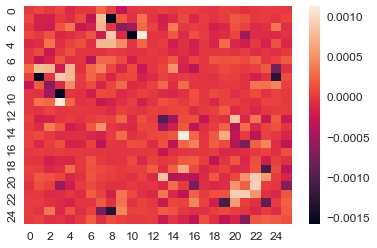

In [11]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

sns.heatmap(
    reconstruct_from_triu(p_triu[0], dim) - 
    reconstruct_from_triu(
        AbstractDataset.denormalize(
            model.predict(s_triu_norm[0].reshape(1, -1)),
            mean=y_mu,
            std=y_std
        ),
        dim
    )
)